In [1]:
# COMMON IMPORTS FOR THE WHOLE CODE
import pandas as pd
# replace numpy with cupy to drastically speed up performance
# means that you must be connected to a gpu to be able to run the notebook
import cupy as np
#import numpy as np
import seaborn as sns


# imports for models : ( source Colab Lecture Code )
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

# import the zscore function from scipi

# from scipy.stats import zscore
plt.style.use("dark_background") # for styling purposes

# Task 1 - Importing, Processing and Vectorizing the Data


---



## 1.1 - Importing the Data


---


We import the data and proccess it to give us the options of using the following training and test splits. We can first preprocess x to give us the following data. 

The training data are labelled before to indicate that they have not been split further into a validation dataset and a test dataset

- `x_train_raw_before, y_train_raw_before | x_test_raw, y_test_raw`: Imported directly from CFAR 10 to compute other dataset
- `x_train_before, x_test`: reshaped raw colour data
- `x_train_gray_before, x_test_gray`: reshaped raw grayscale data
- `x_train_normalized_before, x_test_normalized`: reshaped colour data normalized by pixel range
- `x_train_z_normalized_before, x_test_z_normalized`: reshaped colour data normalized with Z-score

We can then preprocess and onehot encode y so that the `50000 x 1` matrix becomes `500000 x 10`: 
- `y_train_before` - one hot encoded training data
- `y_test` - one hot encoded testing data


The data can be imported using tensorflow. The resulting variables are numpy arrays containing the data for training and testing. There are 50000 instances for training and 10000 instances for testing. The dataset consists of 32x32 images with RGB values, i.e. a pixel channel for red, green, and blue. Images are classified within 10 different classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

In [2]:
import tensorflow as tf
(x_train_raw_before, y_train_raw_before), (x_test_raw, y_test_raw) = tf.keras.datasets.cifar10.load_data()
cifar10_classes = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


print("Training data X: ", x_train_raw_before.shape)
print("Training data Y: ", y_train_raw_before.shape)
print("Test data X: ", x_test_raw.shape)
print("Test data Y: ", y_test_raw.shape)

170498071/170498071 [==============================] - 2s 0us/step
Training data X:  (50000, 32, 32, 3)
Training data Y:  (50000, 1)
Test data X:  (10000, 32, 32, 3)
Test data Y:  (10000, 1)


The data needs to be reshaped to fit into the input layer of the MLP.Lets visualize the original pictures from the test set. 

Training data X:  (50000, 3072)
Test data X:  (10000, 3072)


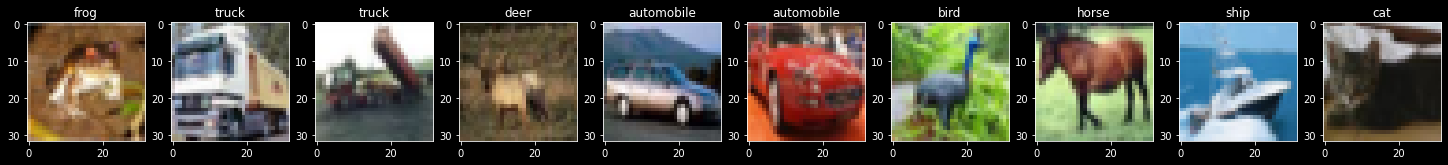

In [3]:
# Reshaping the data
x_train_before = x_train_raw_before.reshape(x_train_raw_before.shape[0], x_train_raw_before.shape[1] * x_train_raw_before.shape[2] * x_train_raw_before.shape[3])
x_test = x_test_raw.reshape(x_test_raw.shape[0], x_test_raw.shape[1] * x_test_raw.shape[2] * x_test_raw.shape[3])

print("Training data X: ", x_train_before.shape)
print("Test data X: ", x_test.shape)

fig, axes = plt.subplots(1, 10, constrained_layout=True, figsize=(20, 20)) 
 
for i in range(10):
    # reshape the data to visualize it
    img = x_train_before[i].reshape(32,32,3)
    axes[i].imshow(img)
    axes[i].set_title(cifar10_classes[int(y_train_raw_before[i])])
plt.show()

## 1.2 - Processing and Vectorizing the Data


---



### 1.2.1 - Vectorizing X

Each image is composed of three superposed layer, one each for RGB values.
https://towardsdatascience.com/data-preprocessing-and-network-building-in-cnn-15624ef3a28b 

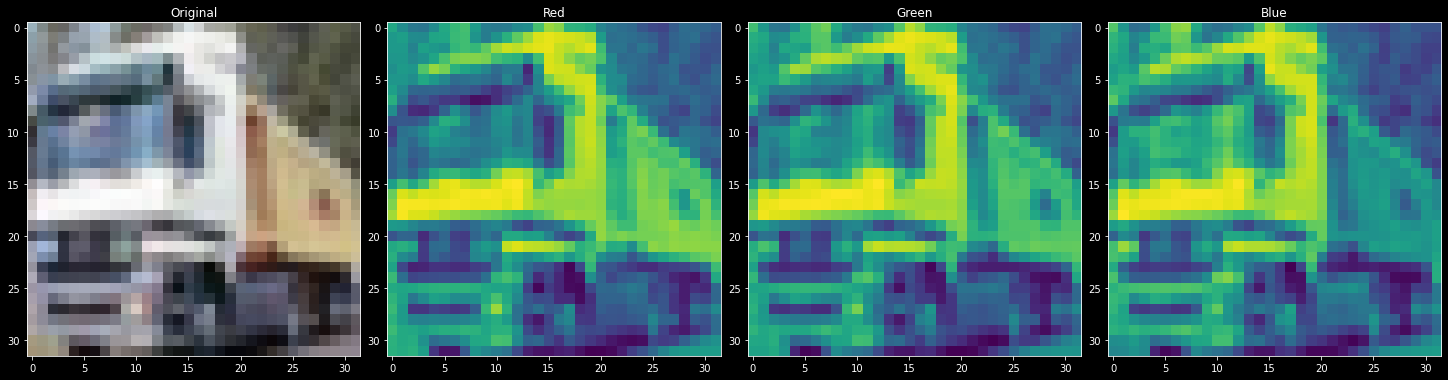

In [4]:
fig, axes = plt.subplots(1, 4, constrained_layout=True, figsize=(20, 20)) 
img = x_train_before[1].reshape(32,32,3) # instance
axes[0].imshow(img)
axes[0].set_title("Original")
axes[1].imshow(img[:, : , 0]) # Red
axes[1].set_title("Red")
axes[2].imshow(img[:, : , 1]) # Green
axes[2].set_title("Green")
axes[3].imshow(img[:, : , 2]) # Blue
axes[3].set_title("Blue")
plt.show()

The images can also be viewed in grayscale.

X train gray shape:  (50000, 1024)
X test gray shape:  (10000, 1024)


<function matplotlib.pyplot.show(close=None, block=None)>

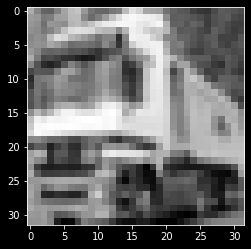

In [5]:
from skimage.color import rgb2gray # from scikit-image
# converting the RGB images into grayscale, i.e. pixel values from 0-1
x_train_gray_raw = rgb2gray(x_train_raw_before)
x_test_gray_raw = rgb2gray(x_test_raw)

x_train_gray_before = x_train_gray_raw.reshape(x_train_gray_raw.shape[0], x_train_gray_raw.shape[1] * x_train_gray_raw.shape[2])
x_test_gray= x_test_gray_raw.reshape(x_test_gray_raw.shape[0], x_test_gray_raw.shape[1] * x_test_gray_raw.shape[2])

# print("X train gray shape raw: ", x_train_gray_raw.shape)
# print("X test gray shape raw: ", x_test_gray_raw.shape)
print("X train gray shape: ", x_train_gray_before.shape)
print("X test gray shape: ", x_test_gray.shape)

index = 1
plt.imshow(x_train_gray_before[index].reshape(32,32), cmap=plt.cm.gray)
plt.show

The images can be normalized using the range of values, i.e. dividing by 255.
https://www.kdnuggets.com/2018/10/preprocessing-deep-learning-covariance-matrix-image-whitening.html/3 

X train normalized shape:  (50000, 3072)
X test normalized shape:  (10000, 3072)
Max value is  1.0


Text(0.5, 1.0, 'Normalized (255)')

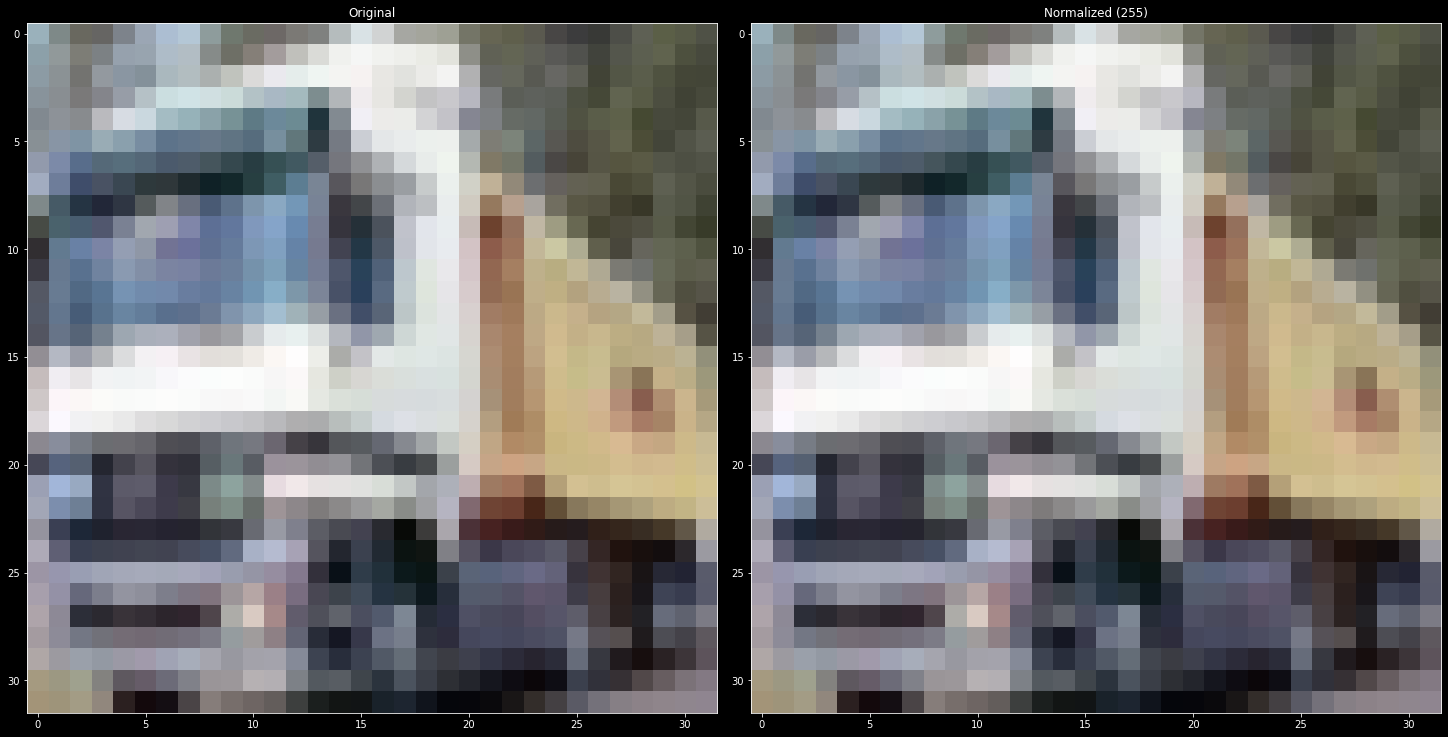

In [6]:
# normalize based on normalized_data = (data - min(data)) / (max(data) - min(data))
# where min(data) = 0, the normalized data ranges for 0-1

x_train_normalized_before = x_train_before / 255.0 
x_test_normalized = x_test / 255.0 

print("X train normalized shape: ", x_train_normalized_before.shape)
print("X test normalized shape: ", x_test_normalized.shape)
print("Max value is ", x_train_normalized_before.max())

index = 1
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 20))
axes[0].imshow(x_train_before[index].reshape(32,32,3))
axes[0].set_title("Original")
axes[1].imshow(x_train_normalized_before[index].reshape(32,32,3))
axes[1].set_title("Normalized (255)")

The data can also be normalized by substracting the mean and dividing by the standard deviation. https://cs231n.github.io/neural-networks-2/

TO KEEP IN MIND: "Common pitfall. An important point to make about the preprocessing is that any preprocessing statistics (e.g. the data mean) must only be computed on the training data, and then applied to the validation / test data. E.g. computing the mean and subtracting it from every image across the entire dataset and then splitting the data into train/val/test splits would be a mistake. Instead, the mean must be computed only over the training data and then subtracted equally from all splits (train/val/test)."

Text(0.5, 1.0, 'Normalized (dataset)')

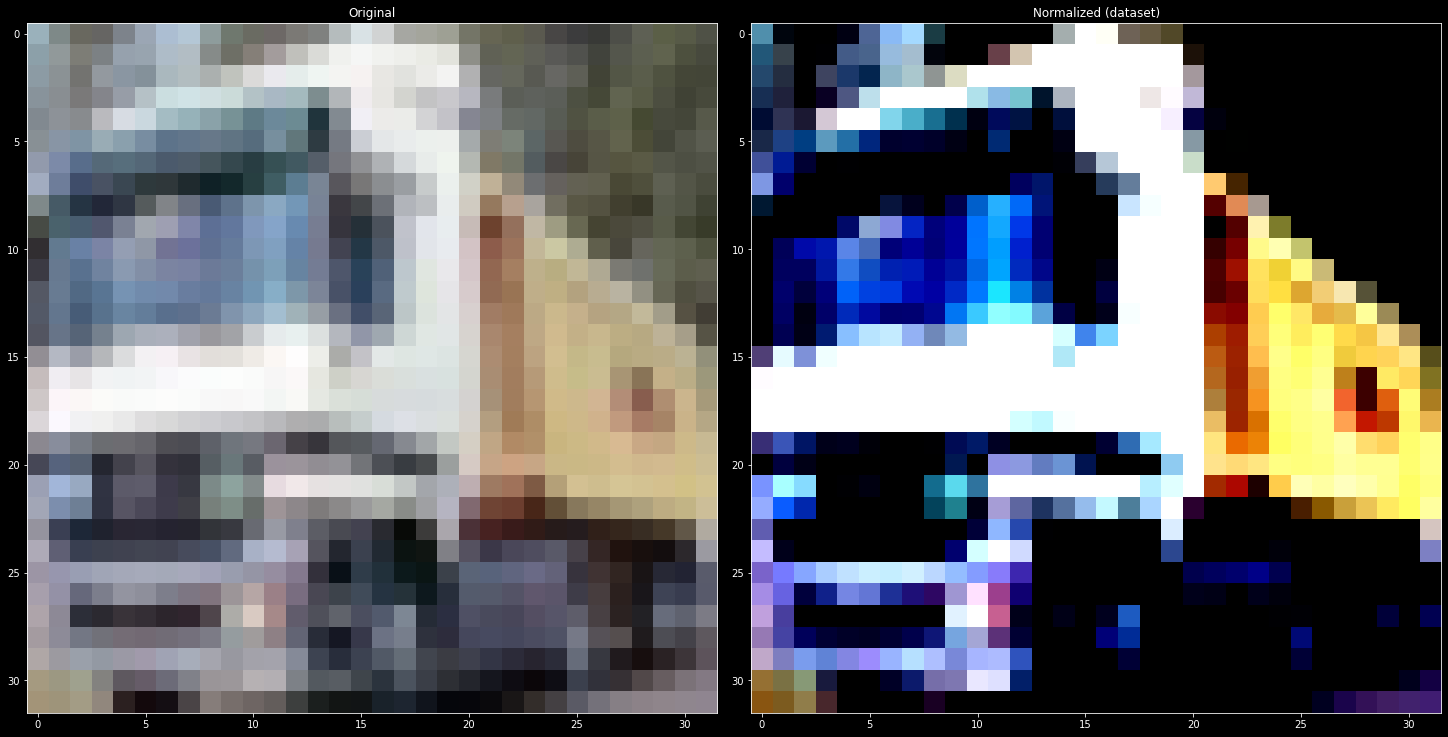

In [7]:
# What should be the axis where we average?
x_train_z_normalized_before = (x_train_before - np.mean(x_train_before, axis=0)) / np.std(x_train_before, axis=0)
# for test data, use only training metrics
x_test_z_normalized = (x_test - np.mean(x_train_before, axis=0)) / np.std(x_train_before, axis=0)

# print("Mean shape: ", np.mean(x_train, axis=0).shape)
# print("STD shape: ", np.std(x_train, axis=0).shape)
# print("X train normalized (Z) shape: ", x_train_z_normalized.shape)
# print("X test normalized (Z) shape: ", x_test_z_normalized.shape)

# print("Mean is ", np.mean(x_train_z_normalized))
# print("STD is ", np.std(x_train_z_normalized))

index = 1
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 20))
axes[0].imshow(x_train_before[index].reshape(32,32,3))
axes[0].set_title("Original")
axes[1].imshow(x_train_z_normalized_before[index].reshape(32,32,3))
axes[1].set_title("Normalized (dataset)")

The data can also be whiten using PCA (Principal component analysis). https://medium.com/@sebastiannorena/pca-principal-components-analysis-applied-to-images-of-faces-d2fc2c083371

In [8]:
# from sklearn.decomposition import PCA
# #n_components=0.80 means it will return the Eigenvectors that have the 80% of the variation in the dataset
# x_train_pca = PCA(n_components=0.90)
# # pca_data = normSubMean_x_train[:200,:]
# pca_data = x_train_normalized[:200,...]
# x_train_pca.fit(pca_data) # fit function expects 2D array
# components = x_train_pca.transform(pca_data)
# projected = x_train_pca.inverse_transform(components)

# print(x_train_pca.components_.shape)
# print(components.shape)
# print(projected.shape)
# plt.imshow(projected[1])
# # fig, axes = plt.subplots(1,1,figsize=(9,9))
# # # for i, ax in enumerate(axes.flat):
# # axes[0].imshow(x_train_pca.components_[i].reshape(32,32,3))


### 1.2.2 - Vectorizing Y

In [9]:
from sklearn.preprocessing import OneHotEncoder
# one hot encode training and testing data
encoder = OneHotEncoder(categories ='auto',sparse =False)
encoder.fit(y_train_raw_before)
y_train_before = encoder.transform(y_train_raw_before)
encoder.fit(y_test_raw)
y_test = encoder.transform(y_test_raw)
y_train_before = np.array(y_train_before)
y_test = np.array(y_test)
# assert this worked
assert (y_train_before.shape == (50000,10))
assert (y_test.shape == (10000,10))


In [10]:
# for unnormalized training
x_train_before = np.array(x_train_before)
x_test = np.array(x_test)

x_train_raw_before = np.array(x_train_raw_before)
y_train_raw_before = np.array(y_train_raw_before)
x_test_raw = np.array(x_test_raw)
y_test_raw = np.array(y_test_raw)
x_train_normalized_before = np.array(x_train_normalized_before)
x_test_normalized= np.array(x_test_normalized)
x_train_z_normalized_before = np.array(x_train_z_normalized_before)
x_test_z_normalized = np.array(x_test_z_normalized)
x_train_gray_before = np.array(x_train_gray_before)
x_test_gray = np.array(x_test_gray)

# set the plot style background back to white
plt.style.use('default')


Convert the numpy arrays to cupy arrays for maximum GPU utilization

# Task 2 - Creating the Multilayer Perceptron Class

---

Before creating the class for our MultiLayer Perceptron, we can define activation functions we will use at each layer, as well as the gradient function we will use to calculate the gradient at each epoch. 


# Task 2 - NOT WORKING - Less Modular Attempt

We wanted to code an MLP that had the flexibility of having more than 2 layers, as well as potentially mixing different kinds of non linear layers in between. This was our first attempt with a hand coded back propagation function, but it did not work. We moved on to a far more modular architecture afterwards - in section 2.4. This code is left to document our first attempt

## 2.1 - Functions

In this section, we define 
- `Activation functions`: Functions that can be passed to our MLP to act as the activation functions at each layer
- `Gradient Function`: The function that calculates the gradient for each parameter in the model using a minibatch



### 2.1.1 - Activation Functions


---



Below is a class that contains reusable activation functions. These functions can be passed in to the Multi Layer Perceptron to be used at each hidden layer. In addition, the derivative of all of these functions is also contained in this class. They include: 
- `identity` - $ f(x) = x $

- `logistic` - $ f(x) = \dfrac{1}{1 + e^{-x}} $

- `reLU` - $ f(x) = \max(0, x) $

- `tanh` - $ f(x) = \dfrac{e^x - e^{-x}}{e^x + e^{-x}} $

- `leakyReLU` - $ f(x) = \max(0, x) + \gamma\min(0, x) $ 

    where $\gamma$ is a hyperparameter that determines the slope of the function for negative inputs.

- `softmax` - $ f(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$

    used for the final output layer of the image classifier

The function takes in three **arguments**: 

- `functionName` - a string that is either identity, logisitc, reLU, tanh, leakyReLU or softmax, with ReLU used as default
- `gamma` - for the leakyReLY function, set by default to 0.1

An instance of this class has three **properties**: 

- `function` - the function itself, a lambda function with one input x
- `derivative` - the derivative of the function as a lambda function
- `name` - a string name of the function



In [ ]:
class ActivationFunction:
    def __init__(self, functionName='reLU', gamma=0.1):
        # lambda functions for each of the activation functions
        identity = lambda x: x
        logistic = lambda x: 1. / (1 + np.exp(-x))
        reLU = lambda x: np.maximum(x, 0)
        tanh = lambda x: 2 * logistic(x) - 1
        leakyReLU = lambda x: reLU(x) + gamma * np.minimum(x, 0)
        # we subtract the max value to prevent overflow in the softmax function
        # assisted by Chat GPT
        softmax = lambda x, axis=1: np.exp(x - np.max(x, axis=axis, keepdims=True)) / np.sum(np.exp(x - np.max(x, axis=axis, keepdims=True)), axis=axis, keepdims=True)


        # derivative functions
        identityDer = lambda x: 1
        logisticDer = lambda x: logistic(x) * (1 - logistic(x))
        reLUDer = lambda x: np.where(x > 0, 1, 0)
        tanhDer = lambda x: 1 - np.power(tanh(x), 2)
        leakyReLUDer = lambda x: np.where(x > 0, 1, gamma)

        # dictionary containing each of the activation functions
        functions = {
            'identity': identity,
            'logistic': logistic,
            'reLU': reLU,
            'tanh': tanh,
            'leakyReLU': leakyReLU,
            'softmax' : softmax
        }

        derivatives = { 
            'identity': identityDer,
            'logistic': logisticDer,
            'reLU': reLUDer,
            'tanh': tanhDer,
            'leakyReLU': leakyReLUDer
        }

        # set properties to chosen one. If name not in dict, use identity
        self.function = functions.get(functionName, identity)
        self.name = functionName
        self.derivative = derivatives.get(functionName, identity)


In [ ]:
# example usage
x = np.array([-10, -1, 0, 1, 10])
g = ActivationFunction('reLU')
print(g.name)
g.function(x)

### 2.1.2 - Gradient Function


---

Below is our implementation of a resuable gradient function. This function can either be hard coded to work on an MLP with either 2, 1 or 0 hidden layers, or it can be coded to work with a back propagation algorithm. 

The `gradient` function with back propagation for the MLP works as follows: 
- First, perform a forward pass starting from the inputs and computing the output at each layer with the same activation function, all the way until you reach the output layer, `yh`, which uses the softmax function
- Then, perform a backwards pass and calculate the gradient at each layer, depending on the gradient from the previous layer. For the set of weights in the final layer, the following formula applies:
 $$ \frac{dL}{d\hat{y}} \times \frac{d\hat{y}}{du_c} \times \frac{du_c}{dW} $$
- In general, the back propagation formula is: 
 $$ errorAbove \times previousWeight \times derivativeOfActivationFunction \times lowerLayer$$

The gradient function takes in the following **parameters**: 
- `x` - the input data
- `y` - the output data
- `params` - the list of parameters in the model
- `activation` - an `ActivationFunction` object, which contains both the function and its name
- `minibatch` - a list of indicies indicating which datapoints to use to calculate the gradient

The hard coded gradient function works for either 2, 1 or 0 hidden layers. Hopefully we wil not have to do it


In [ ]:

# Functions
softmax = ActivationFunction('softmax')
reLU = ActivationFunction('reLU')

# Gradient calculation method  
def gradient(x,y,params,activation,minibatch):
    # get smaller dataset 
    xp = x[minibatch,:] 
    yp = y[minibatch,]
    N,D = xp.shape

    # forward pass, storing the input into each layer along the way
    grads = []
    inputs = []
    input = xp
    inputs.append(xp)
    # every input layer needs to have ones stacked to account for bias term
    for param in params[:-1]: 
        z = activation.function(np.dot(input,param))
        z = np.column_stack([z, np.ones(input.shape[0])])
        input = z
        inputs.append(z)

    # final layer

    yh = softmax.function(np.dot(input, params[-1]))


    # backward pass 
    
    # dy = (N * C)
    dy = yh - yp 
    # dw = ( M * N ) x ( N * C ) = M * C
    # divide by N to prevent gradient explosion
    dw = np.dot(inputs[-1].T, dy)/N
    grads.append(dw)
    # inputs reveresed for easy indexing
    inputs.reverse()
    output = dy
    # back propagation, following formula described 
    limit = len(inputs)
    for i in range(1, limit):
        errorAbove = output
        previousWeight = params[-i]
        # remove bias row from previous weight
        previousWeight = previousWeight[:-1]
        nextWeight = params[-(i+1)]
        layerBelow = inputs[i]

        activationDerivative = activation.derivative(np.dot(layerBelow,nextWeight))
        # calculate error above
        newErrorAbove = np.dot(errorAbove,previousWeight.T)
        dz =  np.dot(layerBelow.T, newErrorAbove * activationDerivative)
        grads.append(dz)
        output = newErrorAbove

    grads.reverse()
    return grads

# hard coded gradient function
def hardCodedGradient(x,y,params,minibatch,activation=reLU): 

    # get smaller dataset 
    xp = x[minibatch,:] 
    yp = y[minibatch,]
    N,D = xp.shape


    if len(params) == 1: 
        print("TODO")

    elif len(params) == 2:
        print("TODO")

    elif len(params) == 3: 
        print("TODO")   
            
    else: 
        raise ValueError("Invalid number of parameters. Expected 1, 2, or 3.")


## 2.2 - Gradient Descent Class


---



The code for the Gradient Descent class was first coded for MiniProject 1. The `run` method in this class requires a gradient function to be passed into it. This is used to iteratively calculate and adjust the gradient to compute the optimal weight values, using Mini-Batch gradient descent. 

The major adjustment made to this class is that now rather than taking in a single parameter for weights, the run optimizer function takes in a list of parameters that will vary in length depending on how many hidden layers there are in the MLP. 

The Gradient Descent class takes in the following **arguments**:
- `learning_rate` : a float, applied to all gradient descent methods (default 0.001)
- `max_iters`: a float, to indicate after how many iterations the gradient descent should stop (default 1000)
- `epsilon`: a float, to indicate how close the gradient can get to 0 before stopping (default $1^{-8}$)
- `batchSize` - the batch size for gradient descent

For ADAM gradient descent, we have the following **arguments** as well: 
- `beta1`: a float hyperparameter (default 0.9)
- `beta2`: another float hyperparameter (default 0.999)
- `epsilon2`: a final float hyperparameter (default $1^{-8}$)

The gradient descent class contains the following functions: 
* `createMiniBatch` : creates a list of lists of indicies. Each inner list contains `batchSize` number of random indicies that can be used to get the datapoints required to calculate the gradient. Takes in the **arguments**: 
    - `N` - the number of instances in the dataset
    - `batchSize` - the size of the Mini-Batches
*   `run`: Perform the Mini-Batch Gradient Descent algorithm using a gradient calculation function. It takes in the following **arguments**: 
    * `gradient_fn` a method of computing the gradient
    * `x` the x values
    * `y` the y values 
    * `params` a list containing all of the parameters in the model
    * `activation` - the `ActivationFunction` attribute

    * `batchSize` - the size of the Mini-Batch to be used in the stochastic gradient descent

*   `runADAM`: Perform the ADAM algorithm to find the optimal parameters. It uses minibatch gradient descent to caluclate the gradient. Takes in the following **arguments**:
    * `gradient_fn` a method of computing the gradient
    * `x` the x values
    * `y` the y values 
    * `params` a list containing all of the parameters in the model
    * `activation` - the `ActivationFunction` attribute

    * `batchSize` - the size of the Mini-Batch to be used in the stochastic gradient descent




In [ ]:
# THE GRADIENT DESCENT CLASS - TAKEN FROM OUR MINI PROJECT 1 AND ADJUSTED FOR MLPS

class GradientDescent:
    def __init__(self, learning_rate=0.001, max_iters=1e4, epsilon=1e-8, beta1=0.9, beta2=0.999, epsilon2=1e-8,batchSize=32):
        # parameters for gradient descent
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.batchSize = batchSize
        # parameters for the ADAM gradient descent
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon2 = epsilon2
        pass

    # Create mini-batch indices 
    def createMiniBatchIndex(self, N, batchSize):
        miniBatches = []
        # create and randomize list of indicies
        index = list(range(N)) 
        np.random.shuffle(index) 
        numberOfMiniBatches = N // batchSize 
        # break list into batch sizes
        for i in range(numberOfMiniBatches):
            miniBatches.append(index[i * batchSize:(i + 1) * batchSize])
        # add remaining indicies to final batch
        if N % batchSize != 0:  
            miniBatches.append(index[numberOfMiniBatches * batchSize:])
        return miniBatches

    # Mini-Batch Gradient Descent
    def run(self, gradient_fn, x, y, params, batchSize,activation):
        N,D = x.shape
        norms = np.array([np.inf])
        t = 1
        epochReached = True
        minibatches = []
        # while gradient FOR ANY PARAMETER is significantly non zero and there are still more iterations allowed
        while np.any(norms > self.epsilon) and t < self.max_iters:
            # create minibatches
            if epochReached == True: 
                minibatches = self.createMiniBatchIndex(N,batchSize)
                epochReached = False
            numberOfMiniBatches = (N//batchSize)
            minibatch = minibatches[t % numberOfMiniBatches]

            # calculate grad and adjust for all params
            grad = gradient_fn(x, y, params, activation, minibatch)
            for i in range (len(params)): 
                params[i] -= self.learning_rate* grad[i]
            t += 1

            # recalculate minibatches if necessary
            if t!= 0 and t % numberOfMiniBatches == 0 : 
                 epochReached = True
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params

# FOR LATER

    # For Linear Regression with the Adaptive Movement Estimation
    def runADAM(self, gradient_fn, x,y, params, batchSize,activation):
        N, D = x.shape
        grad = np.inf
        t = 1
        m = 0.0 
        s = 0.0 
        epochReached = True
        minibatches = []
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters and t < x.shape[0]:
            
            # create minibatches
            if epochReached == True: 
                minibatches = self.createMiniBatchIndex(N, batchSize)
                epochReached = False
            numberOfMiniBatches = (N//batchSize)
            minibatch = minibatches[t % numberOfMiniBatches]
            
            # calcualte batch gradient
            grad = gradient_fn(x,y,params,activation,minibatch)

            # ADAM gradient descent
            for i in len(params):
                m = self.beta1 * m + (1 - self.beta1) * grad[i]  # Momentum
                s = self.beta2 * s + (1 - self.beta2) * grad[i]**2  # RMSprop
                m_hat = m / (1 - self.beta1**t)  # Bias correction - prevent bias of m towards 0
                s_hat = s / (1 - self.beta2**t)  # Bias correction - prevent bias of s towards 0
                params[i] = params[i] - self.learning_rate * m_hat / \
                    (np.sqrt(s_hat) + self.epsilon2)  # Update weights with adam formula

            t += 1
            # create new minibatches if necessary
            if t!= 0 and t % numberOfMiniBatches == 0 : 
              epochReached = False
        return params



## 2.3 - Multilayer Perceptron Class


---



Below is our Multi Layer Perceptron Class. This class has a varying number of hidden layers, and can also operate on different vector sized inputs. However, since this MLP performs the task of classification, it will always perform a softmax operation at the end, to classify the image input into one of the 10 possible classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.








### 2.3.1 - Class Description


---


The MLP is implemented as a python class. Its constructor takes in in several arguments: 
- `activation` : the activation function that will be applied at each hidden layer, an instance of the `ActivationFunction` class. By default this is set to ReLU
- `noHLayers`: the number of hidden layers that the MLP contains 
- `noUnits`: an array containing the number of  units in each hidden layer. The length of the array should match the `noHLayers`
- `batchSize`: the size of the batches for gradient descent

The constructor will also initialize the weights and biases of the model, as well as its other properties
- `params`: a list of weights of length `noHLayers + 1`, with a bias in the last column

The class will also have both a fit and a predict function: 
- `fit`: inputs of the training data as well as hyper parameters. The function trains the model by modifying its parameters
- `predict`: takes a set of input points and then predicts their output

The fit function for the MLP takes in a parameter called an `optimizer`. This is a object or instance of the class `GradientDescent`, which extrapolates the calculation of the gradient to allow us to use different functions for different techniques. 

An optimizer object has a defined method called run, which uses Mini-Batch gradient descent to optimize the parameters of the model: `optimizer.run(self, gradient_fn, x, y, params, batchSize, activation)` which takes in: 

* `gradient_fn` a method of computing the gradient, and instance of the `ActivationFunction` class
* `x` the x values
* `y` the y values 
* `params` a list containing all of the parameters in the model
* `batchSize` - the size of the Mini-Batch to be used in the stochastic gradient descent
* `activation` - the `ActivationFunction` attribute



### 2.3.2 - MLP Theory Description


---


We would like to implement a multi layer neural network for multiclass classification, and then train it using gradient descent. It will be applied to the CFAR 10 Dataset using the default training and testing spit. 

The model will have a variable number of hidden layers and units within those layers, with a choice of which activation functions to use. The same activation function will be applied at every layer. Take for example a model with one hidden layer, with a sigmoid activation function at this layer and the output. This would give us the model: 

$$
\hat{y} = softmax \left ( W \sigma \left ( V x \right ) \right)
$$

where we have $M$ hidden units and $D$ input features -- that is $w \in \mathbb{R}^{M}$, and $V \in \mathbb{R}^{M \times D}$.


---


### Weight Initialization 


---



The model will use gradient descent to adjust the weights to minimize cost on the training dataset. The weights are initialized using `w = np.random.randn(n) * sqrt(2.0/n)`, and all biases are set to 0, as recommended by [this link](https://cs231n.github.io/neural-networks-2/#datapre)

- Since this MLP classifies images into a set of 10 possible outcomes, its output will be an `N` $\times$ `10` dimenstional matrix, where N is the number of images in the input. This means that the final weight matrix, $W$, must have dimensions `noHUnits[-1] + 1` $ \times $ `10` 

- Each weight matrix inbetween, lets say $V_n$, will have dimensions `noHUnits[n-2] + 1` $\times$ `noHUnits[n-1] `

- The plus one is to account for biases





### 2.3.3 - Class Implementation 

Nuff Said

In [ ]:
# MULTI LAYER PERCEPTRON CLASS
presetActivation = ActivationFunction('ReLU')
presetGradient = lambda x,y,params,activation,minibatch: gradient(x,y,params,activation,minibatch)

class MultiLayerPerceptron: 
    # constructor
    def __init__(self, activation=presetActivation, gradientFunction=presetGradient, noHLayers=1, noHUnits=[64], learningRate = 0.01, maxIterations = 1000, batchSize = 1000): 
        self.activation=activation
        self.gradientFunction=presetGradient
        self.noHLayers = noHLayers
        self.noHUnits = noHUnits
        self.learningRate = learningRate
        self.maxIterations = maxIterations
        self.batchSize = batchSize
        self.params = []
  

    # fit function 
    def fit(self, x, y, optimizer):
 
        # pad the input with 0s for bias term
        if x.ndim == 1:
            x = x[:, None]
        N = x.shape[0]
        x = np.column_stack([x, np.ones(N)])

        # get the new input dimensions
        N,D = x.shape 

        # get the output dimensions
        C = y.shape[1]

        # initialize params - a list because of multiple layers 
        # biases are appended at the end of each weight matrix and intialized to 0
        params0 = []
        if self.noHLayers >= 1:
            first = 0.01 * np.random.randn(D-1, self.noHUnits[0])/np.sqrt(2.0/(D-1))
            first = np.vstack([first, np.zeros(self.noHUnits[0])])
            params0.append(first)
  
        # intialize other V parameters
        if self.noHLayers >= 2:
            for i in range(self.noHLayers): 
                if i != self.noHLayers-1: 
                    next = 0.01 * np.random.randn(self.noHUnits[i],self.noHUnits[i+1])/np.sqrt(2.0/self.noHUnits[i])
                    next = np.vstack([next, np.zeros(self.noHUnits[i+1])])
                    params0.append(next)
                

        #initialize W
        if len(self.noHUnits)>0:
            last = 0.01 * np.random.randn(self.noHUnits[self.noHLayers-1],C)/np.sqrt(2.0/self.noHUnits[self.noHLayers-1])
            last = np.vstack([last, np.zeros(C)])
            params0.append(last)
        elif len(self.noHUnits) == 0:
            last = 0.01 * np.random.randn(D-1,C)/np.sqrt(2.0/(D-1))
            last = np.vstack([last, np.zeros(C)])
            params0.append(last)

        # calculate the optimal parameters
        self.params = optimizer.run(self.gradientFunction, x, y,params0,self.batchSize,self.activation)
        
        # return the updated model
        return self
    
    def predict(self, x): 
        # forward pass to predict outputs
        if x.ndim == 1:
            x = x[:, None]
        N = x.shape[0]
        x = np.column_stack([x, np.ones(N)])
        input = x
        for param in self.params[:-1]: 
            z = self.activation.function(np.dot(input,param))
            z = np.column_stack([z, np.ones(input.shape[0])])
            input = z
        # final layer
        yh = softmax.function(np.dot(input, self.params[-1]))
        return yh

### 2.3.4 - Test if The Model Works

Basic simple tests to see if the model works and debug the code. We will test it on the IRIS dataset and see if it works in the same way as the tutorial example

In [ ]:
# # Test if it works with default settings and logistic activation function
# relu = ActivationFunction('reLU')
# model = MultiLayerPerceptron(activation = relu,noHLayers=2, noHUnits=[64,64], learningRate = 0.01, maxIterations = 1000, batchSize = 1000)

# optimizer = GradientDescent(learning_rate=.1, max_iters=1000,batchSize=500)
# yh = model.fit(x_train_normalized, y_train, optimizer).predict(x_test_normalized)
# print(yh[20])
# print(y_test[20])

# Task 2 - FINAL MODEL - More Modular Attempt

This was our far more modular attempt, that allows for multiple hidden layers that also can have different kinds of layers mixed together

## 2.3 - Evaluate Accuracy


---

`evalutate_acc` - function used to evaluate the accuracy of the model

In [11]:
def eval_acc(yh, y):
    return (yh == y).sum() / len(y)

## 2.4 - Modular MLP Class 


---

Using a more modular approach, we can create an MLP class that can have different activation functions at each layer and is a lot more modular. This architecture is heavily inspired by [This Colab From Last Semester](https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/NumpyDeepMLP.ipynb). Documentation is also inspired by this link but all explanations are put into our own words

Each Networks is a series of layers, each of which is a class that is an instance of the neural network class. The linear layer class will be used to sum the values from all the hidden units below and apply the weight vector. After these classes, non linear functions will be put on top. These functions do not contain parameters of thier own, but add the non linearity of the model

All weights are initalized in the same way as before `(w = np.random.randn(n) * sqrt(2.0/n)`, acording to [this link](https://cs231n.github.io/neural-networks-2/#datapre). All biases are set to 0. The initalization of weights really seems to affect model performance





### 2.4.1 - The Neural Network Class

This class defines the attributes that all neural network layers must have: 

- `gradient` - the gradient to update the parameters with
- `parameters` - the parameters of the layer

Every instance of this class will have the following functions: 

- `forward` - the function that allows a layer to produce the output that is passed to the next one
- `backward` - the function that allows the layer to update its parameters given a specific gradient

In [12]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

### 2.4.2 - The Linear Layer

This linear layer is a subclass of a NeuralNetLayer

This layer takes in a specific number of neurons as input, outputs a specific number as output, and has weights and biases that are initialized to the right values: 
- `si` - size of the input
- `so` - size of the output
- `w` - its weights
- `b` - its biases 
- `cinput` - stores the current input of the layer to be used in a future gradient back propogation (gives access to input $x$ later)

Given the input x, this layer computes 
$$ x' = Wx + b $$

The layer inplements its own foward and backward functions: 
- `forward` - stores the current input and caculates $x'$
- `backward` - only works if forward has been called first. It computes the gradient of the weights and biases at the current layer, and then returns the gradient times the weight to be used by the layer below 

In [13]:
class LinearLayer(NeuralNetLayer):

    def __init__(self, input_size, output_size):
        super().__init__()
        self.si = input_size
        self.so = output_size
        self.w = np.random.randn(output_size, input_size)*np.sqrt(2.0/output_size)
        self.b = np.zeros(output_size)
        # self.w = np.random.normal(0, 1 / self.so, output_size * input_size).reshape(output_size, input_size)
        # self.b = np.random.normal(0, 1 / self.so, output_size)
        self.cinput = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cinput = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        # foward must come first
        assert self.cinput is not None, "Forward should be called before backward"
        # calculate gradient of weights and biases
        dw = gradient[:, :, None] @ self.cinput[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        # return the value to be used by the next layer
        return gradient.dot(self.w)

### 2.4.3 - Hidden Layers



#### 2.4.3.1 - The ReLU Hidden Layer

This class is a subclass of the neural network layer. However, it does not maintain any parameters - it is only meant to add non linearity to a linear layer: 
- `forward` - set the gradient of the layer, and apply reLU to the input
- `backward` - apply the gradient of the layer with the gradient to the layers above, and pass it along

In [14]:
class ReLULayer(NeuralNetLayer):
    
    def __init__(self):
        super().__init__()

    # apply reLU to the input layer and set the gradient vector
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    # pass the gradient backwards
    def backward(self, gradient):
        assert self.gradient is not None, "Forward should be called before backward"
        return gradient * self.gradient

#### 2.4.3.2 - The Tanh Hidden Layer

This layer has the following methods: 
- `forward` - set the gradient of the layer, and apply Tanh to the input
- `backward` - apply the gradient of the layer with the gradient to the layers above, and pass it along

In [15]:
class TanhLayer(NeuralNetLayer):
    
    def __init__(self):
        super().__init__()

    # apply tanh to the input layer and set the gradient vector
    def forward(self, x):
        logistic = lambda x: 1. / (1 + np.exp(-x))
        tanh = 2 * logistic(x) - 1
        tanhDer = 1 - np.power(tanh, 2)
        self.gradient = tanhDer
        return tanh

    # pass the gradient backwards
    def backward(self, gradient):
        assert self.gradient is not None, "Forward should be called before backward"
        return gradient * self.gradient

#### 2.4.3.3 - Leaky ReLU
This layer has the following methods: 
- `forward` - set the gradient of the layer, and apply LeakyReLU to the input
- `backward` - apply the gradient of the layer with the gradient to the layers above, and pass it along

In [16]:
class LeakyReLULayer(NeuralNetLayer):
    
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    # apply reLU to the input layer and set the gradient vector
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, self.gamma)
        return np.maximum(0, x) + self.gamma * np.minimum(0,x)

    # pass the gradient backwards
    def backward(self, gradient):
        assert self.gradient is not None, "Forward should be called before backward"
        return gradient * self.gradient

### 2.4.4 - The Softmax Output Layer

Simlar to the reLU layer, this layer is an instance of the NeuralNetLayer class that does not maintain any parameters, it simply applies the softmax function to the inputs it recieves from below

As shown in the colab, the gradient of the cross entropy loss for classification is simple when it is combined with the softmax function. This is the same formula we used in the previous implementation: 
$$
\nabla_x\mathsf{CrossEntropyLoss}(\mathsf{Softmax}(x), y) = \mathsf{Softmax}(x) - y
$$

In this case, $y$ are the expected outputs or classes

Thus, this class implements the functions: 
- `forward` - apply the softmax function to the layers below to produce the output probabilities for each class. Store these probabilities 
- `backward` - take in the input as $y$ and calculate $\nabla_x\mathsf{CrossEntropyLoss}(\mathsf{Softmax}(x), y)$

In [17]:
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.probability = None
        
    # forward propagation
    def forward(self, x):
        # softmax function ( subtract the max value as shown in lectures )
        exponents = np.exp(x - np.max(x))
        probability = exponents / np.sum(exponents, axis=-1)[:, None]
        self.probability = probability
        return probability
    # back propagation, taking expected y values as input
    def backward(self, target):
        assert self.probability is not None, "Forward should be called before backward"
        return self.probability - target

### 2.4.5 - Optimizing the MLP

The MLP will be optimized using a back propagation algorithm and minibatch gradient descent. 

To do so, we will create a genearic class called Optimizer that we will use to optimize the neural netrwork. This Optimizer has the following functions: 
- `run` - this method applies the updateParams method to each layer
- `updateParams` - given a set of parameters and gradients, update the parameters


We will implement an optimizer that uses minibatch gradient descent to optimize the MLP. The GradientDescentOptimizer has the following arguments: 
- `learningRate` - the learningRate for the gradient descent


In [18]:
class Optimizer:
    
    def __init__(self, neuralNetwork):
        self.neuralNetwork = neuralNetwork

    # apply the update function to all layers
    def step(self):
        # for all hte layers starting from the top
        for layer in self.neuralNetwork.layers[::-1]:
            # update parameters of this layer
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    # to be implemented by subclass
    def update(self, params, gradient):
        raise NotImplementedError

# optimizer that will implement the update method
class GradientDescentOptimizer(Optimizer):
    def __init__(self, neuralNetwork, learningRate, regularization=None, _lambda=0.01):
        super().__init__(neuralNetwork)
        self.learningRate = learningRate
        self.regularization = regularization
        self._lambda = _lambda


    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.learningRate * g.mean(axis=0)

            # L1 regularization
            if self.regularization == 'L1':
                p -= self.learningRate * self._lambda * np.sign(p)
            
            # L2 regularization
            if self.regularization == 'L2':
                p -= self.learningRate * self._lambda * p


### 2.4.6 - EXTRA - Adam Gradient Descent

Attempting to incldue the option to use an optimizer with adam gradient descent. This code was adapted form our mini project 1. We basically have to adjust for the fact that now our weights are a matrix, and that there is a weight and bias parameter for each layer. That implies that each layer needs to have a corresponding list of momentums and gradients for each 


In [19]:
# optimizer that will implement the update method
class AdamDescentOptimizer():
    def __init__(self, neuralNetwork, learningRate, beta1, beta2, epsilon,reg='none', _lambda=0):
        self.neuralNetwork = neuralNetwork
        self.learningRate = learningRate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.regularization=reg
        self._lambda = _lambda

        # we also need each layer to have a momentum (m) and adaptive learning rate (s) factors initialized to 0
        # the dimensions of these must match the gradient of each layer
        self.momentums = list(np.zeros(len(neuralNetwork.layers)))

        self.adaptiveRates = list(np.zeros(len(neuralNetwork.layers)))
        # initalize momentums and learning rates for layers with parameters
        # BEWARE : A layer has both a weights parameter and bias parameter, both of which must be updated
        # Store a list of momentums, one for the param, one for the bias. Same dimensions as inital weights and params
        for i in range(len(neuralNetwork.layers)): 
            currentLayer = neuralNetwork.layers[i]
            if currentLayer.parameters is not None:
                self.momentums[i] = [np.zeros((currentLayer.so, currentLayer.si)), np.zeros((currentLayer.so))]
                self.adaptiveRates[i] = [np.zeros((currentLayer.so, currentLayer.si)),np.zeros((currentLayer.so))]
      
    # apply the update function to all layers. This time take the iteration as an argument
    def step(self, iteration):
        # for all the layers starting from the top
        i = len(self.neuralNetwork.layers) - 1
        for layer in self.neuralNetwork.layers[::-1]:
            # update parameters of this layer
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient,iteration+1,i)
            i -= 1


    def update(self, params, gradient, iteration,i):
        index = 0
        for (p, g) in zip(params, gradient):
            # copy code from old colab and modify for this one
            m = self.beta1 * self.momentums[i][index] + (1 - self.beta1) * g.mean(axis=0)  # Momentum
            s = self.beta2 * self.adaptiveRates[i][index] + (1 - self.beta2) * g.mean(axis=0)**2  # RMSprop
            m_hat = m / (1 - self.beta1**iteration)  # Bias correction - prevent bias of m towards 0
            s_hat = s / (1 - self.beta2**iteration)  # Bias correction - prevent bias of s towards 0
            p -= self.learningRate * m_hat / \
                (np.sqrt(s_hat) + self.epsilon)  # Update weights with adam formula
            self.momentums[i][index] = m
            self.adaptiveRates[i][index] = s
            index += 1

            # L2 regularization
            if self.regularization == 'L2':
                p -= self.learningRate * self._lambda * p



### 2.4.7 - Creating an MLP

The MLP will be created to consist of layers, each of which is a linear layer followed by a functional layer that does not maintain parameters but adds non linearity to the model. 

Every layer has both a `forward` and `backward` method. To predict the outputs of the classes, we simply need to run the foward method of all layers all the way to the output. 

To perform back propagation to caclulate gradients and adjust the weights of each layer, we must start from the top, the `SoftmaxOutputLayer`, and call the backward method of each layer going back down. The output of each backward call is passed to the next one as its inputs. 

With each backward call, each linear layer is storing gradient vectors that match their input parameters. However, actually optimizing the values of each parameter will require a seperate function 

The MLP is initialized with the argument: 
- `inputLayers` - a list of `NeuralNetLayers` that will make up the MLP in order

The MLP will have the following functions: 
- `forward` - run the forward function on all layers
- `backward` - run the backward function on all layers for back propagation, passing the result of each to the next iteration
- `fit` - using the optimizer, train the MLP to have the correct weights
    - `optimizer` - an `Optimizer` object
    - `x` - the x data
    - `y` - the y data
    - `maxIter` - the max number of iterations the training should run for
    - `batchSize` - the size of minibatch gradient descent, set by defualt to 500
- `fitEarlyStop` - train the model with early stopping


The class constructor also has the option of using the following arguments to make the MLP:
- `noHLayers` - the number of hidden layers 
- `noHUunits` - a list containing which activation functions to use at which layer
- `activation` - a string for the activation function at each layer



In [20]:
import copy
from tqdm import tqdm

# function to create minibatches needed by MLP
def createMiniBatchIndex(N, batchSize):
    miniBatches = []
    # create and randomize list of indicies
    index = np.array(range(N)) 
    np.random.shuffle(index) 
    numberOfMiniBatches = N // batchSize 
    # break list into batch sizes
    for i in range(numberOfMiniBatches):
        miniBatches.append(index[i * batchSize:(i + 1) * batchSize])
    # add remaining indicies to final batch
    if N % batchSize != 0:  
        miniBatches.append(index[numberOfMiniBatches * batchSize:])
    return miniBatches

class MLP:
    def __init__(self, inputLayers=[],x=x_train_z_normalized_before, y=y_train_before,noHLayers=1, noHUnits=[64],activation='reLU',epsilon=1e-8, max_iters=1e3,gamma=0.1):
        if len(inputLayers) != 0:
            self.layers = inputLayers
            self.epsilon = epsilon
            self.max_iters = max_iters
            self.lossList = []
            self.validationloss = []
            self.testAccuracy = []
            self.trainAccuracy = []
        else:
            layers = []
            hiddenLayer = None
            if activation =='reLU':
                hiddenLayer = ReLULayer()
            elif activation =='tanh':
                hiddenLayer = TanhLayer()
            elif activation =='leakyReLU':
                hiddenLayer = LeakyReLULayer(gamma)
            else:
                print('invalid activation function specified, using ReLU instead')
                hiddenLayer = ReLULayer()

            if (noHLayers ==0):
                layers.append(LinearLayer(x.shape[-1],y.shape[-1]))
                layers.append(SoftmaxOutputLayer())
                print("first and last layer added")
            else: 
                layers.append(LinearLayer(x.shape[-1],noHUnits[0]))
                layers.append(copy.deepcopy(hiddenLayer))
                print("first hidden layer added")
            for i in range (noHLayers-1):
                layers.append(LinearLayer(noHUnits[i],noHUnits[i+1]))
                layers.append(copy.deepcopy(hiddenLayer))
                print("next layer added")
            if noHLayers !=0 : 
                layers.append(LinearLayer(noHUnits[-1],y.shape[-1]))
                layers.append(SoftmaxOutputLayer())
                print("output layer added")
            
            self.layers = layers
            self.epsilon = epsilon
            self.max_iters = max_iters
            self.lossList = []

    # run forward on all layers
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    # run backward on all layers
    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)


    def fit (self, optimizer, x, xv, y,yv, xtest, ytest,ytrain,steps,batchSize=500): 
        N,D=x.shape
        lossList = []
        validationLoss = []
        epochReached = True
        minibatches = []
        t=1
        trainAccuracy = []
        testAccuracy = []
        e = 0
        # while gradient FOR ANY PARAMETER is significantly non zero and there are still more iterations allowed
        for iteration in tqdm(range(steps)):
            # create minibatches and calculate accuracy on epochs
            if epochReached == True: 
                minibatches = createMiniBatchIndex(N,batchSize)
                epochReached = False
                # calculate train accuracy
                yh = self.predictClass(x)
                tra = eval_acc(yh,ytrain).get()
                trainAccuracy.append(tra)

                # calculate test accuracy
                yh = self.predictClass(xtest)
                ta = eval_acc(yh, ytest).get()
                testAccuracy.append(ta)
                print(" Epoch ", e, "| Train: ", tra , " | Test: ",ta)
                e += 1

            numberOfMiniBatches = (N//batchSize)
            minibatch = minibatches[t % numberOfMiniBatches]

            # minibatch = np.random.choice(len(x), batchSize)
            xp = x[minibatch,:]
            yp = y[minibatch,]
            xvp = xv[minibatch,:]
            yvp = yv[minibatch,]


            predictions=self.forward(xp)
           
            loss = -(yp * np.log(predictions)).sum(axis=-1).mean()
            lossList.append(loss.get())

            validation = self.predict(xvp)
            vloss = -(yvp * np.log(validation)).sum(axis=-1).mean()
            validationLoss.append(vloss.get())


            

            self.backward(yp)
            if isinstance(optimizer,AdamDescentOptimizer): 
                optimizer.step(iteration)
            else:
                optimizer.step()
            # recalculate minibatches if necessary
            if t!= 0 and t % numberOfMiniBatches == 0 : 
                 epochReached = True
            t+=1
        self.lossList = lossList
        self.validationLoss = validationLoss
        self.trainAccuracy = trainAccuracy
        self.testAccuracy = testAccuracy
        return self

    def predict(self,x): 
        newMLP = copy.deepcopy(self)
        result = newMLP.forward(x)
        return result

    def predictClass(self,x): 
        newMLP = copy.deepcopy(self)
        result = newMLP.forward(x)
        classLabel = np.argmax(result,axis=1)
        if classLabel.ndim == 1:
            classLabel = classLabel[:, None]

        return classLabel






# Task 3 - Analysis of Models

---

Common functions and parameters for this section


In [21]:
# create a validation dataset with 90-10 split on training data
tvalsplit = 0.9
inds = np.random.permutation(50000)
n_training = int(50000 * tvalsplit)
x_train_z_normalized, x_val_z_normalized = x_train_z_normalized_before[inds[:n_training],:], x_train_z_normalized_before[inds[n_training:],:]
y_train_raw, y_val_raw =  y_train_raw_before[inds[:n_training],:], y_train_raw_before[inds[n_training:],:]
y_train, y_val = y_train_before[inds[:n_training],:], y_train_before[inds[n_training:],:]



In [22]:
# common variables
bsize = 32
learningRate = 0.013
iterations = 33750
b1 = 0.9
b2 = 0.99
epsilon = 1e-4
iterationsAdam = 33750
lradam = 0.0004





def plotAccuracy(yh,losses,vlosses,title,color1='green', color2='blue',iterations=iterations, adam=False,override=False,i=0): 
    if adam: 
        iterations = iterationsAdam
    if override: 
      iterations= i
    print("This is your test accuracy")
    print(eval_acc(yh,y_test_raw))
    plt.style.use('default')
    # plot training and validation loss
    plt.title(title)
    plt.plot(losses, label ="training loss", color=color1, linewidth=2)
    plt.plot(vlosses, label ="validation loss",color=color2, linewidth=2)
    if iterations >= 10000:
        datasize = x_train_z_normalized.shape[0]
        epochs = ((((iterations*bsize)//datasize)))
        # change labels to epochs
        xticks = [i for i in range(0, epochs+(epochs//6), ((epochs//6)))]
        
        ticklocations = np.linspace(0,iterations,7)
        plt.xticks(ticklocations.get(), xticks)

    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy Loss")
    plt.legend(loc='upper right')
    plt.show()

def plotTestTrain(testaccuracy, trainaccuracy,title, color1='m', color2='c'): 
    plt.style.use('default')
    plt.title(title)
    plt.plot(testaccuracy,label = 'test accuracy',color=color1, linewidth=2)
    plt.plot(trainaccuracy,label = 'training accuracy',color=color2, linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='lower right')
    plt.show()

# added this later - should have refactored all code to use this but there was no time
def completeEval(model,trainset,testset,title1,title2, color1="olive", color2="gray",adam=False,override=False,i=0): 
    yh = model.predictClass(testset)
    losses = model.lossList
    vlosses = model.validationLoss
    plotAccuracy(yh,losses,vlosses,title1, color1 = color1, color2 = color2,adam=adam,override=override,i=i)

    yh = model.predictClass(trainset)
    print("This is your training accuracy")
    print(eval_acc(yh,y_train_raw))

    testAccuracy = model.testAccuracy
    trainAccuracy = model.trainAccuracy
    plotTestTrain(testAccuracy, trainAccuracy, title2,color1=color1,color2=color2)


def completeEvalMany(things, title,trainset, testset): 
  plt.style.use('default')
  for thing in things:
    testAccuracy = thing[0].testAccuracy
    trainAccuracy = thing[0].trainAccuracy


    plt.plot(trainAccuracy,label = thing[1],color=thing[3], linewidth=2,linestyle='--')
    plt.plot(testAccuracy,label = thing[2],color=thing[3], linewidth=2)

  plt.title(title)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='lower right')
  # added thanks to chat GPT
  legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.subplots_adjust(right=0.8)
  plt.show()


## 3.1 - Network Depth and Non Linearity



### 3.1.1 - 3 Hidden Layers

Train the model. Because of RAM limitations, we used 128 hidden units

In [24]:
# testing creating a 3 hidden layer MLP
mlptest3 = MLP(noHLayers=3, noHUnits=[256,256,256],x =x_train_z_normalized,y=y_train,activation='reLU')
optimizer = GradientDescentOptimizer(mlptest3,learningRate)
trained3 = mlptest3.fit(optimizer, x_train_z_normalized,x_val_z_normalized, y_train,y_val,x_test_z_normalized,y_test_raw,y_train_raw,iterations,bsize)





first hidden layer added
next layer added
next layer added
output layer added


  0%|          | 0/33750 [00:00<?, ?it/s]

 Epoch  0 | Train:  0.10575555555555556  | Test:  0.1048


  4%|▍         | 1421/33750 [00:29<14:59, 35.93it/s]

 Epoch  1 | Train:  0.37677777777777777  | Test:  0.3598


  8%|▊         | 2821/33750 [00:43<25:08, 20.51it/s] 

 Epoch  2 | Train:  0.4362  | Test:  0.4028


 12%|█▏        | 4217/33750 [00:59<03:30, 140.29it/s]

 Epoch  3 | Train:  0.46842222222222224  | Test:  0.4221


 17%|█▋        | 5639/33750 [01:14<12:33, 37.32it/s]

 Epoch  4 | Train:  0.5086  | Test:  0.4422


 21%|██        | 7045/33750 [01:26<11:26, 38.87it/s]

 Epoch  5 | Train:  0.5398444444444445  | Test:  0.4542


 25%|██▌       | 8461/33750 [01:37<11:29, 36.67it/s]

 Epoch  6 | Train:  0.5667111111111112  | Test:  0.4605


 29%|██▉       | 9850/33750 [01:50<17:50, 22.32it/s]

 Epoch  7 | Train:  0.5862  | Test:  0.464


 33%|███▎      | 11268/33750 [02:09<14:25, 25.97it/s]

 Epoch  8 | Train:  0.6137555555555556  | Test:  0.4658


 38%|███▊      | 12680/33750 [02:23<09:08, 38.45it/s]

 Epoch  9 | Train:  0.6396222222222222  | Test:  0.4651


 42%|████▏     | 14075/33750 [02:39<13:48, 23.74it/s]

 Epoch  10 | Train:  0.6597333333333333  | Test:  0.4715


 46%|████▌     | 15482/33750 [02:58<14:14, 21.39it/s]

 Epoch  11 | Train:  0.6742222222222222  | Test:  0.4696


 50%|█████     | 16895/33750 [03:13<07:24, 37.94it/s]

 Epoch  12 | Train:  0.6943555555555555  | Test:  0.461


 54%|█████▍    | 18306/33750 [03:25<06:40, 38.53it/s]

 Epoch  13 | Train:  0.7186  | Test:  0.4654


 58%|█████▊    | 19701/33750 [03:37<06:03, 38.68it/s]

 Epoch  14 | Train:  0.7346666666666667  | Test:  0.4582


 63%|██████▎   | 21115/33750 [03:49<05:32, 38.06it/s]

 Epoch  15 | Train:  0.7595333333333333  | Test:  0.4689


 67%|██████▋   | 22514/33750 [04:07<07:15, 25.80it/s]

 Epoch  16 | Train:  0.7739111111111111  | Test:  0.4599


 71%|███████   | 23918/33750 [04:25<05:36, 29.20it/s]

 Epoch  17 | Train:  0.7869555555555555  | Test:  0.4591


 75%|███████▌  | 25326/33750 [04:41<05:58, 23.49it/s]

 Epoch  18 | Train:  0.7947333333333333  | Test:  0.4649


 79%|███████▉  | 26727/33750 [04:59<04:41, 24.93it/s]

 Epoch  19 | Train:  0.8218222222222222  | Test:  0.4599


 83%|████████▎ | 28134/33750 [05:13<02:37, 35.58it/s]

 Epoch  20 | Train:  0.8314222222222222  | Test:  0.4689


 88%|████████▊ | 29533/33750 [05:26<03:18, 21.29it/s]

 Epoch  21 | Train:  0.8460666666666666  | Test:  0.4652


 92%|█████████▏| 30951/33750 [05:42<01:15, 37.10it/s]

 Epoch  22 | Train:  0.8512222222222222  | Test:  0.4604


 96%|█████████▌| 32363/33750 [05:55<00:35, 39.22it/s]

 Epoch  23 | Train:  0.8693111111111111  | Test:  0.4641


100%|██████████| 33750/33750 [06:07<00:00, 91.91it/s]

 Epoch  24 | Train:  0.8718888888888889  | Test:  0.4579


Plot the accuracy

This is your test accuracy
0.4574


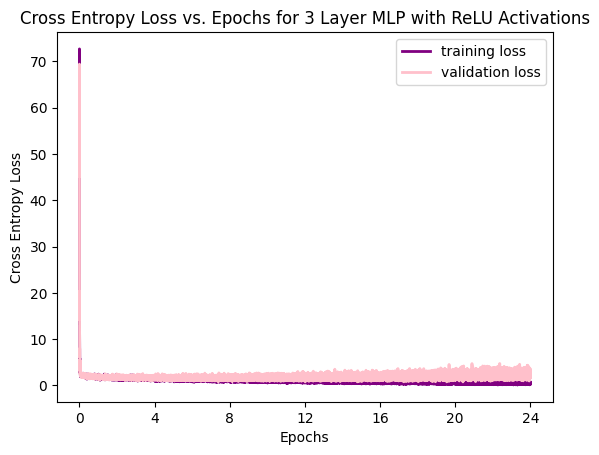

This is your training accuracy
0.8725111111111111


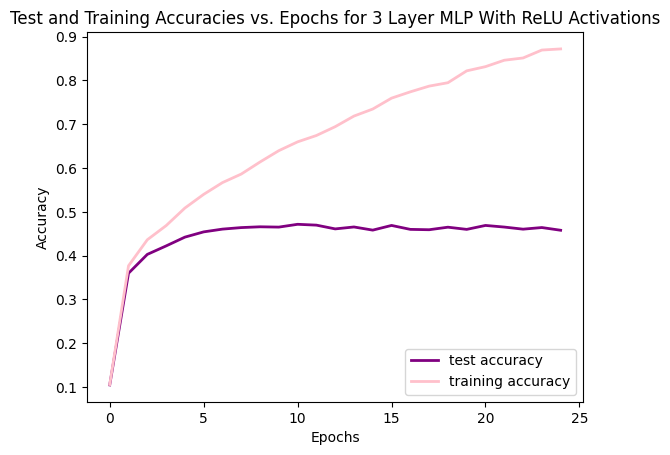

In [25]:
title1 = "Cross Entropy Loss vs. Epochs for 3 Layer MLP with ReLU Activations"
title2 = "Test and Training Accuracies vs. Epochs for 3 Layer MLP With ReLU Activations"
completeEval(trained3,x_train_z_normalized,x_test_z_normalized,title1,title2, color1='purple',color2='pink')



### 3.1.2 - 2 Hidden Layers

Train the model

In [29]:
mlptest2 = MLP (noHLayers=2, noHUnits=[256,256],x =x_train_z_normalized,y=y_train,activation='reLU')
optimizer = GradientDescentOptimizer(mlptest2,learningRate)
trained2 = mlptest2.fit(optimizer, x_train_z_normalized,x_val_z_normalized, y_train,y_val,x_test_z_normalized,y_test_raw,y_train_raw,iterations,bsize)




first hidden layer added
next layer added
output layer added


  0%|          | 16/33750 [00:01<34:42, 16.20it/s]  

 Epoch  0 | Train:  0.10206666666666667  | Test:  0.1026


  4%|▍         | 1435/33750 [00:12<12:46, 42.17it/s]

 Epoch  1 | Train:  0.35906666666666665  | Test:  0.3382


  8%|▊         | 2840/33750 [00:23<12:21, 41.68it/s]

 Epoch  2 | Train:  0.42115555555555556  | Test:  0.3799


 13%|█▎        | 4242/33750 [00:33<11:56, 41.21it/s]

 Epoch  3 | Train:  0.4563333333333333  | Test:  0.3965


 17%|█▋        | 5647/33750 [00:44<11:41, 40.08it/s]

 Epoch  4 | Train:  0.49444444444444446  | Test:  0.4254


 21%|██        | 7055/33750 [00:55<11:37, 38.28it/s]

 Epoch  5 | Train:  0.5163333333333333  | Test:  0.4234


 25%|██▌       | 8455/33750 [01:06<10:39, 39.55it/s]

 Epoch  6 | Train:  0.5418666666666667  | Test:  0.4312


 29%|██▉       | 9858/33750 [01:16<09:40, 41.18it/s]

 Epoch  7 | Train:  0.5619111111111111  | Test:  0.4388


 33%|███▎      | 11272/33750 [01:27<08:56, 41.87it/s]

 Epoch  8 | Train:  0.5855555555555556  | Test:  0.4476


 38%|███▊      | 12670/33750 [01:38<08:30, 41.30it/s]

 Epoch  9 | Train:  0.6043111111111111  | Test:  0.4491


 42%|████▏     | 14076/33750 [01:49<07:57, 41.21it/s]

 Epoch  10 | Train:  0.6287333333333334  | Test:  0.4595


 46%|████▌     | 15492/33750 [02:00<07:25, 40.95it/s]

 Epoch  11 | Train:  0.6379555555555556  | Test:  0.4518


 50%|█████     | 16897/33750 [02:10<07:06, 39.47it/s]

 Epoch  12 | Train:  0.6532222222222223  | Test:  0.4572


 54%|█████▍    | 18294/33750 [02:21<06:13, 41.38it/s]

 Epoch  13 | Train:  0.6681555555555555  | Test:  0.4651


 58%|█████▊    | 19710/33750 [02:32<05:31, 42.31it/s]

 Epoch  14 | Train:  0.6836444444444445  | Test:  0.4608


 63%|██████▎   | 21113/33750 [02:42<04:59, 42.23it/s]

 Epoch  15 | Train:  0.7031777777777778  | Test:  0.4624


 67%|██████▋   | 22524/33750 [02:54<04:27, 41.92it/s]

 Epoch  16 | Train:  0.7171555555555555  | Test:  0.4613


 71%|███████   | 23924/33750 [03:04<03:54, 41.91it/s]

 Epoch  17 | Train:  0.7354  | Test:  0.4612


 75%|███████▌  | 25324/33750 [03:15<03:25, 41.00it/s]

 Epoch  18 | Train:  0.7455111111111111  | Test:  0.4615


 79%|███████▉  | 26738/33750 [03:26<02:55, 39.95it/s]

 Epoch  19 | Train:  0.759  | Test:  0.4591


 83%|████████▎ | 28142/33750 [03:36<02:15, 41.29it/s]

 Epoch  20 | Train:  0.7710222222222223  | Test:  0.4653


 88%|████████▊ | 29550/33750 [03:47<01:49, 38.49it/s]

 Epoch  21 | Train:  0.7827555555555555  | Test:  0.4639


 92%|█████████▏| 30951/33750 [03:58<01:07, 41.42it/s]

 Epoch  22 | Train:  0.793  | Test:  0.4726


 96%|█████████▌| 32354/33750 [04:08<00:33, 41.51it/s]

 Epoch  23 | Train:  0.8028222222222222  | Test:  0.4693


100%|██████████| 33750/33750 [04:19<00:00, 130.02it/s]

 Epoch  24 | Train:  0.8160444444444445  | Test:  0.4596


Plot the accuracy

This is your test accuracy
0.4624


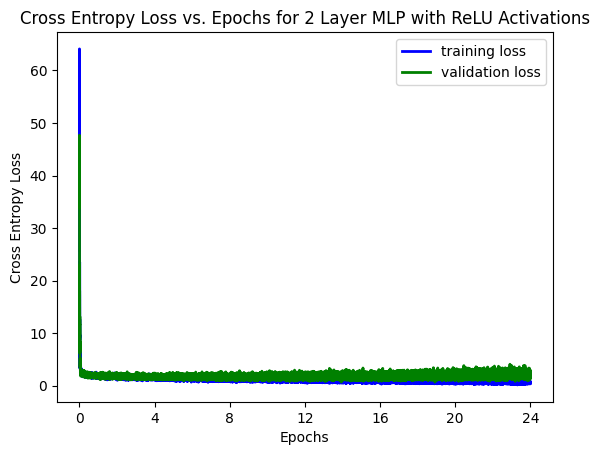

This is your training accuracy
0.8238222222222222


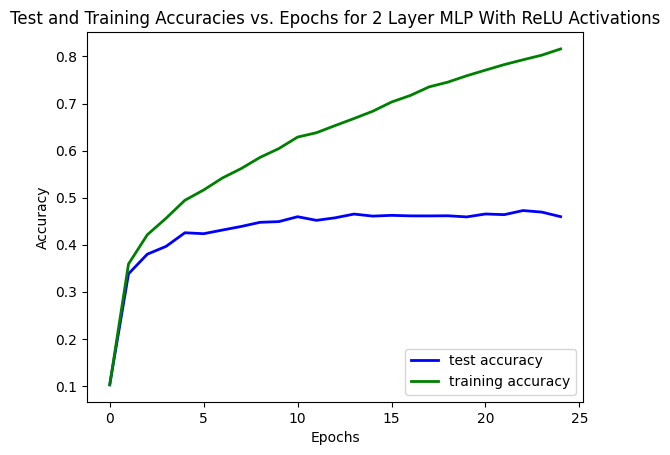

In [30]:
title1 = "Cross Entropy Loss vs. Epochs for 2 Layer MLP with ReLU Activations"
title2 = "Test and Training Accuracies vs. Epochs for 2 Layer MLP With ReLU Activations"
completeEval(trained2,x_train_z_normalized,x_test_z_normalized,title1,title2, color1='blue',color2='green')

### 3.1.3 - 1 Hidden Layers

Train the model

In [28]:
mlptest1 = MLP (noHLayers=1, noHUnits=[256],x =x_train_z_normalized,y=y_train,activation='reLU')
optimizer = GradientDescentOptimizer(mlptest1,learningRate)
trained1 = mlptest1.fit(optimizer, x_train_z_normalized,x_val_z_normalized, y_train,y_val,x_test_z_normalized,y_test_raw,y_train_raw,iterations,bsize)



first hidden layer added
output layer added


  0%|          | 16/33750 [00:01<30:57, 18.16it/s]  

 Epoch  0 | Train:  0.1184888888888889  | Test:  0.1127


  4%|▍         | 1435/33750 [00:10<10:38, 50.61it/s]

 Epoch  1 | Train:  0.44793333333333335  | Test:  0.3913


  8%|▊         | 2829/33750 [00:20<10:18, 49.99it/s]

 Epoch  2 | Train:  0.5343555555555556  | Test:  0.4291


 13%|█▎        | 4248/33750 [00:29<10:13, 48.11it/s]

 Epoch  3 | Train:  0.5571555555555555  | Test:  0.4484


 17%|█▋        | 5647/33750 [00:39<09:31, 49.14it/s]

 Epoch  4 | Train:  0.5990444444444445  | Test:  0.4663


 21%|██        | 7052/33750 [00:48<08:45, 50.82it/s]

 Epoch  5 | Train:  0.5869111111111112  | Test:  0.4603


 25%|██▌       | 8460/33750 [00:58<08:24, 50.12it/s]

 Epoch  6 | Train:  0.6234444444444445  | Test:  0.4663


 29%|██▉       | 9872/33750 [01:07<07:39, 51.97it/s]

 Epoch  7 | Train:  0.6537777777777778  | Test:  0.4835


 33%|███▎      | 11265/33750 [01:17<07:32, 49.70it/s]

 Epoch  8 | Train:  0.6630222222222222  | Test:  0.4816


 38%|███▊      | 12674/33750 [01:26<07:07, 49.26it/s]

 Epoch  9 | Train:  0.6624666666666666  | Test:  0.4792


 42%|████▏     | 14075/33750 [01:35<08:12, 39.98it/s] 

 Epoch  10 | Train:  0.6829777777777778  | Test:  0.4808


 46%|████▌     | 15483/33750 [01:45<05:59, 50.75it/s]

 Epoch  11 | Train:  0.7046444444444444  | Test:  0.4965


 50%|█████     | 16903/33750 [01:54<05:37, 49.86it/s]

 Epoch  12 | Train:  0.7002  | Test:  0.4779


 54%|█████▍    | 18295/33750 [02:04<06:43, 38.30it/s] 

 Epoch  13 | Train:  0.7172444444444445  | Test:  0.4776


 58%|█████▊    | 19705/33750 [02:13<04:44, 49.33it/s]

 Epoch  14 | Train:  0.7260222222222222  | Test:  0.4829


 63%|██████▎   | 21113/33750 [02:23<04:10, 50.42it/s]

 Epoch  15 | Train:  0.7322666666666666  | Test:  0.4797


 67%|██████▋   | 22522/33750 [02:32<03:37, 51.66it/s]

 Epoch  16 | Train:  0.7512444444444445  | Test:  0.4921


 71%|███████   | 23932/33750 [02:42<03:11, 51.37it/s]

 Epoch  17 | Train:  0.7376  | Test:  0.4882


 75%|███████▌  | 25325/33750 [02:51<02:49, 49.59it/s]

 Epoch  18 | Train:  0.7610666666666667  | Test:  0.4852


 79%|███████▉  | 26739/33750 [03:01<02:15, 51.61it/s]

 Epoch  19 | Train:  0.7768222222222222  | Test:  0.4822


 83%|████████▎ | 28137/33750 [03:10<01:51, 50.43it/s]

 Epoch  20 | Train:  0.7928888888888889  | Test:  0.4894


 88%|████████▊ | 29541/33750 [03:20<01:44, 40.09it/s] 

 Epoch  21 | Train:  0.7964444444444444  | Test:  0.4863


 92%|█████████▏| 30956/33750 [03:29<00:56, 49.35it/s]

 Epoch  22 | Train:  0.8057777777777778  | Test:  0.4874


 96%|█████████▌| 32354/33750 [03:38<00:28, 49.84it/s]

 Epoch  23 | Train:  0.7971333333333334  | Test:  0.4759


100%|██████████| 33750/33750 [03:48<00:00, 147.82it/s]

 Epoch  24 | Train:  0.8033111111111111  | Test:  0.4826


Plot the accuracy

This is your test accuracy
0.4728


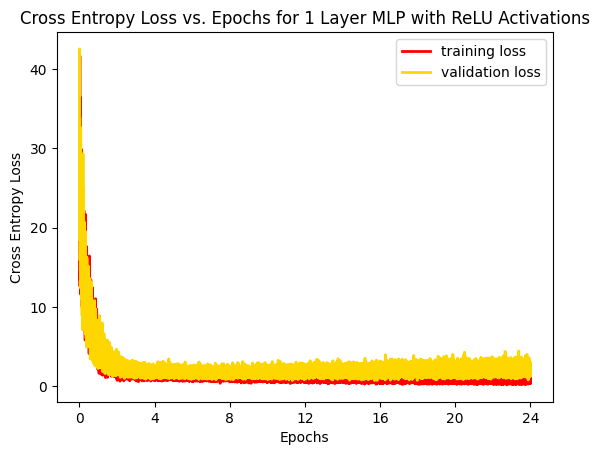

This is your training accuracy
0.7960222222222222


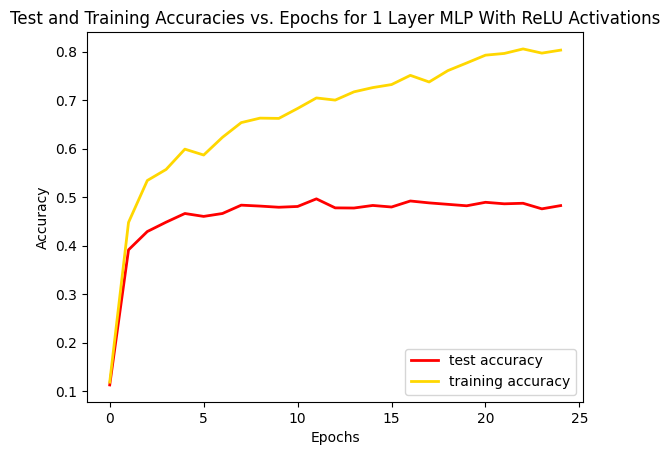

In [29]:
title1 = "Cross Entropy Loss vs. Epochs for 1 Layer MLP with ReLU Activations"
title2 = "Test and Training Accuracies vs. Epochs for 1 Layer MLP With ReLU Activations"
completeEval(trained1,x_train_z_normalized,x_test_z_normalized,title1,title2, color1='red',color2='gold')






### 3.1.4 - 0 Hidden Layers

Train the model

In [30]:
mlptest0 = MLP (noHLayers=0, noHUnits=[],x =x_train_z_normalized,y=y_train,activation='reLU')
optimizer = GradientDescentOptimizer(mlptest0,learningRate)
trained0 = mlptest0.fit(optimizer, x_train_z_normalized,x_val_z_normalized, y_train,y_val,x_test_z_normalized,y_test_raw,y_train_raw,iterations,bsize)



first and last layer added


  0%|          | 35/33750 [00:00<01:36, 348.83it/s]

 Epoch  0 | Train:  0.1422  | Test:  0.1435


  4%|▍         | 1485/33750 [00:03<01:18, 411.26it/s]

 Epoch  1 | Train:  0.2537333333333333  | Test:  0.2421


  9%|▊         | 2882/33750 [00:05<00:59, 517.71it/s]

 Epoch  2 | Train:  0.2767777777777778  | Test:  0.2637


 13%|█▎        | 4320/33750 [00:08<00:56, 516.37it/s]

 Epoch  3 | Train:  0.2966666666666667  | Test:  0.2736


 17%|█▋        | 5687/33750 [00:10<00:54, 513.29it/s]

 Epoch  4 | Train:  0.29333333333333333  | Test:  0.2686


 21%|██        | 7059/33750 [00:13<00:55, 479.54it/s]

 Epoch  5 | Train:  0.3073111111111111  | Test:  0.2769


 25%|██▌       | 8524/33750 [00:16<00:48, 518.00it/s]

 Epoch  6 | Train:  0.3090888888888889  | Test:  0.2845


 29%|██▉       | 9954/33750 [00:18<00:44, 535.80it/s]

 Epoch  7 | Train:  0.3104222222222222  | Test:  0.2794


 34%|███▎      | 11324/33750 [00:21<00:41, 541.05it/s]

 Epoch  8 | Train:  0.3218666666666667  | Test:  0.2876


 38%|███▊      | 12761/33750 [00:23<00:39, 532.91it/s]

 Epoch  9 | Train:  0.31193333333333334  | Test:  0.2836


 42%|████▏     | 14127/33750 [00:26<00:52, 374.16it/s]

 Epoch  10 | Train:  0.33137777777777777  | Test:  0.2986


 46%|████▌     | 15551/33750 [00:29<00:34, 523.46it/s]

 Epoch  11 | Train:  0.3144888888888889  | Test:  0.2857


 50%|█████     | 16983/33750 [00:31<00:31, 533.11it/s]

 Epoch  12 | Train:  0.34486666666666665  | Test:  0.3052


 54%|█████▍    | 18388/33750 [00:34<00:29, 520.09it/s]

 Epoch  13 | Train:  0.34082222222222225  | Test:  0.2992


 59%|█████▊    | 19758/33750 [00:36<00:27, 510.31it/s]

 Epoch  14 | Train:  0.34146666666666664  | Test:  0.3022


 63%|██████▎   | 21159/33750 [00:39<00:27, 452.36it/s]

 Epoch  15 | Train:  0.33595555555555556  | Test:  0.2977


 67%|██████▋   | 22576/33750 [00:42<00:21, 523.18it/s]

 Epoch  16 | Train:  0.34615555555555555  | Test:  0.3003


 71%|███████   | 23987/33750 [00:44<00:18, 527.37it/s]

 Epoch  17 | Train:  0.33866666666666667  | Test:  0.2884


 75%|███████▌  | 25391/33750 [00:47<00:15, 526.13it/s]

 Epoch  18 | Train:  0.3506666666666667  | Test:  0.3067


 79%|███████▉  | 26778/33750 [00:49<00:17, 404.94it/s]

 Epoch  19 | Train:  0.33926666666666666  | Test:  0.2926


 84%|████████▎ | 28191/33750 [00:53<00:10, 507.08it/s]

 Epoch  20 | Train:  0.3490666666666667  | Test:  0.3012


 88%|████████▊ | 29609/33750 [00:55<00:08, 506.36it/s]

 Epoch  21 | Train:  0.3448222222222222  | Test:  0.2968


 92%|█████████▏| 31040/33750 [00:58<00:05, 526.90it/s]

 Epoch  22 | Train:  0.34615555555555555  | Test:  0.2991


 96%|█████████▌| 32445/33750 [01:01<00:02, 512.69it/s]

 Epoch  23 | Train:  0.35484444444444446  | Test:  0.3003


100%|██████████| 33750/33750 [01:04<00:00, 526.15it/s]

 Epoch  24 | Train:  0.36186666666666667  | Test:  0.3113


Plot the accuracy

This is your test accuracy
0.3045


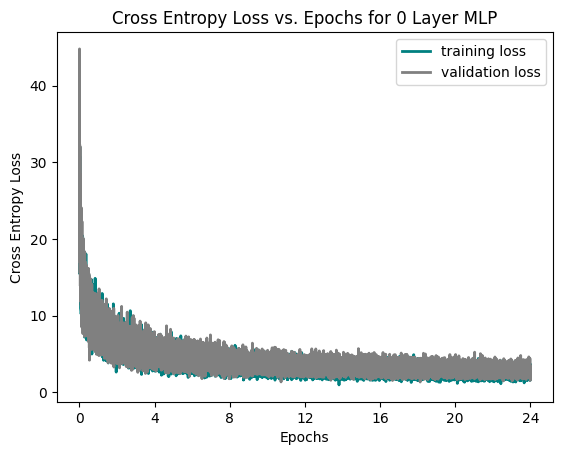

This is your training accuracy
0.35844444444444445


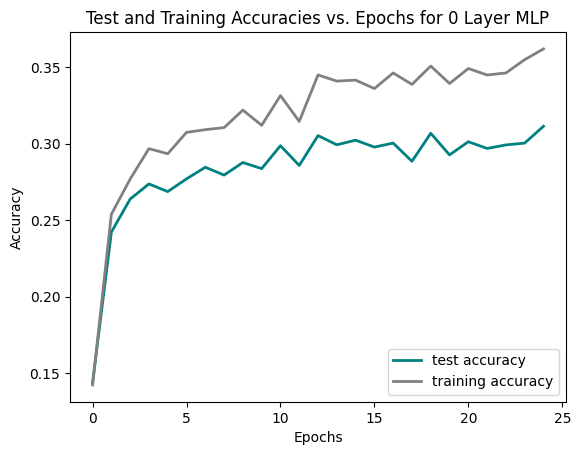

In [31]:
title1 = "Cross Entropy Loss vs. Epochs for 0 Layer MLP"
title2 = "Test and Training Accuracies vs. Epochs for 0 Layer MLP"
completeEval(trained0,x_train_z_normalized,x_test_z_normalized,title1,title2, color1='teal',color2='gray')


### 3.1.6 - EXTRA - Adam Gradient Descent on 1 Layer MLP
Train the model

In [32]:
mlptestadam1 = MLP (noHLayers=1, noHUnits=[256],x =x_train_z_normalized,y=y_train,activation='reLU')
optimizer = AdamDescentOptimizer(mlptestadam1,lradam,b1, b2, epsilon)
trainedadam1 = mlptestadam1.fit(optimizer, x_train_z_normalized,x_val_z_normalized, y_train,y_val,x_test_z_normalized,y_test_raw,y_train_raw,iterations,bsize)



first hidden layer added
output layer added


  0%|          | 0/33750 [00:00<?, ?it/s]

 Epoch  0 | Train:  0.0806  | Test:  0.0826


  4%|▍         | 1416/33750 [00:16<21:36, 24.95it/s] 

 Epoch  1 | Train:  0.4002222222222222  | Test:  0.3496


  8%|▊         | 2825/33750 [00:29<16:11, 31.82it/s]

 Epoch  2 | Train:  0.44137777777777776  | Test:  0.3658


 13%|█▎        | 4229/33750 [00:43<18:34, 26.49it/s] 

 Epoch  3 | Train:  0.49746666666666667  | Test:  0.396


 17%|█▋        | 5645/33750 [00:56<13:11, 35.51it/s]

 Epoch  4 | Train:  0.5204666666666666  | Test:  0.4063


 21%|██        | 7049/33750 [01:10<12:25, 35.80it/s]

 Epoch  5 | Train:  0.5480222222222222  | Test:  0.4091


 25%|██▌       | 8450/33750 [01:23<12:14, 34.44it/s]

 Epoch  6 | Train:  0.5550222222222222  | Test:  0.4101


 29%|██▉       | 9853/33750 [01:36<15:08, 26.31it/s] 

 Epoch  7 | Train:  0.5778  | Test:  0.4253


 33%|███▎      | 11268/33750 [01:50<11:49, 31.70it/s]

 Epoch  8 | Train:  0.6231333333333333  | Test:  0.4419


 38%|███▊      | 12672/33750 [02:03<10:12, 34.41it/s]

 Epoch  9 | Train:  0.6114666666666667  | Test:  0.4311


 42%|████▏     | 14076/33750 [02:17<09:25, 34.76it/s]

 Epoch  10 | Train:  0.6308  | Test:  0.4348


 46%|████▌     | 15479/33750 [02:30<08:51, 34.39it/s]

 Epoch  11 | Train:  0.669  | Test:  0.452


 50%|█████     | 16883/33750 [02:43<10:26, 26.91it/s] 

 Epoch  12 | Train:  0.6520444444444444  | Test:  0.4411


 54%|█████▍    | 18297/33750 [02:57<07:24, 34.78it/s]

 Epoch  13 | Train:  0.6845555555555556  | Test:  0.4501


 58%|█████▊    | 19701/33750 [03:10<06:43, 34.78it/s]

 Epoch  14 | Train:  0.6759777777777778  | Test:  0.45


 63%|██████▎   | 21105/33750 [03:24<06:06, 34.46it/s]

 Epoch  15 | Train:  0.6955777777777777  | Test:  0.4509


 67%|██████▋   | 22508/33750 [03:37<05:35, 33.46it/s]

 Epoch  16 | Train:  0.7387111111111111  | Test:  0.4654


 71%|███████   | 23912/33750 [03:51<06:12, 26.38it/s] 

 Epoch  17 | Train:  0.7274666666666667  | Test:  0.4583


 75%|███████▌  | 25328/33750 [04:04<04:01, 34.84it/s]

 Epoch  18 | Train:  0.7412888888888889  | Test:  0.4521


 79%|███████▉  | 26732/33750 [04:17<03:22, 34.68it/s]

 Epoch  19 | Train:  0.7258888888888889  | Test:  0.4448


 83%|████████▎ | 28136/33750 [04:31<02:42, 34.62it/s]

 Epoch  20 | Train:  0.7597777777777778  | Test:  0.4695


 88%|████████▊ | 29539/33750 [04:44<02:03, 34.09it/s]

 Epoch  21 | Train:  0.7494444444444445  | Test:  0.4621


 92%|█████████▏| 30943/33750 [04:58<01:44, 26.80it/s] 

 Epoch  22 | Train:  0.7623333333333333  | Test:  0.4733


 96%|█████████▌| 32359/33750 [05:11<00:39, 34.80it/s]

 Epoch  23 | Train:  0.7783555555555556  | Test:  0.4688


100%|██████████| 33750/33750 [05:24<00:00, 103.92it/s]

 Epoch  24 | Train:  0.8059777777777778  | Test:  0.481


Check the accuracy

This is your test accuracy
0.4707


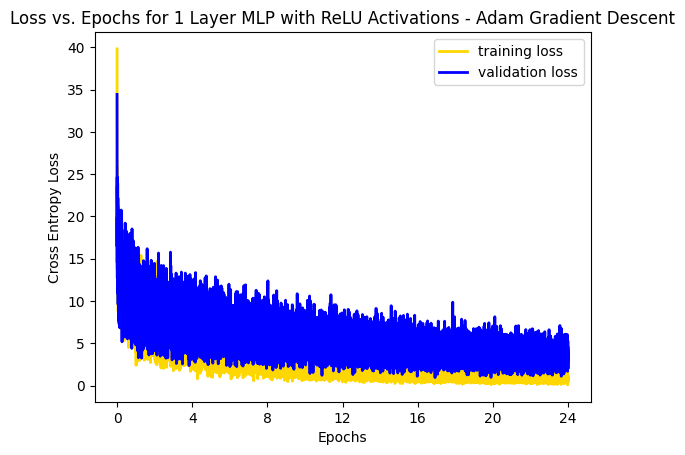

This is your training accuracy
0.7879777777777778


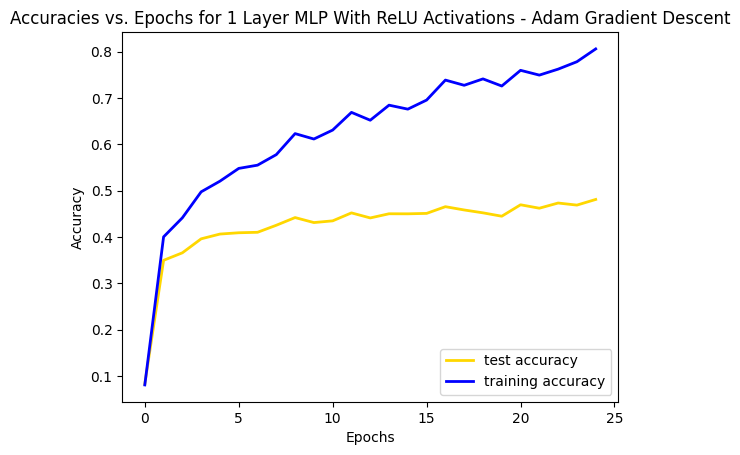

In [71]:
title1 = "Loss vs. Epochs for 1 Layer MLP with ReLU Activations - Adam Gradient Descent"
title2 = "Accuracies vs. Epochs for 1 Layer MLP With ReLU Activations - Adam Gradient Descent"
completeEval(trainedadam1,x_train_z_normalized,x_test_z_normalized,title1,title2, color1='gold',color2='blue',adam=True)

###3.1.7 - EXTRA - Adam Gradient Descent On 2 Layer MLP

Testing adam gradient descent on 2 layer MLP 

In [23]:

mlptestadam2 = MLP (noHLayers=2, noHUnits=[256,256],x =x_train_z_normalized,y=y_train,activation='reLU')
optimizer = AdamDescentOptimizer(mlptestadam2,lradam,b1, b2, epsilon)
trainedadam2 = mlptestadam2.fit(optimizer, x_train_z_normalized,x_val_z_normalized, y_train,y_val,x_test_z_normalized,y_test_raw,y_train_raw,iterationsAdam,bsize)

first hidden layer added
next layer added
output layer added


  0%|          | 0/33750 [00:00<?, ?it/s]

 Epoch  0 | Train:  0.10868888888888889  | Test:  0.1059


  4%|▍         | 1424/33750 [00:40<16:41, 32.29it/s]

 Epoch  1 | Train:  0.3089777777777778  | Test:  0.297


  8%|▊         | 2825/33750 [00:56<16:36, 31.02it/s]

 Epoch  2 | Train:  0.38666666666666666  | Test:  0.3599


 13%|█▎        | 4238/33750 [01:14<16:45, 29.35it/s]

 Epoch  3 | Train:  0.42744444444444446  | Test:  0.3851


 17%|█▋        | 5634/33750 [01:30<22:06, 21.19it/s] 

 Epoch  4 | Train:  0.4699333333333333  | Test:  0.4238


 21%|██        | 7041/33750 [01:45<16:06, 27.65it/s]

 Epoch  5 | Train:  0.4936  | Test:  0.4349


 25%|██▌       | 8450/33750 [02:01<15:11, 27.76it/s]

 Epoch  6 | Train:  0.5221333333333333  | Test:  0.446


 29%|██▉       | 9854/33750 [02:16<13:33, 29.37it/s]

 Epoch  7 | Train:  0.5421111111111111  | Test:  0.4571


 33%|███▎      | 11263/33750 [02:31<12:45, 29.37it/s]

 Epoch  8 | Train:  0.5569333333333333  | Test:  0.4625


 38%|███▊      | 12674/33750 [02:46<12:05, 29.04it/s]

 Epoch  9 | Train:  0.5684888888888889  | Test:  0.4622


 42%|████▏     | 14076/33750 [03:01<11:43, 27.95it/s]

 Epoch  10 | Train:  0.5862222222222222  | Test:  0.4688


 46%|████▌     | 15479/33750 [03:17<11:17, 26.98it/s]

 Epoch  11 | Train:  0.6007111111111111  | Test:  0.4744


 50%|█████     | 16883/33750 [03:37<12:37, 22.26it/s] 

 Epoch  12 | Train:  0.6202888888888889  | Test:  0.4697


 54%|█████▍    | 18295/33750 [03:57<08:58, 28.69it/s]

 Epoch  13 | Train:  0.6263777777777778  | Test:  0.4702


 58%|█████▊    | 19703/33750 [04:12<08:12, 28.55it/s]

 Epoch  14 | Train:  0.6366666666666667  | Test:  0.4675


 63%|██████▎   | 21100/33750 [04:27<09:32, 22.08it/s] 

 Epoch  15 | Train:  0.6610666666666667  | Test:  0.4822


 67%|██████▋   | 22511/33750 [04:42<07:03, 26.53it/s]

 Epoch  16 | Train:  0.6631777777777778  | Test:  0.4751


 71%|███████   | 23922/33750 [04:58<05:37, 29.13it/s]

 Epoch  17 | Train:  0.6786  | Test:  0.4723


 75%|███████▌  | 25318/33750 [05:13<06:20, 22.14it/s] 

 Epoch  18 | Train:  0.6882666666666667  | Test:  0.4759


 79%|███████▉  | 26726/33750 [05:28<04:08, 28.28it/s]

 Epoch  19 | Train:  0.6911111111111111  | Test:  0.4786


 83%|████████▎ | 28139/33750 [05:44<03:33, 26.34it/s]

 Epoch  20 | Train:  0.7103111111111111  | Test:  0.4835


 88%|████████▊ | 29546/33750 [05:59<02:26, 28.67it/s]

 Epoch  21 | Train:  0.7170222222222222  | Test:  0.4782


 92%|█████████▏| 30942/33750 [06:14<02:07, 22.09it/s] 

 Epoch  22 | Train:  0.7162  | Test:  0.4726


 96%|█████████▌| 32350/33750 [06:30<00:49, 28.35it/s]

 Epoch  23 | Train:  0.7298  | Test:  0.4762


100%|██████████| 33750/33750 [06:45<00:00, 83.29it/s]

 Epoch  24 | Train:  0.7517333333333334  | Test:  0.4812


Check accuracy

This is your test accuracy
0.4776


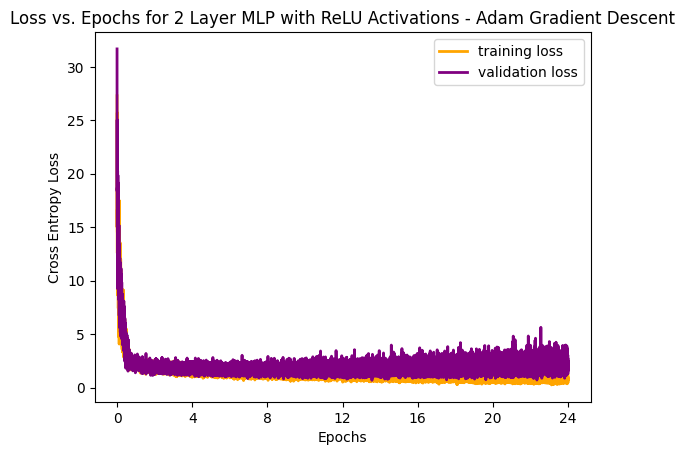

This is your training accuracy
0.7509111111111111


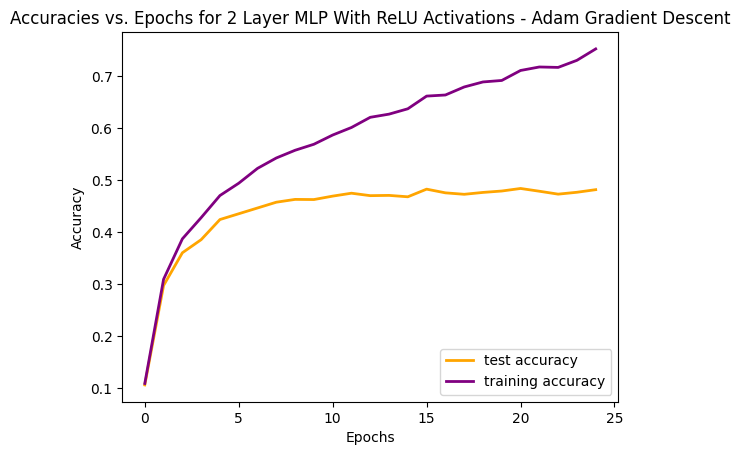

In [47]:
title1 = "Loss vs. Epochs for 2 Layer MLP with ReLU Activations - Adam Gradient Descent"
title2 = "Accuracies vs. Epochs for 2 Layer MLP With ReLU Activations - Adam Gradient Descent"
completeEval(trainedadam2,x_train_z_normalized,x_test_z_normalized,title1,title2, color1='orange',color2='purple')


### 3.1.8 - Summary Plot

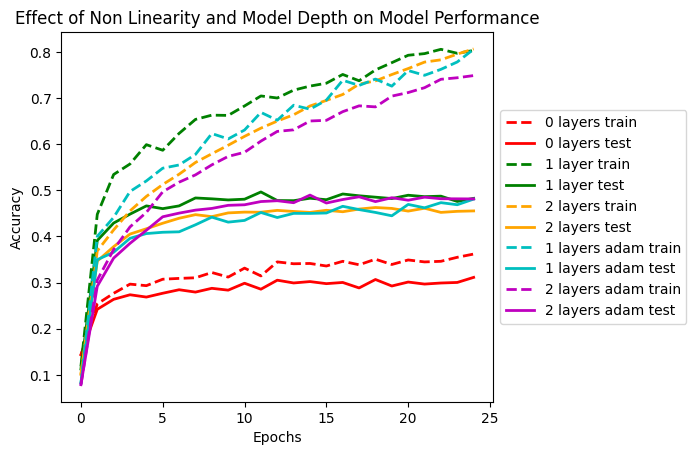

In [51]:
things = []
things.append([trained0, "0 layers train", "0 layers test","red"])
things.append([trained1, "1 layer train", "1 layer test","green"])
things.append([trained2, "2 layers train", "2 layers test","orange"])
things.append([trainedadam1, "1 layers adam train", "1 layers adam test","c"])
things.append([trainedadam2, "2 layers adam train", "2 layers adam test","m"])

completeEvalMany(things, "Effect of Non Linearity and Model Depth on Model Performance",x_train_z_normalized,x_test_z_normalized)

## 3.2 - Different Activation Functions

Comparing accuracies of MLP with 2 hidden layers when using the tanh and LeakyReLU activation functions

###3.2.1 -  Tanh Activation Function

Train the model

In [25]:
mlptest_tanh = MLP (noHLayers=2, noHUnits=[256,256], x=x_train_z_normalized, y=y_train,activation='tanh')
optimizer = GradientDescentOptimizer(mlptest_tanh, learningRate)
trained_tanh = mlptest_tanh.fit(optimizer, x_train_z_normalized,x_val_z_normalized, y_train,y_val,x_test_z_normalized,y_test_raw,y_train_raw,iterations,bsize)

first hidden layer added
next layer added
output layer added


  0%|          | 16/33750 [00:02<54:38, 10.29it/s]  

 Epoch  0 | Train:  0.09642222222222223  | Test:  0.0988


  4%|▍         | 1424/33750 [00:13<13:43, 39.23it/s]

 Epoch  1 | Train:  0.4076888888888889  | Test:  0.3599


  8%|▊         | 2830/33750 [00:24<13:28, 38.26it/s]

 Epoch  2 | Train:  0.4726  | Test:  0.3838


 13%|█▎        | 4236/33750 [00:35<12:51, 38.28it/s]

 Epoch  3 | Train:  0.4948888888888889  | Test:  0.3924


 17%|█▋        | 5646/33750 [00:46<12:16, 38.18it/s]

 Epoch  4 | Train:  0.56  | Test:  0.4131


 21%|██        | 7049/33750 [00:57<11:20, 39.24it/s]

 Epoch  5 | Train:  0.5824666666666667  | Test:  0.4132


 25%|██▌       | 8464/33750 [01:08<10:43, 39.30it/s]

 Epoch  6 | Train:  0.5971111111111111  | Test:  0.405


 29%|██▉       | 9858/33750 [01:19<10:06, 39.42it/s]

 Epoch  7 | Train:  0.6495555555555556  | Test:  0.4251


 33%|███▎      | 11277/33750 [01:30<09:30, 39.37it/s]

 Epoch  8 | Train:  0.6736222222222222  | Test:  0.4167


 38%|███▊      | 12670/33750 [01:41<08:58, 39.14it/s]

 Epoch  9 | Train:  0.6896  | Test:  0.4111


 42%|████▏     | 14079/33750 [01:52<08:23, 39.03it/s]

 Epoch  10 | Train:  0.7190222222222222  | Test:  0.4185


 46%|████▌     | 15484/33750 [02:03<07:50, 38.79it/s]

 Epoch  11 | Train:  0.7313777777777778  | Test:  0.4175


 50%|█████     | 16892/33750 [02:14<07:23, 37.99it/s]

 Epoch  12 | Train:  0.7481111111111111  | Test:  0.4163


 54%|█████▍    | 18303/33750 [02:25<06:38, 38.81it/s]

 Epoch  13 | Train:  0.7640666666666667  | Test:  0.418


 58%|█████▊    | 19704/33750 [02:36<06:09, 38.04it/s]

 Epoch  14 | Train:  0.7879777777777778  | Test:  0.4224


 63%|██████▎   | 21111/33750 [02:47<05:23, 39.05it/s]

 Epoch  15 | Train:  0.7994888888888889  | Test:  0.4189


 67%|██████▋   | 22517/33750 [02:58<04:47, 39.13it/s]

 Epoch  16 | Train:  0.8112444444444444  | Test:  0.4167


 71%|███████   | 23919/33750 [03:09<04:10, 39.17it/s]

 Epoch  17 | Train:  0.8322  | Test:  0.4241


 75%|███████▌  | 25326/33750 [03:20<03:36, 38.86it/s]

 Epoch  18 | Train:  0.8402666666666667  | Test:  0.4121


 79%|███████▉  | 26735/33750 [03:31<02:59, 39.11it/s]

 Epoch  19 | Train:  0.8548  | Test:  0.415


 83%|████████▎ | 28144/33750 [03:42<02:23, 38.95it/s]

 Epoch  20 | Train:  0.8494  | Test:  0.4047


 88%|████████▊ | 29553/33750 [03:54<01:58, 35.46it/s]

 Epoch  21 | Train:  0.8854666666666666  | Test:  0.4193


 92%|█████████▏| 30946/33750 [04:05<02:14, 20.87it/s]

 Epoch  22 | Train:  0.8899777777777778  | Test:  0.4168


 96%|█████████▌| 32356/33750 [04:16<00:35, 39.05it/s]

 Epoch  23 | Train:  0.8838  | Test:  0.4133


100%|██████████| 33750/33750 [04:27<00:00, 126.10it/s]

 Epoch  24 | Train:  0.9099555555555555  | Test:  0.4186


Check accuracy

This is your test accuracy
0.4197


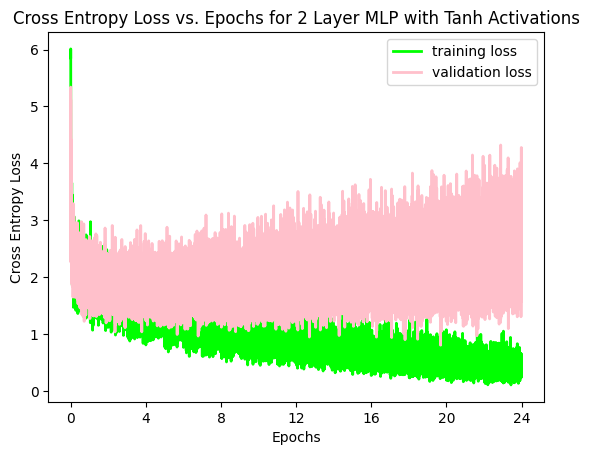

This is your training accuracy
0.9115111111111112


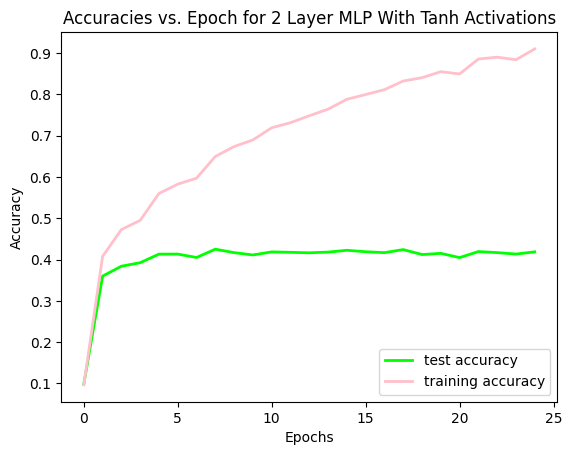

In [26]:
title1="Cross Entropy Loss vs. Epochs for 2 Layer MLP with Tanh Activations"
title2="Accuracies vs. Epoch for 2 Layer MLP With Tanh Activations"
completeEval(trained_tanh,x_train_z_normalized,x_test_z_normalized,title1,title2, color1='lime',color2='pink')



###3.2.2 LeakyReLU Activation Function

Train the model

In [27]:
gamma = 0.1

mlptest_leaky = MLP (noHLayers=2, noHUnits=[256,256], x=x_train_z_normalized, y=y_train, activation='leakyReLU', gamma=gamma)
optimizer = GradientDescentOptimizer(mlptest_leaky, learningRate)
trained_leaky = mlptest_leaky.fit(optimizer, x_train_z_normalized,x_val_z_normalized, y_train,y_val,x_test_z_normalized,y_test_raw,y_train_raw,iterations,bsize)

first hidden layer added
next layer added
output layer added


  0%|          | 16/33750 [00:01<35:28, 15.85it/s]  

 Epoch  0 | Train:  0.09968888888888888  | Test:  0.1021


  4%|▍         | 1421/33750 [00:12<17:58, 29.98it/s] 

 Epoch  1 | Train:  0.4434222222222222  | Test:  0.4175


  8%|▊         | 2825/33750 [00:23<13:59, 36.84it/s]

 Epoch  2 | Train:  0.47857777777777777  | Test:  0.427


 13%|█▎        | 4233/33750 [00:34<16:18, 30.18it/s] 

 Epoch  3 | Train:  0.4794  | Test:  0.4221


 17%|█▋        | 5649/33750 [00:45<11:42, 40.01it/s]

 Epoch  4 | Train:  0.5377333333333333  | Test:  0.4527


 21%|██        | 7051/33750 [00:55<11:09, 39.86it/s]

 Epoch  5 | Train:  0.5648444444444445  | Test:  0.4593


 25%|██▌       | 8455/33750 [01:06<10:28, 40.23it/s]

 Epoch  6 | Train:  0.5880666666666666  | Test:  0.4648


 29%|██▉       | 9870/33750 [01:17<09:56, 40.04it/s]

 Epoch  7 | Train:  0.6031333333333333  | Test:  0.4604


 33%|███▎      | 11272/33750 [01:28<09:21, 40.04it/s]

 Epoch  8 | Train:  0.6233777777777778  | Test:  0.4575


 38%|███▊      | 12672/33750 [01:39<08:54, 39.41it/s]

 Epoch  9 | Train:  0.6453777777777778  | Test:  0.4741


 42%|████▏     | 14078/33750 [01:50<08:21, 39.19it/s]

 Epoch  10 | Train:  0.6657111111111111  | Test:  0.4682


 46%|████▌     | 15480/33750 [02:01<09:55, 30.68it/s] 

 Epoch  11 | Train:  0.6647777777777778  | Test:  0.461


 50%|█████     | 16893/33750 [02:12<06:59, 40.14it/s]

 Epoch  12 | Train:  0.6887777777777778  | Test:  0.4682


 54%|█████▍    | 18306/33750 [02:23<06:27, 39.84it/s]

 Epoch  13 | Train:  0.7102888888888889  | Test:  0.4778


 58%|█████▊    | 19711/33750 [02:34<05:46, 40.49it/s]

 Epoch  14 | Train:  0.7344666666666667  | Test:  0.4731


 63%|██████▎   | 21118/33750 [02:45<05:18, 39.70it/s]

 Epoch  15 | Train:  0.7402  | Test:  0.4785


 67%|██████▋   | 22524/33750 [02:56<04:42, 39.70it/s]

 Epoch  16 | Train:  0.7412  | Test:  0.4725


 71%|███████   | 23919/33750 [03:07<04:08, 39.63it/s]

 Epoch  17 | Train:  0.7719777777777778  | Test:  0.4752


 75%|███████▌  | 25326/33750 [03:18<03:41, 38.08it/s]

 Epoch  18 | Train:  0.7868222222222222  | Test:  0.478


 79%|███████▉  | 26740/33750 [03:29<03:02, 38.32it/s]

 Epoch  19 | Train:  0.7836666666666666  | Test:  0.4784


 83%|████████▎ | 28135/33750 [03:40<03:06, 30.13it/s] 

 Epoch  20 | Train:  0.8131111111111111  | Test:  0.4791


 88%|████████▊ | 29544/33750 [03:51<01:45, 39.86it/s]

 Epoch  21 | Train:  0.8148444444444445  | Test:  0.4747


 92%|█████████▏| 30957/33750 [04:02<01:09, 40.03it/s]

 Epoch  22 | Train:  0.8331111111111111  | Test:  0.4815


 96%|█████████▌| 32356/33750 [04:13<00:34, 40.13it/s]

 Epoch  23 | Train:  0.8333333333333334  | Test:  0.4725


100%|██████████| 33750/33750 [04:24<00:00, 127.84it/s]

 Epoch  24 | Train:  0.8530888888888889  | Test:  0.4752


Check accuracy

This is your test accuracy
0.4809


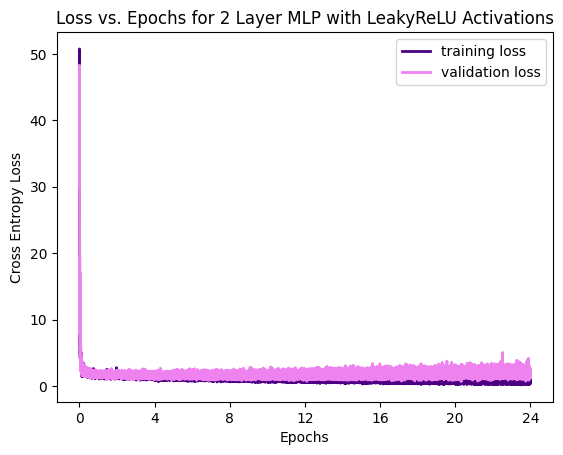

This is your training accuracy
0.8442222222222222


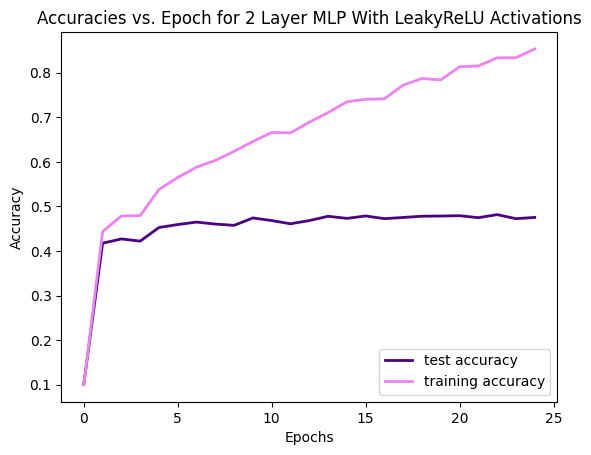

In [28]:
title1="Loss vs. Epochs for 2 Layer MLP with LeakyReLU Activations"
title2="Accuracies vs. Epoch for 2 Layer MLP With LeakyReLU Activations"
completeEval(trained_leaky,x_train_z_normalized,x_test_z_normalized,title1,title2, color1='indigo',color2='violet')


### 3.2.3 - Summary Plot

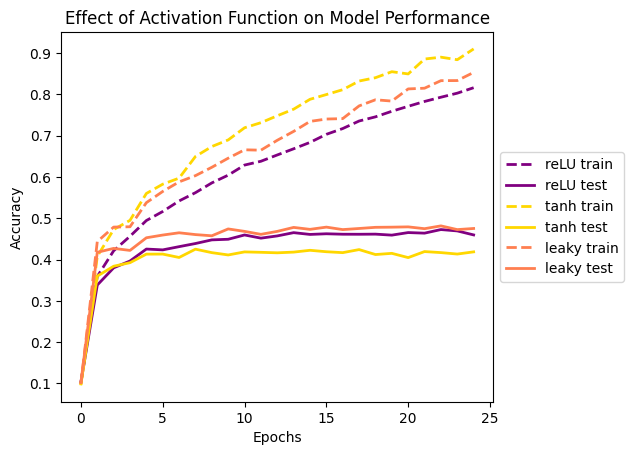

In [40]:
things = []
things.append([trained2, "reLU train", "reLU test","purple"])
things.append([trained_tanh, "tanh train", "tanh test","gold"])
things.append([trained_leaky, "leaky train", "leaky test","coral"])

completeEvalMany(things, "Effect of Activation Function on Model Performance",x_train_z_normalized,x_test_z_normalized)

## 3.3 - Regularization

###3.3.1 L1 Regularization

Not very effective, using larger lambda reduces both train and test accuracy significantly. With small lamba we get a +4% if we do early stopping compared to no L1. Completely prevents overfitting


Train the model

In [57]:
_lambda = 0.001

mlptest_l1 = MLP(noHLayers=2, noHUnits=[256, 256], x=x_train_z_normalized, y=y_train, activation='reLU')
optimizer = GradientDescentOptimizer(mlptest_l1, learningRate, regularization='L1', _lambda=_lambda)
trained_l1 = mlptest_l1.fit(optimizer, x_train_z_normalized,x_val_z_normalized, y_train,y_val,x_test_z_normalized,y_test_raw,y_train_raw,iterations,bsize)

first hidden layer added
next layer added
output layer added


  0%|          | 0/33750 [00:00<?, ?it/s]

 Epoch  0 | Train:  0.09144444444444444  | Test:  0.0882


  4%|▍         | 1420/33750 [00:12<13:57, 38.62it/s]

 Epoch  1 | Train:  0.3927555555555556  | Test:  0.3696


  8%|▊         | 2840/33750 [00:23<13:17, 38.75it/s]

 Epoch  2 | Train:  0.44584444444444443  | Test:  0.4059


 13%|█▎        | 4236/33750 [00:36<12:11, 40.36it/s]

 Epoch  3 | Train:  0.4776888888888889  | Test:  0.4406


 17%|█▋        | 5651/33750 [00:46<11:02, 42.39it/s]

 Epoch  4 | Train:  0.49422222222222223  | Test:  0.4521


 21%|██        | 7046/33750 [00:58<10:28, 42.51it/s]

 Epoch  5 | Train:  0.5070888888888889  | Test:  0.4691


 25%|██▌       | 8444/33750 [01:08<13:39, 30.86it/s] 

 Epoch  6 | Train:  0.4919777777777778  | Test:  0.4553


 29%|██▉       | 9857/33750 [01:20<11:55, 33.39it/s] 

 Epoch  7 | Train:  0.4814888888888889  | Test:  0.4612


 33%|███▎      | 11270/33750 [01:30<09:03, 41.36it/s]

 Epoch  8 | Train:  0.48462222222222223  | Test:  0.4588


 38%|███▊      | 12681/33750 [01:41<08:22, 41.91it/s]

 Epoch  9 | Train:  0.46297777777777777  | Test:  0.4388


 42%|████▏     | 14083/33750 [01:52<08:03, 40.65it/s]

 Epoch  10 | Train:  0.47517777777777775  | Test:  0.4584


 46%|████▌     | 15488/33750 [02:03<07:33, 40.28it/s]

 Epoch  11 | Train:  0.4566222222222222  | Test:  0.4498


 50%|█████     | 16901/33750 [02:14<06:44, 41.70it/s]

 Epoch  12 | Train:  0.4758  | Test:  0.4658


 54%|█████▍    | 18301/33750 [02:24<06:05, 42.24it/s]

 Epoch  13 | Train:  0.45811111111111114  | Test:  0.4491


 58%|█████▊    | 19701/33750 [02:35<05:37, 41.63it/s]

 Epoch  14 | Train:  0.4616222222222222  | Test:  0.4565


 63%|██████▎   | 21106/33750 [02:46<05:01, 41.98it/s]

 Epoch  15 | Train:  0.4653111111111111  | Test:  0.4549


 67%|██████▋   | 22520/33750 [02:57<04:28, 41.75it/s]

 Epoch  16 | Train:  0.47186666666666666  | Test:  0.4579


 71%|███████   | 23927/33750 [03:08<03:52, 42.27it/s]

 Epoch  17 | Train:  0.4754888888888889  | Test:  0.4599


 75%|███████▌  | 25323/33750 [03:18<04:30, 31.12it/s] 

 Epoch  18 | Train:  0.46928888888888887  | Test:  0.4515


 79%|███████▉  | 26730/33750 [03:29<02:54, 40.14it/s]

 Epoch  19 | Train:  0.4804  | Test:  0.4677


 83%|████████▎ | 28137/33750 [03:40<02:15, 41.39it/s]

 Epoch  20 | Train:  0.4606222222222222  | Test:  0.4445


 88%|████████▊ | 29544/33750 [03:51<01:41, 41.37it/s]

 Epoch  21 | Train:  0.4766666666666667  | Test:  0.4639


 92%|█████████▏| 30947/33750 [04:01<01:28, 31.56it/s] 

 Epoch  22 | Train:  0.4828  | Test:  0.4684


 96%|█████████▌| 32352/33750 [04:12<00:43, 31.96it/s] 

 Epoch  23 | Train:  0.4803777777777778  | Test:  0.4664


100%|██████████| 33750/33750 [04:23<00:00, 128.05it/s]

 Epoch  24 | Train:  0.48317777777777776  | Test:  0.4682


Check accuracy

This is your test accuracy
0.4646


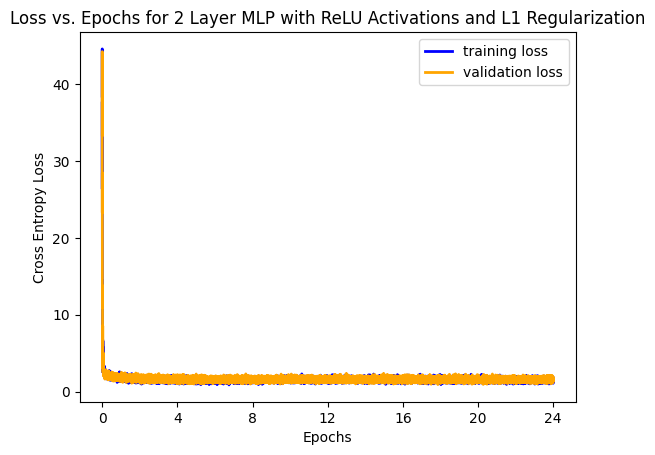

This is your training accuracy
0.4788


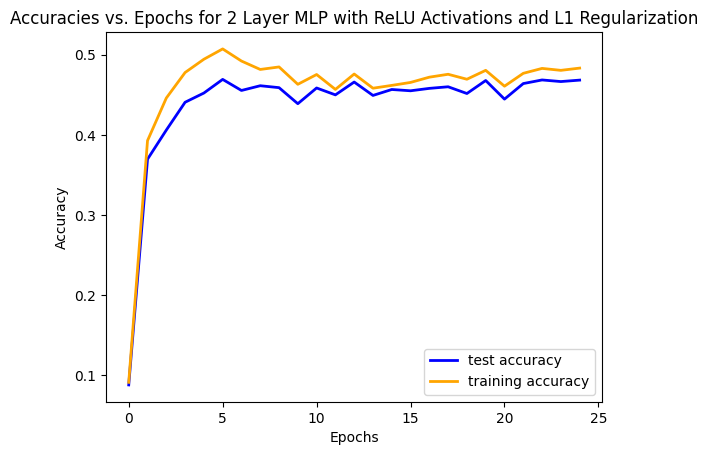

In [58]:
title1="Loss vs. Epochs for 2 Layer MLP with ReLU Activations and L1 Regularization"
title2= "Accuracies vs. Epochs for 2 Layer MLP with ReLU Activations and L1 Regularization"
completeEval(trained_l1,x_train_z_normalized,x_test_z_normalized,title1,title2, color1='blue',color2='orange')


###3.3.2 L2 Regularization



#### 3.3.2.1 - 2 Layer MLP

Much more effective, lambda values in the [0.01, 0.013] range increase test accuracy to over 50%. Overfitting completely prevented as well

Train the model

In [59]:
_lambda = 0.0125

mlptest_l2 = MLP(noHLayers=2, noHUnits=[256, 256], x=x_train_z_normalized, y=y_train, activation='reLU')
optimizer = GradientDescentOptimizer(mlptest_l2, learningRate, regularization='L2', _lambda=_lambda)
trained_l2 = mlptest_l2.fit(optimizer, x_train_z_normalized,x_val_z_normalized, y_train,y_val,x_test_z_normalized,y_test_raw,y_train_raw,iterations,bsize)

first hidden layer added
next layer added
output layer added


  0%|          | 16/33750 [00:01<32:08, 17.49it/s]  

 Epoch  0 | Train:  0.09633333333333334  | Test:  0.0936


  4%|▍         | 1433/33750 [00:12<12:35, 42.80it/s]

 Epoch  1 | Train:  0.3957333333333333  | Test:  0.3756


  8%|▊         | 2828/33750 [00:23<12:02, 42.79it/s]

 Epoch  2 | Train:  0.46111111111111114  | Test:  0.4246


 13%|█▎        | 4234/33750 [00:33<11:30, 42.72it/s]

 Epoch  3 | Train:  0.5031555555555556  | Test:  0.462


 17%|█▋        | 5639/33750 [00:44<15:03, 31.11it/s] 

 Epoch  4 | Train:  0.535  | Test:  0.4782


 21%|██        | 7058/33750 [00:55<10:44, 41.40it/s]

 Epoch  5 | Train:  0.5424  | Test:  0.4896


 25%|██▌       | 8459/33750 [01:05<10:05, 41.74it/s]

 Epoch  6 | Train:  0.5554444444444444  | Test:  0.4956


 29%|██▉       | 9863/33750 [01:16<09:14, 43.11it/s]

 Epoch  7 | Train:  0.5605777777777777  | Test:  0.5047


 33%|███▎      | 11275/33750 [01:27<08:47, 42.64it/s]

 Epoch  8 | Train:  0.5625111111111111  | Test:  0.5017


 38%|███▊      | 12676/33750 [01:38<08:13, 42.69it/s]

 Epoch  9 | Train:  0.5777333333333333  | Test:  0.5153


 42%|████▏     | 14081/33750 [01:48<07:48, 41.97it/s]

 Epoch  10 | Train:  0.5911555555555555  | Test:  0.5243


 46%|████▌     | 15490/33750 [01:59<06:58, 43.63it/s]

 Epoch  11 | Train:  0.5885333333333334  | Test:  0.5225


 50%|█████     | 16897/33750 [02:10<06:36, 42.50it/s]

 Epoch  12 | Train:  0.5933777777777778  | Test:  0.5224


 54%|█████▍    | 18306/33750 [02:20<06:09, 41.84it/s]

 Epoch  13 | Train:  0.5825333333333333  | Test:  0.5103


 58%|█████▊    | 19704/33750 [02:31<05:28, 42.72it/s]

 Epoch  14 | Train:  0.5998222222222223  | Test:  0.527


 63%|██████▎   | 21112/33750 [02:42<05:13, 40.29it/s]

 Epoch  15 | Train:  0.6090888888888889  | Test:  0.5334


 67%|██████▋   | 22513/33750 [02:52<04:20, 43.11it/s]

 Epoch  16 | Train:  0.6070888888888889  | Test:  0.5308


 71%|███████   | 23919/33750 [03:03<03:48, 43.00it/s]

 Epoch  17 | Train:  0.6080222222222222  | Test:  0.5319


 75%|███████▌  | 25336/33750 [03:14<03:12, 43.80it/s]

 Epoch  18 | Train:  0.6085555555555555  | Test:  0.5258


 79%|███████▉  | 26741/33750 [03:25<02:41, 43.50it/s]

 Epoch  19 | Train:  0.6102  | Test:  0.529


 83%|████████▎ | 28149/33750 [03:35<02:08, 43.56it/s]

 Epoch  20 | Train:  0.6077111111111111  | Test:  0.5243


 88%|████████▊ | 29547/33750 [03:46<01:39, 42.05it/s]

 Epoch  21 | Train:  0.6226666666666667  | Test:  0.5405


 92%|█████████▏| 30960/33750 [03:57<01:05, 42.77it/s]

 Epoch  22 | Train:  0.6213777777777778  | Test:  0.5302


 96%|█████████▌| 32367/33750 [04:07<00:31, 43.61it/s]

 Epoch  23 | Train:  0.6075111111111111  | Test:  0.5231


100%|██████████| 33750/33750 [04:18<00:00, 130.73it/s]

 Epoch  24 | Train:  0.6168888888888889  | Test:  0.5318


Check accuracy

This is your test accuracy
0.5262


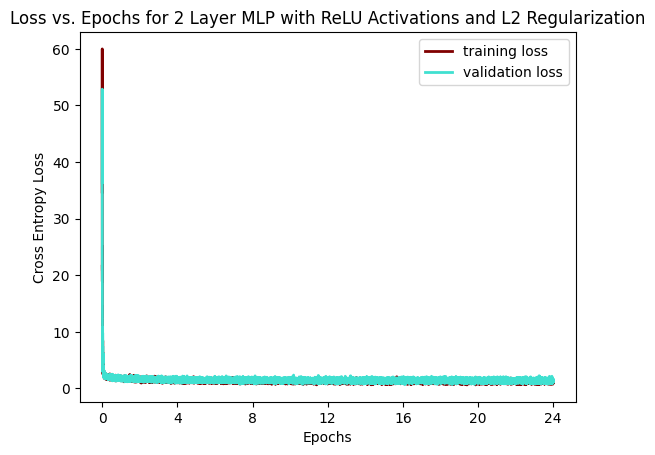

This is your training accuracy
0.6072222222222222


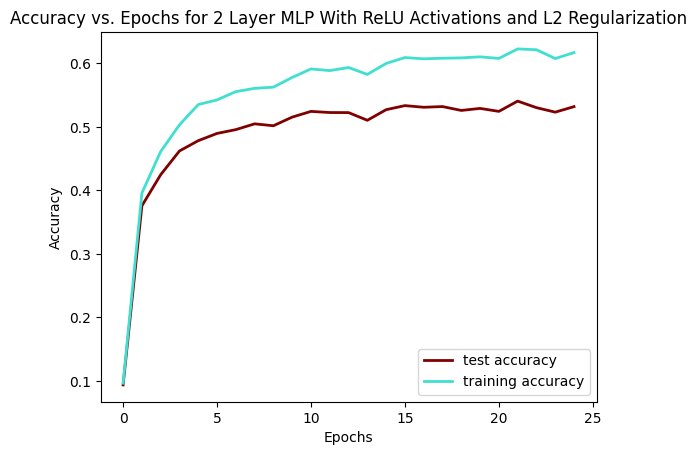

In [60]:
title1="Loss vs. Epochs for 2 Layer MLP with ReLU Activations and L2 Regularization"
title2= "Accuracy vs. Epochs for 2 Layer MLP With ReLU Activations and L2 Regularization"
completeEval(trained_l2,x_train_z_normalized,x_test_z_normalized,title1,title2, color1='maroon',color2='turquoise')


#### 3.3.2.2 - 1 Layer MLP 

In [61]:
_lambda = 0.0125

mlptest_l21 = MLP(noHLayers=1, noHUnits=[256], x=x_train_z_normalized, y=y_train, activation='reLU')
optimizer = GradientDescentOptimizer(mlptest_l21, learningRate, regularization='L2', _lambda=_lambda)
trained_l21 = mlptest_l21.fit(optimizer, x_train_z_normalized,x_val_z_normalized, y_train,y_val,x_test_z_normalized,y_test_raw,y_train_raw,iterations,bsize)

first hidden layer added
output layer added


  0%|          | 17/33750 [00:01<29:13, 19.23it/s]  

 Epoch  0 | Train:  0.09886666666666667  | Test:  0.0945


  4%|▍         | 1424/33750 [00:10<11:03, 48.75it/s]

 Epoch  1 | Train:  0.4369111111111111  | Test:  0.3856


  8%|▊         | 2834/33750 [00:20<10:29, 49.13it/s]

 Epoch  2 | Train:  0.545  | Test:  0.4531


 13%|█▎        | 4245/33750 [00:30<09:58, 49.27it/s]

 Epoch  3 | Train:  0.5855333333333334  | Test:  0.4847


 17%|█▋        | 5639/33750 [00:39<12:34, 37.24it/s] 

 Epoch  4 | Train:  0.5948888888888889  | Test:  0.4975


 21%|██        | 7049/33750 [00:49<09:12, 48.29it/s]

 Epoch  5 | Train:  0.5770666666666666  | Test:  0.4886


 25%|██▌       | 8454/33750 [00:59<08:40, 48.63it/s]

 Epoch  6 | Train:  0.6024222222222222  | Test:  0.5055


 29%|██▉       | 9862/33750 [01:08<08:14, 48.27it/s]

 Epoch  7 | Train:  0.5965333333333334  | Test:  0.5008


 33%|███▎      | 11278/33750 [01:19<07:40, 48.83it/s]

 Epoch  8 | Train:  0.6060444444444445  | Test:  0.5186


 38%|███▊      | 12686/33750 [01:28<07:18, 48.00it/s]

 Epoch  9 | Train:  0.5982888888888889  | Test:  0.5105


 42%|████▏     | 14079/33750 [01:38<06:44, 48.64it/s]

 Epoch  10 | Train:  0.6138888888888889  | Test:  0.5213


 46%|████▌     | 15482/33750 [01:47<08:01, 37.92it/s] 

 Epoch  11 | Train:  0.6053777777777778  | Test:  0.5185


 50%|█████     | 16901/33750 [01:57<05:40, 49.49it/s]

 Epoch  12 | Train:  0.6168666666666667  | Test:  0.529


 54%|█████▍    | 18308/33750 [02:07<05:13, 49.29it/s]

 Epoch  13 | Train:  0.6160888888888889  | Test:  0.5252


 58%|█████▊    | 19699/33750 [02:17<05:02, 46.39it/s]

 Epoch  14 | Train:  0.6119777777777777  | Test:  0.5123


 63%|██████▎   | 21108/33750 [02:26<04:20, 48.58it/s]

 Epoch  15 | Train:  0.6152  | Test:  0.5153


 67%|██████▋   | 22514/33750 [02:36<03:51, 48.62it/s]

 Epoch  16 | Train:  0.6216444444444444  | Test:  0.525


 71%|███████   | 23919/33750 [02:46<03:22, 48.54it/s]

 Epoch  17 | Train:  0.6218888888888889  | Test:  0.5267


 75%|███████▌  | 25325/33750 [02:55<02:52, 48.79it/s]

 Epoch  18 | Train:  0.6177777777777778  | Test:  0.5271


 79%|███████▉  | 26735/33750 [03:05<02:27, 47.67it/s]

 Epoch  19 | Train:  0.6186  | Test:  0.5215


 83%|████████▎ | 28143/33750 [03:15<01:54, 49.10it/s]

 Epoch  20 | Train:  0.627  | Test:  0.526


 88%|████████▊ | 29544/33750 [03:24<01:26, 48.42it/s]

 Epoch  21 | Train:  0.6249777777777777  | Test:  0.5246


 92%|█████████▏| 30948/33750 [03:34<01:14, 37.84it/s] 

 Epoch  22 | Train:  0.6264666666666666  | Test:  0.5268


 96%|█████████▌| 32363/33750 [03:46<00:31, 43.83it/s]

 Epoch  23 | Train:  0.6218  | Test:  0.5259


100%|██████████| 33750/33750 [03:56<00:00, 142.89it/s]

 Epoch  24 | Train:  0.6247555555555555  | Test:  0.524


This is your test accuracy
0.5214


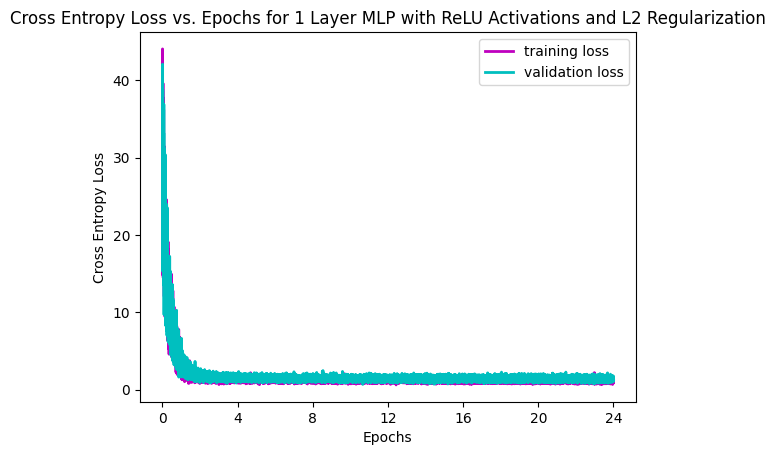

This is your training accuracy
0.6209111111111111


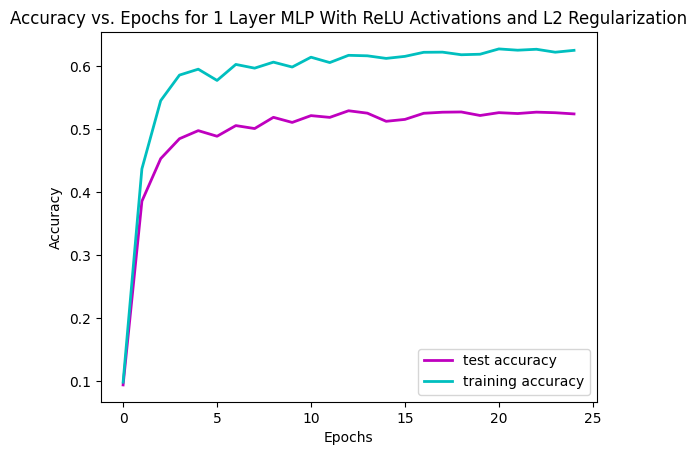

In [62]:
title1="Cross Entropy Loss vs. Epochs for 1 Layer MLP with ReLU Activations and L2 Regularization"
title2= "Accuracy vs. Epochs for 1 Layer MLP With ReLU Activations and L2 Regularization"
completeEval(trained_l21,x_train_z_normalized,x_test_z_normalized,title1,title2, color1='m',color2='c')

#### 3.3.2.3 - 3 Layer MLP 




In [ ]:
_lambda = 0.0125

mlptest_l23 = MLP(noHLayers=2, noHUnits=[256, 256, 256], x=x_train_z_normalized, y=y_train, activation='reLU')
optimizer = GradientDescentOptimizer(mlptest_l23, learningRate, regularization='L2', _lambda=_lambda)
trained_l23 = mlptest_l23.fit(optimizer, x_train_z_normalized,x_val_z_normalized, y_train,y_val,x_test_z_normalized,y_test_raw,y_train_raw,iterations,bsize)

first hidden layer added
next layer added
output layer added


  0%|          | 16/33750 [00:01<33:08, 16.96it/s]  

 Epoch  0 | Train:  0.11333333333333333  | Test:  0.1112


  4%|▍         | 1424/33750 [00:12<13:21, 40.33it/s]

 Epoch  1 | Train:  0.4086222222222222  | Test:  0.3885


  8%|▊         | 2828/33750 [00:23<12:44, 40.46it/s]

 Epoch  2 | Train:  0.4781111111111111  | Test:  0.4396


 13%|█▎        | 4246/33750 [00:33<12:09, 40.47it/s]

 Epoch  3 | Train:  0.5118666666666667  | Test:  0.4731


 17%|█▋        | 5648/33750 [00:44<11:55, 39.28it/s]

 Epoch  4 | Train:  0.5346888888888889  | Test:  0.4843


 21%|██        | 7046/33750 [00:55<11:22, 39.12it/s]

 Epoch  5 | Train:  0.5493555555555556  | Test:  0.4957


 25%|██▌       | 8457/33750 [01:06<10:25, 40.46it/s]

 Epoch  6 | Train:  0.5588222222222222  | Test:  0.5083


 29%|██▉       | 9870/33750 [01:17<09:51, 40.40it/s]

 Epoch  7 | Train:  0.5667555555555556  | Test:  0.513


 33%|███▎      | 11268/33750 [01:28<09:15, 40.47it/s]

 Epoch  8 | Train:  0.5785333333333333  | Test:  0.5205


 38%|███▊      | 12680/33750 [01:39<08:36, 40.76it/s]

 Epoch  9 | Train:  0.5731777777777778  | Test:  0.51


 42%|████▏     | 14074/33750 [01:49<10:33, 31.05it/s] 

 Epoch  10 | Train:  0.5827777777777777  | Test:  0.5127


 46%|████▌     | 15487/33750 [02:00<07:23, 41.19it/s]

 Epoch  11 | Train:  0.5763555555555555  | Test:  0.5113


 50%|█████     | 16887/33750 [02:11<09:11, 30.59it/s] 

 Epoch  12 | Train:  0.5961555555555555  | Test:  0.5286


 54%|█████▍    | 18300/33750 [02:22<06:20, 40.63it/s]

 Epoch  13 | Train:  0.5953555555555555  | Test:  0.529


 58%|█████▊    | 19704/33750 [02:33<05:39, 41.39it/s]

 Epoch  14 | Train:  0.5907555555555556  | Test:  0.5215


 63%|██████▎   | 21109/33750 [02:44<05:11, 40.63it/s]

 Epoch  15 | Train:  0.6074888888888889  | Test:  0.5345


 67%|██████▋   | 22510/33750 [02:54<05:58, 31.35it/s] 

 Epoch  16 | Train:  0.5968444444444444  | Test:  0.5201


 71%|███████   | 23919/33750 [03:05<04:02, 40.52it/s]

 Epoch  17 | Train:  0.6082222222222222  | Test:  0.5326


 75%|███████▌  | 25333/33750 [03:16<03:22, 41.55it/s]

 Epoch  18 | Train:  0.6058666666666667  | Test:  0.5262


 79%|███████▉  | 26736/33750 [03:27<02:53, 40.40it/s]

 Epoch  19 | Train:  0.5935777777777778  | Test:  0.5211


 83%|████████▎ | 28141/33750 [03:38<02:24, 38.80it/s]

 Epoch  20 | Train:  0.6046444444444444  | Test:  0.5263


 88%|████████▊ | 29543/33750 [03:48<01:43, 40.77it/s]

 Epoch  21 | Train:  0.6156888888888888  | Test:  0.5323


 92%|█████████▏| 30954/33750 [03:59<01:07, 41.30it/s]

 Epoch  22 | Train:  0.6220888888888889  | Test:  0.5327


 96%|█████████▌| 32360/33750 [04:10<00:33, 41.30it/s]

 Epoch  23 | Train:  0.6184666666666667  | Test:  0.5331


100%|██████████| 33750/33750 [04:21<00:00, 129.11it/s]

 Epoch  24 | Train:  0.6207111111111111  | Test:  0.527


This is your test accuracy
0.5319


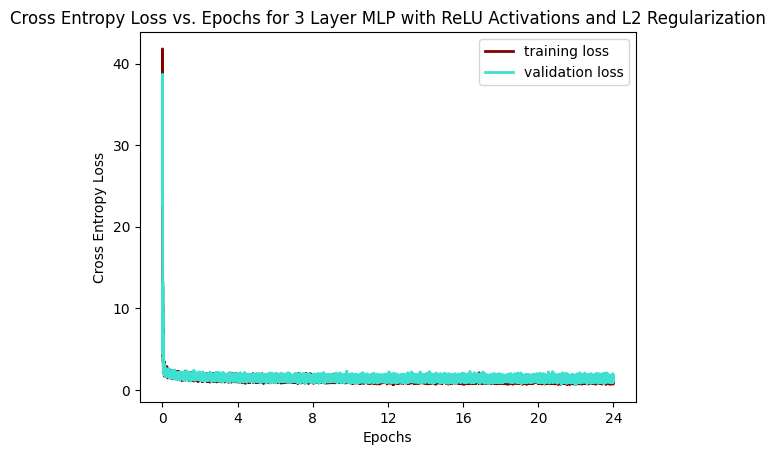

This is your training accuracy
0.6177111111111111


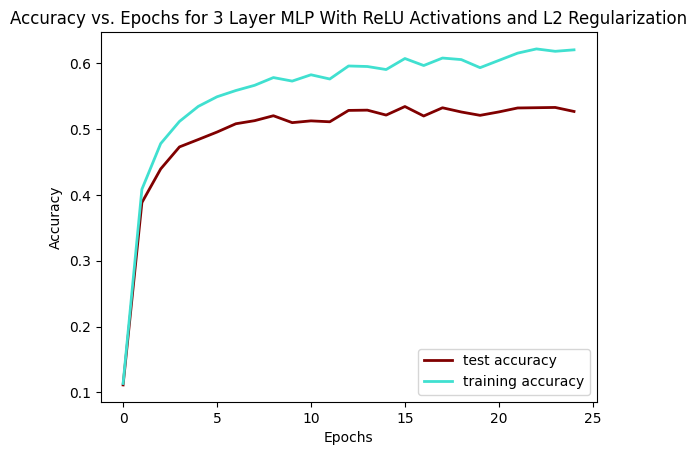

In [ ]:
title1="Cross Entropy Loss vs. Epochs for 3 Layer MLP with ReLU Activations and L2 Regularization"
title2= "Accuracy vs. Epochs for 3 Layer MLP With ReLU Activations and L2 Regularization"
completeEval(trained_l23,x_train_z_normalized,x_test_z_normalized,title1,title2, color1='maroon',color2='turquoise')

#### 3.3.2.4 - 7 Layer MLP 

To see if a many layer MLP with regularization can do better. Clearly need better lambda value, no time to investigate :) 


In [ ]:
_lambda = 0.000125
mlptest7 = MLP(noHLayers=7, noHUnits=[1024,512,256,128,128,64,32],x =x_train_z_normalized,y=y_train,activation='reLU')
optimizer = GradientDescentOptimizer(mlptest7,learningRate,regularization='L2', _lambda=_lambda)
trained7 = mlptest7.fit(optimizer, x_train_z_normalized,x_val_z_normalized, y_train,y_val,x_test_z_normalized,y_test_raw,y_train_raw,iterations,bsize)

first hidden layer added
next layer added
next layer added
next layer added
next layer added
next layer added
next layer added
output layer added


  0%|          | 5/33750 [00:06<8:29:13,  1.10it/s] 

 Epoch  0 | Train:  0.09728888888888888  | Test:  0.0981


  4%|▍         | 1409/33750 [00:55<4:13:45,  2.12it/s]

 Epoch  1 | Train:  0.36806666666666665  | Test:  0.3501


  8%|▊         | 2817/33750 [01:45<2:55:48,  2.93it/s]

 Epoch  2 | Train:  0.4315333333333333  | Test:  0.4025


 13%|█▎        | 4221/33750 [02:34<3:52:04,  2.12it/s]

 Epoch  3 | Train:  0.4799777777777778  | Test:  0.4307


 17%|█▋        | 5629/33750 [03:24<2:38:35,  2.96it/s]

 Epoch  4 | Train:  0.5236888888888889  | Test:  0.4511


 21%|██        | 7033/33750 [04:14<3:30:40,  2.11it/s]

 Epoch  5 | Train:  0.5612  | Test:  0.4618


 25%|██▌       | 8441/33750 [05:03<2:23:27,  2.94it/s]

 Epoch  6 | Train:  0.5819111111111112  | Test:  0.4554


 29%|██▉       | 9845/33750 [05:53<3:07:28,  2.13it/s]

 Epoch  7 | Train:  0.6082444444444445  | Test:  0.4628


 33%|███▎      | 11253/33750 [06:43<2:07:43,  2.94it/s]

 Epoch  8 | Train:  0.6436444444444445  | Test:  0.4764


 38%|███▊      | 12657/33750 [07:32<2:45:33,  2.12it/s]

 Epoch  9 | Train:  0.6688666666666667  | Test:  0.4802


 42%|████▏     | 14065/33750 [08:22<1:51:17,  2.95it/s]

 Epoch  10 | Train:  0.6776444444444445  | Test:  0.4749


 46%|████▌     | 15469/33750 [09:11<2:23:57,  2.12it/s]

 Epoch  11 | Train:  0.71  | Test:  0.485


 50%|█████     | 16877/33750 [10:01<1:35:30,  2.94it/s]

 Epoch  12 | Train:  0.7290444444444445  | Test:  0.4863


 54%|█████▍    | 18281/33750 [10:51<2:01:43,  2.12it/s]

 Epoch  13 | Train:  0.7562444444444445  | Test:  0.488


 58%|█████▊    | 19689/33750 [11:40<1:19:41,  2.94it/s]

 Epoch  14 | Train:  0.7653777777777778  | Test:  0.4871


 62%|██████▏   | 21093/33750 [12:30<1:39:30,  2.12it/s]

 Epoch  15 | Train:  0.7644888888888889  | Test:  0.4837


 67%|██████▋   | 22501/33750 [13:19<1:03:35,  2.95it/s]

 Epoch  16 | Train:  0.7978  | Test:  0.4918


 71%|███████   | 23905/33750 [14:09<1:17:31,  2.12it/s]

 Epoch  17 | Train:  0.8023555555555556  | Test:  0.4834


 75%|███████▌  | 25313/33750 [14:59<47:43,  2.95it/s]  

 Epoch  18 | Train:  0.8135555555555556  | Test:  0.4837


 79%|███████▉  | 26717/33750 [15:48<55:18,  2.12it/s]

 Epoch  19 | Train:  0.8249777777777778  | Test:  0.4927


 83%|████████▎ | 28125/33750 [16:38<31:48,  2.95it/s]

 Epoch  20 | Train:  0.8362444444444445  | Test:  0.4912


 87%|████████▋ | 29529/33750 [17:28<33:10,  2.12it/s]

 Epoch  21 | Train:  0.8446  | Test:  0.4937


 92%|█████████▏| 30937/33750 [18:17<15:56,  2.94it/s]

 Epoch  22 | Train:  0.8665777777777778  | Test:  0.4955


 96%|█████████▌| 32341/33750 [19:07<11:06,  2.11it/s]

 Epoch  23 | Train:  0.8662888888888889  | Test:  0.488


100%|██████████| 33750/33750 [19:57<00:00, 28.19it/s]

 Epoch  24 | Train:  0.8679777777777777  | Test:  0.4897


This is your test accuracy
0.4971


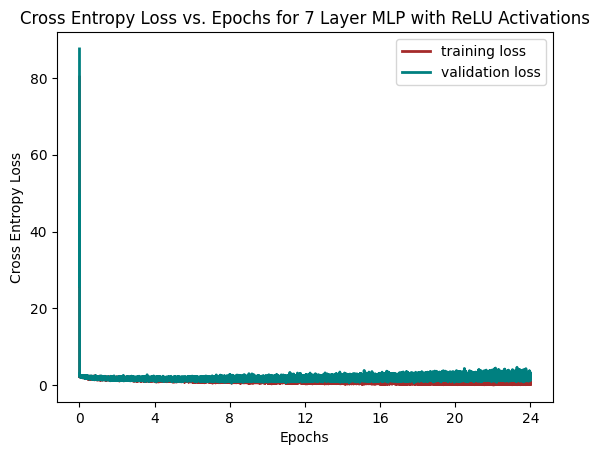

This is your training accuracy
0.8640666666666666


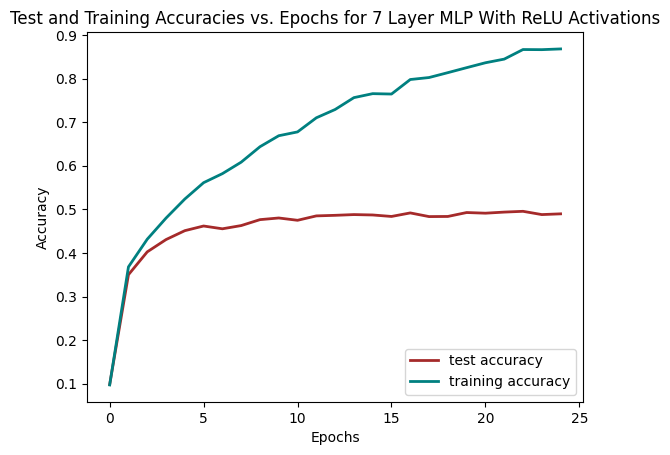

In [ ]:
title1 = "Cross Entropy Loss vs. Epochs for 7 Layer MLP with ReLU Activations"
title2 = "Test and Training Accuracies vs. Epochs for 7 Layer MLP With ReLU Activations"
completeEval(trained7,x_train_z_normalized,x_test_z_normalized,title1,title2, color1='brown',color2='teal')


### 3.3.3 - L2 Regularization and Adam Gradient Descent 


Train the Model. Above 1.1, the regularization is too high and the model starts ocillating around 50% test, 57% train accuracy. At 2, it does this but at 44% test, 46% train. Aiming for sweet spot that gets us to 54% test accuracy. Too low( 0.3125 and test and trian accuracies become very different. 

In [63]:
_lambda = 0.5
mlptest_l2adam = MLP(noHLayers=2, noHUnits=[256, 256], x=x_train_z_normalized, y=y_train, activation='reLU')
optimizer = AdamDescentOptimizer(mlptest_l2adam,lradam,b1, b2, epsilon,reg='L2',_lambda=_lambda)
trained_l2adam = mlptest_l2adam.fit(optimizer, x_train_z_normalized,x_val_z_normalized, y_train,y_val,x_test_z_normalized,y_test_raw,y_train_raw,iterationsAdam,bsize)

first hidden layer added
next layer added
output layer added


  0%|          | 11/33750 [00:01<47:35, 11.82it/s]  

 Epoch  0 | Train:  0.10397777777777778  | Test:  0.103


  4%|▍         | 1426/33750 [00:16<17:59, 29.94it/s]

 Epoch  1 | Train:  0.3867555555555556  | Test:  0.361


  8%|▊         | 2824/33750 [00:31<17:38, 29.23it/s]

 Epoch  2 | Train:  0.4764888888888889  | Test:  0.4463


 13%|█▎        | 4231/33750 [00:46<17:37, 27.91it/s]

 Epoch  3 | Train:  0.5234222222222222  | Test:  0.4817


 17%|█▋        | 5641/33750 [01:02<15:38, 29.94it/s]

 Epoch  4 | Train:  0.5388222222222222  | Test:  0.4901


 21%|██        | 7040/33750 [01:17<19:21, 22.99it/s] 

 Epoch  5 | Train:  0.5633111111111111  | Test:  0.5005


 25%|██▌       | 8451/33750 [01:32<14:08, 29.83it/s]

 Epoch  6 | Train:  0.5753555555555555  | Test:  0.5156


 29%|██▉       | 9858/33750 [01:48<14:26, 27.57it/s]

 Epoch  7 | Train:  0.5734888888888889  | Test:  0.509


 33%|███▎      | 11268/33750 [02:03<12:35, 29.77it/s]

 Epoch  8 | Train:  0.6018222222222223  | Test:  0.5279


 38%|███▊      | 12669/33750 [02:18<11:48, 29.75it/s]

 Epoch  9 | Train:  0.6102222222222222  | Test:  0.5329


 42%|████▏     | 14069/33750 [02:33<14:23, 22.80it/s] 

 Epoch  10 | Train:  0.6113111111111111  | Test:  0.5269


 46%|████▌     | 15479/33750 [02:49<11:14, 27.10it/s]

 Epoch  11 | Train:  0.6021111111111112  | Test:  0.5158


 50%|█████     | 16892/33750 [03:04<09:25, 29.82it/s]

 Epoch  12 | Train:  0.6218888888888889  | Test:  0.5262


 54%|█████▍    | 18291/33750 [03:19<08:39, 29.78it/s]

 Epoch  13 | Train:  0.6275777777777778  | Test:  0.5295


 58%|█████▊    | 19701/33750 [03:34<07:55, 29.55it/s]

 Epoch  14 | Train:  0.6320666666666667  | Test:  0.532


 63%|██████▎   | 21100/33750 [03:49<09:15, 22.78it/s] 

 Epoch  15 | Train:  0.6366222222222222  | Test:  0.5266


 67%|██████▋   | 22508/33750 [04:05<06:27, 29.02it/s]

 Epoch  16 | Train:  0.6374444444444445  | Test:  0.5344


 71%|███████   | 23918/33750 [04:20<05:27, 30.03it/s]

 Epoch  17 | Train:  0.6326666666666667  | Test:  0.5261


 75%|███████▌  | 25326/33750 [04:35<04:41, 29.91it/s]

 Epoch  18 | Train:  0.6342222222222222  | Test:  0.5289


 79%|███████▉  | 26724/33750 [04:50<05:09, 22.70it/s] 

 Epoch  19 | Train:  0.6394888888888889  | Test:  0.5303


 83%|████████▎ | 28130/33750 [05:07<04:13, 22.21it/s]

 Epoch  20 | Train:  0.6326444444444445  | Test:  0.5317


 88%|████████▊ | 29541/33750 [05:27<02:25, 28.92it/s]

 Epoch  21 | Train:  0.6310444444444444  | Test:  0.5316


 92%|█████████▏| 30949/33750 [05:46<01:33, 29.82it/s]

 Epoch  22 | Train:  0.6161555555555556  | Test:  0.5207


 96%|█████████▌| 32349/33750 [06:01<01:01, 22.77it/s] 

 Epoch  23 | Train:  0.6483111111111111  | Test:  0.5365


100%|██████████| 33750/33750 [06:17<00:00, 89.48it/s]

 Epoch  24 | Train:  0.6459111111111111  | Test:  0.5323


Test the model

This is your test accuracy
0.5295


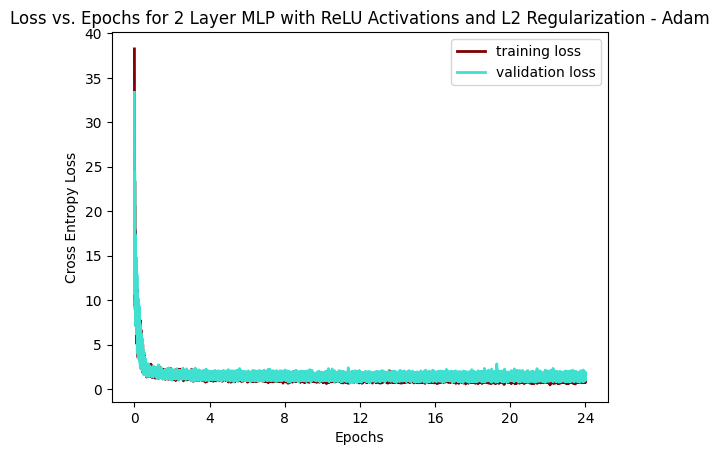

This is your training accuracy
0.6408888888888888


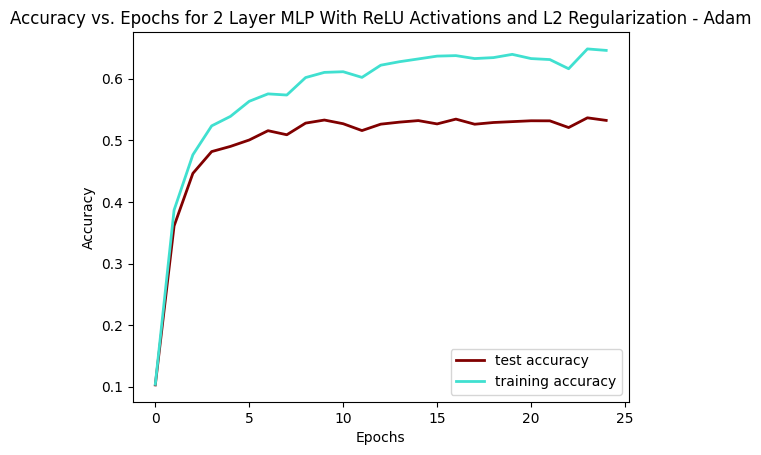

In [64]:
title1="Loss vs. Epochs for 2 Layer MLP with ReLU Activations and L2 Regularization - Adam"
title2= "Accuracy vs. Epochs for 2 Layer MLP With ReLU Activations and L2 Regularization - Adam"
completeEval(trained_l2adam,x_train_z_normalized,x_test_z_normalized,title1,title2, color1='maroon',color2='turquoise')


### 3.3.4 - Summary Plot 

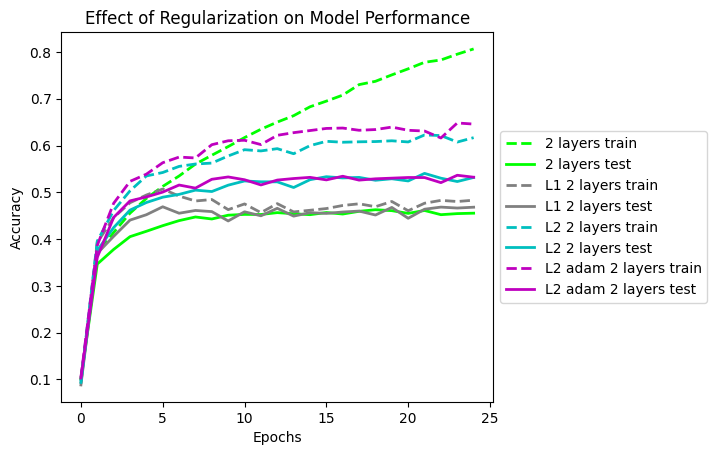

In [73]:
things = []
things.append([trained2, "2 layers train", "2 layers test","lime"])
things.append([trained_l1, "L1 2 layers train", "L1 2 layers test","gray"])
things.append([trained_l2, "L2 2 layers train", "L2 2 layers test","c"])
things.append([trained_l2adam, "L2 adam 2 layers train", "L2 adam 2 layers test","m"])


completeEvalMany(things, "Effect of Regularization on Model Performance",x_train_z_normalized,x_test_z_normalized)

## 3.4 - Normalization

Training MLP with 2 hidden layers of 256 units with ReLU activations using unnormalized data, and data that is normalized in 2 other ways - dividing all values by 255, and grayscale data



In [74]:
# create the train validation splits
inds = np.random.permutation(50000)
n_training = int(50000 * tvalsplit)
x_train_normalized, x_val_normalized = x_train_normalized_before[inds[:n_training],:], x_train_normalized_before[inds[n_training:],:]
x_train, x_val = x_train_before[inds[:n_training],:], x_train_before[inds[n_training:],:]
x_train_gray, x_val_gray = x_train_gray_before[inds[:n_training],:], x_train_gray_before[inds[n_training:],:]


print(x_train_normalized.shape)
print(x_val_normalized.shape)
print(x_train_gray.shape)
print(x_val_gray.shape)




(45000, 3072)
(5000, 3072)
(45000, 1024)
(5000, 1024)


#### 3.4.1 - Non Normalized Data
Train the model

In [80]:
mlptest_unnormalized = MLP(noHLayers=2, noHUnits=[256, 256], x=x_train, y=y_train, activation='reLU')
optimizer = GradientDescentOptimizer(mlptest_unnormalized, learningRate)
trained_unnormalized = mlptest_unnormalized.fit(optimizer, x_train,x_val, y_train,y_val,x_test,y_test_raw,y_train_raw,10000,bsize)

first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<10:05, 16.49it/s] 

 Epoch  0 | Train:  0.10024444444444444  | Test:  0.1


 14%|█▍        | 1430/10000 [00:11<02:43, 52.37it/s]

 Epoch  1 | Train:  0.10024444444444444  | Test:  0.1


 28%|██▊       | 2828/10000 [00:21<02:51, 41.80it/s] 

 Epoch  2 | Train:  0.10024444444444444  | Test:  0.1


 42%|████▏     | 4246/10000 [00:32<01:45, 54.45it/s]

 Epoch  3 | Train:  0.10024444444444444  | Test:  0.1


 57%|█████▋    | 5651/10000 [00:42<01:21, 53.67it/s]

 Epoch  4 | Train:  0.10024444444444444  | Test:  0.1


 71%|███████   | 7053/10000 [00:52<00:58, 50.44it/s]

 Epoch  5 | Train:  0.10024444444444444  | Test:  0.1


 85%|████████▍ | 8458/10000 [01:02<00:28, 54.81it/s]

 Epoch  6 | Train:  0.10024444444444444  | Test:  0.1


 99%|█████████▊| 9861/10000 [01:12<00:02, 54.57it/s]

 Epoch  7 | Train:  0.10024444444444444  | Test:  0.1


100%|██████████| 10000/10000 [01:13<00:00, 135.76it/s]


Check accuracy

We can see that due to the overflow (NaN), loss cannot be plotted and accuracy is minimal

This is your test accuracy
0.1


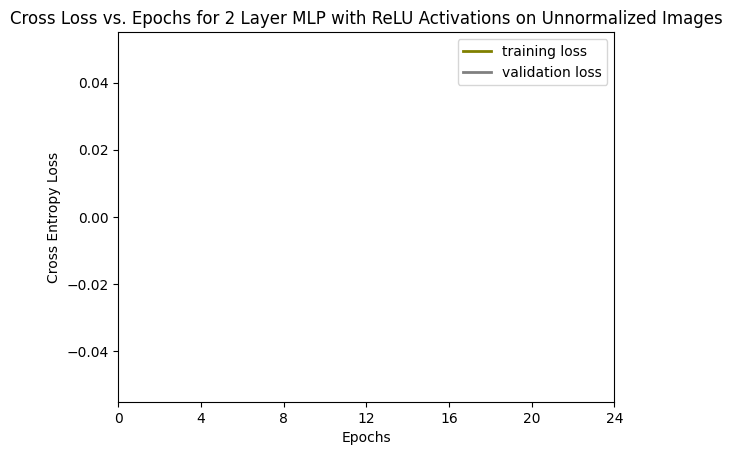

This is your training accuracy
0.10024444444444444


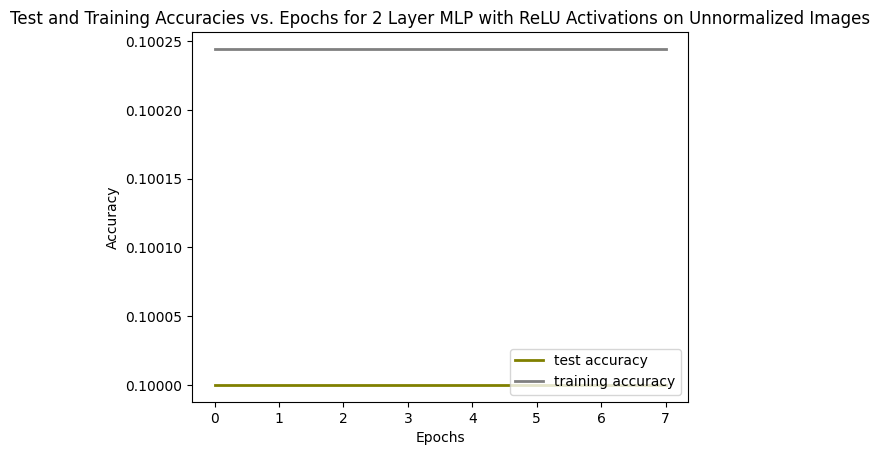

In [81]:
title1="Cross Loss vs. Epochs for 2 Layer MLP with ReLU Activations on Unnormalized Images"
title2="Test and Training Accuracies vs. Epochs for 2 Layer MLP with ReLU Activations on Unnormalized Images"
completeEval(trained_unnormalized,x_train,x_test,title1,title2,color1="olive",color2='gray')



#### 3.4.2 - Normalized with / 255

Train the model

In [76]:
mlptest_255 = MLP(noHLayers=2, noHUnits=[256, 256], x=x_train_normalized, y=y_train, activation='reLU')
optimizer = GradientDescentOptimizer(mlptest_255, learningRate)
trained_255 = mlptest_255.fit(optimizer, x_train_normalized,x_val_normalized, y_train,y_val,x_test_normalized,y_test_raw,y_train_raw,iterations,bsize)





first hidden layer added
next layer added
output layer added


  0%|          | 17/33750 [00:01<28:22, 19.81it/s] 

 Epoch  0 | Train:  0.09968888888888888  | Test:  0.0796


  4%|▍         | 1437/33750 [00:11<11:18, 47.59it/s]

 Epoch  1 | Train:  0.10406666666666667  | Test:  0.0993


  8%|▊         | 2838/33750 [00:21<11:50, 43.48it/s]

 Epoch  2 | Train:  0.10642222222222222  | Test:  0.1043


 13%|█▎        | 4245/33750 [00:32<11:36, 42.33it/s]

 Epoch  3 | Train:  0.10842222222222223  | Test:  0.1069


 17%|█▋        | 5639/33750 [00:42<14:34, 32.13it/s] 

 Epoch  4 | Train:  0.1097111111111111  | Test:  0.1034


 21%|██        | 7060/33750 [00:53<10:29, 42.39it/s]

 Epoch  5 | Train:  0.11186666666666667  | Test:  0.1024


 25%|██▌       | 8465/33750 [01:03<09:40, 43.54it/s]

 Epoch  6 | Train:  0.1148  | Test:  0.0939


 29%|██▉       | 9870/33750 [01:14<09:01, 44.08it/s]

 Epoch  7 | Train:  0.11564444444444444  | Test:  0.1103


 33%|███▎      | 11277/33750 [01:24<08:23, 44.66it/s]

 Epoch  8 | Train:  0.11915555555555556  | Test:  0.0922


 38%|███▊      | 12672/33750 [01:35<08:12, 42.82it/s]

 Epoch  9 | Train:  0.12186666666666666  | Test:  0.1014


 42%|████▏     | 14078/33750 [01:45<07:38, 42.90it/s]

 Epoch  10 | Train:  0.12088888888888889  | Test:  0.1116


 46%|████▌     | 15481/33750 [01:56<09:00, 33.83it/s] 

 Epoch  11 | Train:  0.12362222222222222  | Test:  0.115


 50%|█████     | 16887/33750 [02:06<08:21, 33.61it/s] 

 Epoch  12 | Train:  0.12753333333333333  | Test:  0.1065


 54%|█████▍    | 18294/33750 [02:17<05:58, 43.12it/s]

 Epoch  13 | Train:  0.12906666666666666  | Test:  0.0908


 58%|█████▊    | 19704/33750 [02:27<05:19, 43.93it/s]

 Epoch  14 | Train:  0.13168888888888888  | Test:  0.0882


 63%|██████▎   | 21113/33750 [02:38<04:49, 43.67it/s]

 Epoch  15 | Train:  0.13313333333333333  | Test:  0.0909


 67%|██████▋   | 22526/33750 [02:48<04:18, 43.50it/s]

 Epoch  16 | Train:  0.13584444444444443  | Test:  0.109


 71%|███████   | 23929/33750 [02:59<03:54, 41.82it/s]

 Epoch  17 | Train:  0.13895555555555555  | Test:  0.1118


 75%|███████▌  | 25335/33750 [03:09<03:21, 41.84it/s]

 Epoch  18 | Train:  0.13744444444444445  | Test:  0.106


 79%|███████▉  | 26743/33750 [03:20<02:40, 43.75it/s]

 Epoch  19 | Train:  0.14024444444444445  | Test:  0.1097


 83%|████████▎ | 28135/33750 [03:30<02:47, 33.59it/s] 

 Epoch  20 | Train:  0.14277777777777778  | Test:  0.1081


 88%|████████▊ | 29542/33750 [03:41<01:37, 43.13it/s]

 Epoch  21 | Train:  0.14744444444444443  | Test:  0.1111


 92%|█████████▏| 30948/33750 [03:51<01:04, 43.42it/s]

 Epoch  22 | Train:  0.14855555555555555  | Test:  0.0897


 96%|█████████▌| 32354/33750 [04:02<00:41, 33.62it/s] 

 Epoch  23 | Train:  0.14784444444444444  | Test:  0.0996


100%|██████████| 33750/33750 [04:12<00:00, 133.63it/s]

 Epoch  24 | Train:  0.15544444444444444  | Test:  0.1


Test the accuracies

This is your test accuracy
0.1


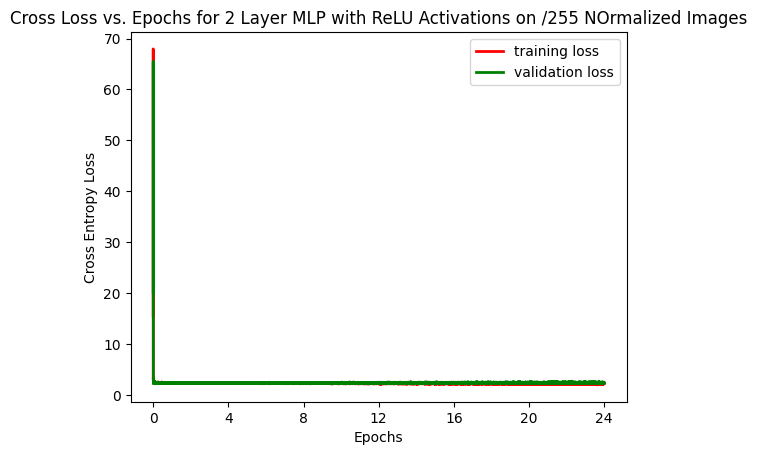

This is your training accuracy
0.10068888888888888


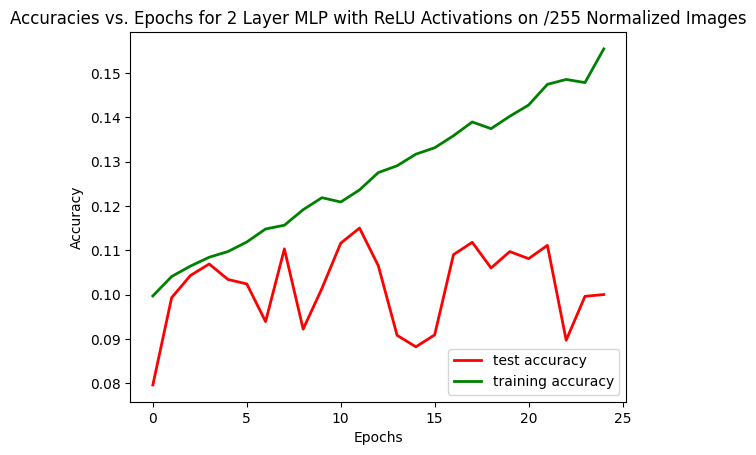

In [77]:
title1="Cross Loss vs. Epochs for 2 Layer MLP with ReLU Activations on /255 NOrmalized Images"
title2="Accuracies vs. Epochs for 2 Layer MLP with ReLU Activations on /255 Normalized Images"
completeEval(trained_255,x_train,x_test,title1,title2,color1="red",color2='green')


#### 3.4.3 - Grayscale Images

Train the model

In [78]:
mlptest_gray = MLP(noHLayers=2, noHUnits=[256, 256], x=x_train_gray, y=y_train, activation='reLU')
optimizer = GradientDescentOptimizer(mlptest_gray, learningRate)
trained_gray = mlptest_gray.fit(optimizer, x_train_gray,x_val_gray, y_train,y_val,x_test_gray,y_test_raw,y_train_raw,iterations,bsize)

first hidden layer added
next layer added
output layer added


  0%|          | 27/33750 [00:00<06:56, 80.90it/s] 

 Epoch  0 | Train:  0.10088888888888889  | Test:  0.1007


  4%|▍         | 1457/33750 [00:06<03:19, 162.27it/s]

 Epoch  1 | Train:  0.10482222222222222  | Test:  0.1138


  8%|▊         | 2840/33750 [00:12<03:15, 158.21it/s]

 Epoch  2 | Train:  0.10615555555555556  | Test:  0.1088


 13%|█▎        | 4260/33750 [00:18<02:59, 164.32it/s]

 Epoch  3 | Train:  0.11102222222222222  | Test:  0.0897


 17%|█▋        | 5676/33750 [00:24<02:52, 162.36it/s]

 Epoch  4 | Train:  0.11204444444444445  | Test:  0.1106


 21%|██        | 7069/33750 [00:29<02:45, 161.41it/s]

 Epoch  5 | Train:  0.11602222222222222  | Test:  0.1097


 25%|██▌       | 8479/33750 [00:36<02:34, 163.25it/s]

 Epoch  6 | Train:  0.11575555555555556  | Test:  0.0885


 29%|██▉       | 9895/33750 [00:41<02:25, 164.22it/s]

 Epoch  7 | Train:  0.12037777777777778  | Test:  0.1128


 33%|███▎      | 11281/33750 [00:47<02:22, 157.53it/s]

 Epoch  8 | Train:  0.12088888888888889  | Test:  0.0894


 38%|███▊      | 12693/33750 [00:53<02:08, 164.06it/s]

 Epoch  9 | Train:  0.12222222222222222  | Test:  0.1156


 42%|████▏     | 14109/33750 [00:59<02:06, 155.34it/s]

 Epoch  10 | Train:  0.1242888888888889  | Test:  0.088


 46%|████▌     | 15517/33750 [01:05<01:51, 162.99it/s]

 Epoch  11 | Train:  0.12684444444444445  | Test:  0.1126


 50%|█████     | 16910/33750 [01:11<02:01, 138.23it/s]

 Epoch  12 | Train:  0.13011111111111112  | Test:  0.1175


 54%|█████▍    | 18307/33750 [01:17<01:34, 163.34it/s]

 Epoch  13 | Train:  0.1330888888888889  | Test:  0.1113


 58%|█████▊    | 19730/33750 [01:23<01:26, 161.37it/s]

 Epoch  14 | Train:  0.1350222222222222  | Test:  0.1081


 63%|██████▎   | 21120/33750 [01:29<01:18, 161.35it/s]

 Epoch  15 | Train:  0.13846666666666665  | Test:  0.1021


 67%|██████▋   | 22524/33750 [01:35<01:11, 157.77it/s]

 Epoch  16 | Train:  0.13924444444444445  | Test:  0.1048


 71%|███████   | 23953/33750 [01:41<01:00, 161.79it/s]

 Epoch  17 | Train:  0.14304444444444445  | Test:  0.1059


 75%|███████▌  | 25353/33750 [01:47<00:54, 153.44it/s]

 Epoch  18 | Train:  0.14622222222222223  | Test:  0.0872


 79%|███████▉  | 26753/33750 [01:53<00:43, 161.83it/s]

 Epoch  19 | Train:  0.14404444444444445  | Test:  0.0946


 83%|████████▎ | 28149/33750 [01:59<00:38, 143.78it/s]

 Epoch  20 | Train:  0.15044444444444444  | Test:  0.0811


 88%|████████▊ | 29566/33750 [02:05<00:26, 157.34it/s]

 Epoch  21 | Train:  0.15237777777777778  | Test:  0.0904


 92%|█████████▏| 30976/33750 [02:11<00:21, 127.24it/s]

 Epoch  22 | Train:  0.1546  | Test:  0.1237


 96%|█████████▌| 32380/33750 [02:17<00:08, 158.49it/s]

 Epoch  23 | Train:  0.15622222222222223  | Test:  0.1272


100%|██████████| 33750/33750 [02:23<00:00, 235.83it/s]

 Epoch  24 | Train:  0.1607111111111111  | Test:  0.1189


Test the accuracies

This is your test accuracy
0.1181


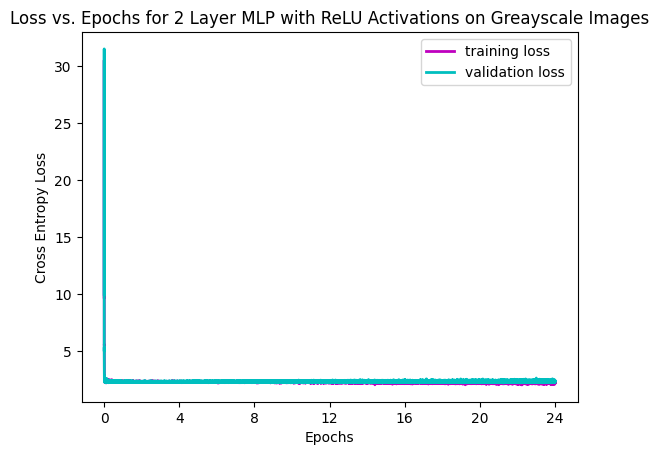

This is your training accuracy
0.1613777777777778


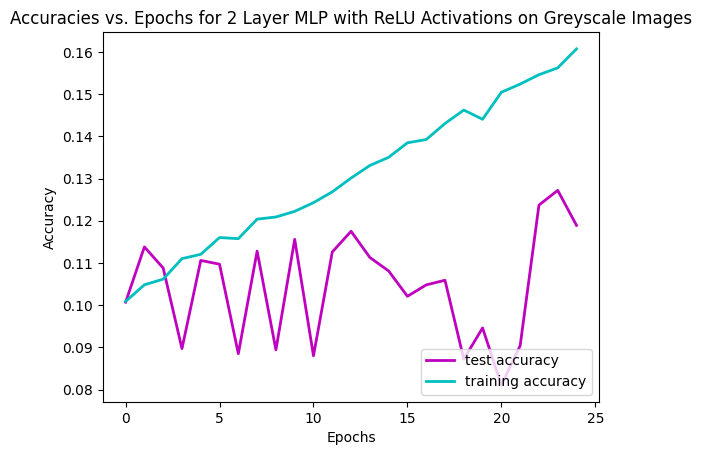

In [79]:
title1="Loss vs. Epochs for 2 Layer MLP with ReLU Activations on Greayscale Images"
title2="Accuracies vs. Epochs for 2 Layer MLP with ReLU Activations on Greyscale Images"
completeEval(trained_gray,x_train_gray,x_test_gray,title1,title2,color1="m",color2='c')


## 3.5 and 3.6 - See other File

We had issues with cupy and running out of ram, so we trained our other models in a different file. Please see that and sorry for any inconvenience. Thank you. 

# Task 4 - Extra Exploration



## 4.1 - Hyper-parameter Tuning

Goal: determine optimal values for the following hyper-parameters:


*   Learning rate (Gradient Descent)
*   b1, b2, epsilon, learning rate (ADAM)





Hyperparameter plotting function

In [ ]:
def plot_hp(x_label, x, y1, y2, title, color1, color2, log=False):
    plt.style.use('default')
    plt.title(title)
    if log:
        plt.xscale('log')
    plt.plot(x, y1, label='mean train accuracy', color=color1, linewidth=2)
    plt.plot(x, y2, label='mean test accuracy', color=color2, linewidth=2)
    plt.xlabel(x_label)
    plt.ylabel("Accuracy")
    plt.legend(loc='lower right')
    plt.show()

###4.1.1 Learning Rate

Iterative model training function

In [ ]:
def train_lr_iterative(learning_rates, iterations_per_lr, iterations_per_model):
    lr_model_train_accs = []
    lr_model_test_accs = []
    for learning_rate in learning_rates:
        train_accs = []
        test_accs = []
        # average accuracy over 5 models
        for i in range(iterations_per_lr):
            # L2-regularized model from 3.3.2, with limited iterations (1000)
            mlptest_lr = MLP(noHLayers=2, noHUnits=[256, 256], activation='reLU')
            optimizer = GradientDescentOptimizer(mlptest_lr, learning_rate, regularization='L2', _lambda=0.0125)
            trained_lr = mlptest_lr.fit(optimizer, x_train_z_normalized,x_val_z_normalized, y_train,y_val,x_test_z_normalized,y_test_raw,y_train_raw,iterations_per_model,bsize)
            yh = trained_lr.predictClass(x_train_z_normalized)
            train_accs.append(eval_acc(yh,y_train_raw).get())
            yh = trained_lr.predictClass(x_test_z_normalized)
            test_accs.append(eval_acc(yh,y_test_raw).get())
            print('model done')
        lr_model_train_accs.append(np.mean(np.array(train_accs)))
        lr_model_test_accs.append(np.mean(np.array(test_accs)))
        print(f'learning rate {learning_rate} finished on {iterations_per_lr} models.')
    return lr_model_train_accs, lr_model_test_accs

Train the models - using a wider range of learning rates on less iterations

In [ ]:
# wide range of values to check. Will test these on simplified model with limited iterations
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

lr_model_train_accs, lr_model_test_accs = train_lr_iterative(learning_rates, 5, 1000)

first hidden layer added
next layer added
output layer added


  0%|          | 0/1000 [00:00<?, ?it/s]

 Epoch  0 | Train:  0.11686666666666666  | Test:  0.1128


100%|██████████| 1000/1000 [00:24<00:00, 41.54it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:49, 19.87it/s]

 Epoch  0 | Train:  0.09137777777777778  | Test:  0.0907


100%|██████████| 1000/1000 [00:07<00:00, 132.06it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 17/1000 [00:01<00:47, 20.79it/s]

 Epoch  0 | Train:  0.10806666666666667  | Test:  0.1079


100%|██████████| 1000/1000 [00:07<00:00, 131.18it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 17/1000 [00:01<00:48, 20.47it/s]

 Epoch  0 | Train:  0.10057777777777778  | Test:  0.107


100%|██████████| 1000/1000 [00:08<00:00, 112.18it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 17/1000 [00:01<00:48, 20.21it/s]

 Epoch  0 | Train:  0.09444444444444444  | Test:  0.0921


100%|██████████| 1000/1000 [00:07<00:00, 131.37it/s]


model done
learning rate 0.0001 finished on 5 models.
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:52, 18.80it/s]

 Epoch  0 | Train:  0.09957777777777778  | Test:  0.0961


100%|██████████| 1000/1000 [00:07<00:00, 129.31it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:52, 18.82it/s]

 Epoch  0 | Train:  0.09722222222222222  | Test:  0.094


100%|██████████| 1000/1000 [00:07<00:00, 128.80it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 17/1000 [00:01<00:49, 19.82it/s]

 Epoch  0 | Train:  0.09215555555555556  | Test:  0.0918


100%|██████████| 1000/1000 [00:07<00:00, 130.40it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 17/1000 [00:01<00:49, 19.80it/s]

 Epoch  0 | Train:  0.09586666666666667  | Test:  0.0966


100%|██████████| 1000/1000 [00:07<00:00, 130.35it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:52, 18.88it/s]

 Epoch  0 | Train:  0.0932888888888889  | Test:  0.0912


100%|██████████| 1000/1000 [00:07<00:00, 129.45it/s]


model done
learning rate 0.0005 finished on 5 models.
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:52, 18.92it/s]

 Epoch  0 | Train:  0.0966  | Test:  0.0915


100%|██████████| 1000/1000 [00:07<00:00, 129.68it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:51, 19.10it/s]

 Epoch  0 | Train:  0.12028888888888889  | Test:  0.1211


100%|██████████| 1000/1000 [00:07<00:00, 131.48it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 15/1000 [00:01<00:55, 17.85it/s]

 Epoch  0 | Train:  0.09575555555555555  | Test:  0.1009


100%|██████████| 1000/1000 [00:07<00:00, 130.73it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 17/1000 [00:01<00:48, 20.17it/s]

 Epoch  0 | Train:  0.11017777777777778  | Test:  0.1104


100%|██████████| 1000/1000 [00:07<00:00, 129.88it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 17/1000 [00:01<00:48, 20.08it/s]

 Epoch  0 | Train:  0.12204444444444444  | Test:  0.1229


100%|██████████| 1000/1000 [00:07<00:00, 131.04it/s]


model done
learning rate 0.001 finished on 5 models.
first hidden layer added
next layer added
output layer added


  2%|▏         | 17/1000 [00:01<00:48, 20.11it/s]

 Epoch  0 | Train:  0.09873333333333334  | Test:  0.1009


100%|██████████| 1000/1000 [00:07<00:00, 131.02it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:51, 18.99it/s]

 Epoch  0 | Train:  0.10084444444444444  | Test:  0.1011


100%|██████████| 1000/1000 [00:07<00:00, 129.13it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 17/1000 [00:01<00:49, 19.98it/s]

 Epoch  0 | Train:  0.124  | Test:  0.1256


100%|██████████| 1000/1000 [00:07<00:00, 129.32it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:51, 18.99it/s]

 Epoch  0 | Train:  0.11382222222222223  | Test:  0.114


100%|██████████| 1000/1000 [00:07<00:00, 131.13it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:52, 18.70it/s]

 Epoch  0 | Train:  0.12673333333333334  | Test:  0.1223


100%|██████████| 1000/1000 [00:07<00:00, 130.17it/s]


model done
learning rate 0.005 finished on 5 models.
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:51, 19.02it/s]

 Epoch  0 | Train:  0.08755555555555555  | Test:  0.0861


100%|██████████| 1000/1000 [00:07<00:00, 129.92it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:52, 18.90it/s]

 Epoch  0 | Train:  0.1154  | Test:  0.1129


100%|██████████| 1000/1000 [00:07<00:00, 128.59it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 17/1000 [00:01<00:49, 19.97it/s]

 Epoch  0 | Train:  0.10311111111111111  | Test:  0.1087


100%|██████████| 1000/1000 [00:07<00:00, 131.00it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:52, 18.86it/s]

 Epoch  0 | Train:  0.09977777777777778  | Test:  0.1014


100%|██████████| 1000/1000 [00:07<00:00, 130.46it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:51, 19.00it/s]

 Epoch  0 | Train:  0.1058  | Test:  0.1063


100%|██████████| 1000/1000 [00:07<00:00, 129.69it/s]


model done
learning rate 0.01 finished on 5 models.
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:51, 19.00it/s]

 Epoch  0 | Train:  0.09884444444444444  | Test:  0.1028


100%|██████████| 1000/1000 [00:07<00:00, 131.00it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:52, 18.87it/s]

 Epoch  0 | Train:  0.09875555555555555  | Test:  0.101


100%|██████████| 1000/1000 [00:08<00:00, 124.94it/s]


model done
first hidden layer added
next layer added
output layer added


  1%|          | 12/1000 [00:01<01:10, 13.98it/s]

 Epoch  0 | Train:  0.09964444444444444  | Test:  0.0967


100%|██████████| 1000/1000 [00:11<00:00, 83.98it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:51, 19.00it/s]

 Epoch  0 | Train:  0.09644444444444444  | Test:  0.0991


100%|██████████| 1000/1000 [00:07<00:00, 128.79it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:52, 18.92it/s]

 Epoch  0 | Train:  0.11037777777777778  | Test:  0.1124


100%|██████████| 1000/1000 [00:07<00:00, 128.50it/s]


model done
learning rate 0.05 finished on 5 models.
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:51, 18.93it/s]

 Epoch  0 | Train:  0.10802222222222223  | Test:  0.1098


100%|██████████| 1000/1000 [00:07<00:00, 130.48it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:52, 18.75it/s]

 Epoch  0 | Train:  0.09875555555555555  | Test:  0.0986


100%|██████████| 1000/1000 [00:07<00:00, 129.59it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:51, 18.97it/s]

 Epoch  0 | Train:  0.10157777777777778  | Test:  0.0978


100%|██████████| 1000/1000 [00:07<00:00, 128.61it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:52, 18.86it/s]

 Epoch  0 | Train:  0.07375555555555556  | Test:  0.0759


100%|██████████| 1000/1000 [00:07<00:00, 129.96it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:52, 18.92it/s]

 Epoch  0 | Train:  0.06968888888888888  | Test:  0.0707


100%|██████████| 1000/1000 [00:08<00:00, 120.73it/s]


model done
learning rate 0.1 finished on 5 models.
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:51, 18.97it/s]

 Epoch  0 | Train:  0.10864444444444445  | Test:  0.1039


100%|██████████| 1000/1000 [00:07<00:00, 128.67it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:51, 18.94it/s]

 Epoch  0 | Train:  0.09771111111111111  | Test:  0.098


100%|██████████| 1000/1000 [00:07<00:00, 129.63it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:51, 19.02it/s]

 Epoch  0 | Train:  0.1010888888888889  | Test:  0.0991


100%|██████████| 1000/1000 [00:07<00:00, 130.76it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 15/1000 [00:01<00:55, 17.75it/s]

 Epoch  0 | Train:  0.09393333333333333  | Test:  0.0903


100%|██████████| 1000/1000 [00:07<00:00, 129.92it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:52, 18.89it/s]

 Epoch  0 | Train:  0.12191111111111111  | Test:  0.1201


100%|██████████| 1000/1000 [00:07<00:00, 128.10it/s]


model done
learning rate 0.5 finished on 5 models.
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:52, 18.87it/s]

 Epoch  0 | Train:  0.0914  | Test:  0.088


100%|██████████| 1000/1000 [00:07<00:00, 129.28it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:51, 19.01it/s]

 Epoch  0 | Train:  0.11348888888888889  | Test:  0.123


100%|██████████| 1000/1000 [00:07<00:00, 130.55it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:51, 19.05it/s]

 Epoch  0 | Train:  0.10482222222222222  | Test:  0.1041


100%|██████████| 1000/1000 [00:08<00:00, 124.67it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 15/1000 [00:01<00:56, 17.45it/s]

 Epoch  0 | Train:  0.0844  | Test:  0.0856


100%|██████████| 1000/1000 [00:10<00:00, 92.49it/s]


model done
first hidden layer added
next layer added
output layer added


  2%|▏         | 16/1000 [00:01<00:51, 19.05it/s]

 Epoch  0 | Train:  0.09286666666666667  | Test:  0.0986


100%|██████████| 1000/1000 [00:07<00:00, 129.32it/s]


model done
learning rate 1 finished on 5 models.


Plot Results

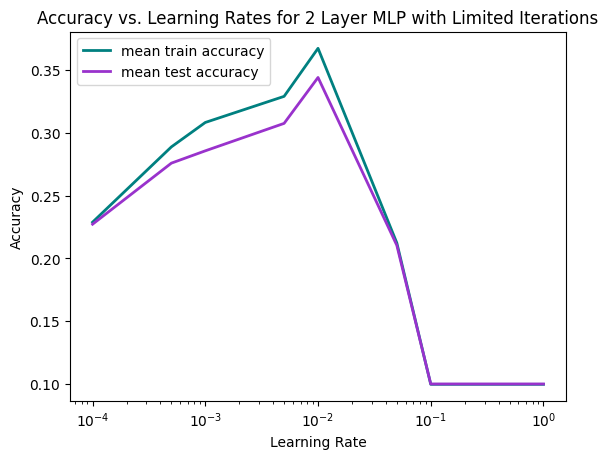

In [ ]:
x_label = 'Learning Rate'
title = "Accuracy vs. Learning Rates for 2 Layer MLP with Limited Iterations"
color1 = 'teal'
color2 = 'darkorchid'

lr_model_train_accs = np.array(lr_model_train_accs).get()
lr_model_test_accs = np.array(lr_model_test_accs).get()

plot_hp(x_label, learning_rates, lr_model_train_accs, lr_model_test_accs, title, color1, color2, log=True)

The highest performing learning rate is around 0.01.

We will now train new models - using a more concise range of learning rates around 0.01 on higher iterations.

In [ ]:
# smaller range of values to check. Will test these on model with more iterations
learning_rates_precise = [0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]
# this takes about an hour to run
lr_model_train_accs_precise, lr_model_test_accs_precise = train_lr_iterative(learning_rates_precise, 5, 10000)

first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:45, 19.01it/s] 

 Epoch  0 | Train:  0.10206666666666667  | Test:  0.1033


 14%|█▍        | 1421/10000 [00:11<03:56, 36.24it/s] 

 Epoch  1 | Train:  0.363  | Test:  0.3372


 28%|██▊       | 2831/10000 [00:22<02:36, 45.77it/s]

 Epoch  2 | Train:  0.43166666666666664  | Test:  0.3863


 42%|████▏     | 4234/10000 [00:32<01:59, 48.25it/s]

 Epoch  3 | Train:  0.4730666666666667  | Test:  0.4157


 56%|█████▋    | 5650/10000 [00:42<01:29, 48.49it/s]

 Epoch  4 | Train:  0.5015333333333334  | Test:  0.4397


 70%|███████   | 7035/10000 [00:53<01:34, 31.47it/s] 

 Epoch  5 | Train:  0.5213555555555556  | Test:  0.4587


 85%|████████▍ | 8461/10000 [01:04<00:31, 49.16it/s]

 Epoch  6 | Train:  0.5336666666666666  | Test:  0.4698


 99%|█████████▊| 9863/10000 [01:15<00:02, 48.51it/s]

 Epoch  7 | Train:  0.5525111111111111  | Test:  0.4813


100%|██████████| 10000/10000 [01:16<00:00, 130.42it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:45, 19.00it/s] 

 Epoch  0 | Train:  0.09182222222222222  | Test:  0.0918


 14%|█▍        | 1434/10000 [00:11<02:54, 49.21it/s]

 Epoch  1 | Train:  0.3671333333333333  | Test:  0.3345


 28%|██▊       | 2839/10000 [00:22<02:25, 49.29it/s]

 Epoch  2 | Train:  0.43348888888888887  | Test:  0.3906


 42%|████▏     | 4241/10000 [00:32<01:56, 49.31it/s]

 Epoch  3 | Train:  0.47055555555555556  | Test:  0.4202


 56%|█████▋    | 5643/10000 [00:42<01:31, 47.58it/s]

 Epoch  4 | Train:  0.4967111111111111  | Test:  0.4366


 71%|███████   | 7058/10000 [00:53<01:03, 46.68it/s]

 Epoch  5 | Train:  0.5264222222222222  | Test:  0.4526


 85%|████████▍ | 8459/10000 [01:03<00:31, 48.92it/s]

 Epoch  6 | Train:  0.5382222222222223  | Test:  0.4646


 99%|█████████▊| 9862/10000 [01:13<00:02, 49.29it/s]

 Epoch  7 | Train:  0.5550444444444445  | Test:  0.4765


100%|██████████| 10000/10000 [01:14<00:00, 133.78it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:51, 18.77it/s] 

 Epoch  0 | Train:  0.1072  | Test:  0.0997


 14%|█▍        | 1429/10000 [00:11<02:54, 49.16it/s]

 Epoch  1 | Train:  0.3776  | Test:  0.3447


 28%|██▊       | 2832/10000 [00:21<02:26, 49.08it/s]

 Epoch  2 | Train:  0.43755555555555553  | Test:  0.3997


 42%|████▏     | 4239/10000 [00:32<01:58, 48.81it/s]

 Epoch  3 | Train:  0.4764  | Test:  0.4277


 56%|█████▋    | 5644/10000 [00:42<01:28, 49.11it/s]

 Epoch  4 | Train:  0.5013111111111112  | Test:  0.4464


 70%|███████   | 7050/10000 [00:53<01:00, 48.87it/s]

 Epoch  5 | Train:  0.5219555555555555  | Test:  0.4618


 85%|████████▍ | 8454/10000 [01:03<00:33, 46.43it/s]

 Epoch  6 | Train:  0.5392  | Test:  0.4742


 99%|█████████▊| 9860/10000 [01:13<00:02, 47.30it/s]

 Epoch  7 | Train:  0.5566444444444445  | Test:  0.4877


100%|██████████| 10000/10000 [01:14<00:00, 133.66it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 17/10000 [00:01<08:18, 20.02it/s] 

 Epoch  0 | Train:  0.09424444444444445  | Test:  0.0924


 14%|█▍        | 1429/10000 [00:11<03:02, 46.96it/s]

 Epoch  1 | Train:  0.3569777777777778  | Test:  0.3264


 28%|██▊       | 2830/10000 [00:21<02:41, 44.45it/s]

 Epoch  2 | Train:  0.43144444444444446  | Test:  0.3949


 42%|████▏     | 4241/10000 [00:32<01:56, 49.24it/s]

 Epoch  3 | Train:  0.4686666666666667  | Test:  0.4229


 56%|█████▋    | 5646/10000 [00:43<01:30, 48.20it/s]

 Epoch  4 | Train:  0.4982888888888889  | Test:  0.4414


 70%|███████   | 7050/10000 [00:53<00:59, 49.19it/s]

 Epoch  5 | Train:  0.5179111111111111  | Test:  0.46


 85%|████████▍ | 8453/10000 [01:03<00:31, 48.63it/s]

 Epoch  6 | Train:  0.5387777777777778  | Test:  0.4751


 99%|█████████▊| 9872/10000 [01:14<00:02, 48.95it/s]

 Epoch  7 | Train:  0.5529555555555555  | Test:  0.4801


100%|██████████| 10000/10000 [01:15<00:00, 132.88it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:49, 18.85it/s] 

 Epoch  0 | Train:  0.10133333333333333  | Test:  0.1057


 14%|█▍        | 1434/10000 [00:11<02:54, 49.12it/s]

 Epoch  1 | Train:  0.3761333333333333  | Test:  0.3403


 28%|██▊       | 2838/10000 [00:22<02:26, 48.95it/s]

 Epoch  2 | Train:  0.43733333333333335  | Test:  0.3915


 42%|████▏     | 4237/10000 [00:32<02:05, 46.01it/s]

 Epoch  3 | Train:  0.4782888888888889  | Test:  0.4244


 56%|█████▋    | 5644/10000 [00:42<01:31, 47.78it/s]

 Epoch  4 | Train:  0.5057777777777778  | Test:  0.447


 71%|███████   | 7051/10000 [00:53<01:00, 48.92it/s]

 Epoch  5 | Train:  0.5283555555555556  | Test:  0.4603


 85%|████████▍ | 8452/10000 [01:03<00:32, 48.28it/s]

 Epoch  6 | Train:  0.5440666666666667  | Test:  0.4751


 99%|█████████▊| 9866/10000 [01:14<00:02, 48.86it/s]

 Epoch  7 | Train:  0.5570444444444445  | Test:  0.4873


100%|██████████| 10000/10000 [01:14<00:00, 133.43it/s]


model done
learning rate 0.006 finished on 5 models.
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:48, 18.89it/s] 

 Epoch  0 | Train:  0.0932  | Test:  0.1003


 14%|█▍        | 1435/10000 [00:11<03:09, 45.08it/s]

 Epoch  1 | Train:  0.37755555555555553  | Test:  0.3502


 28%|██▊       | 2840/10000 [00:22<02:25, 49.13it/s]

 Epoch  2 | Train:  0.449  | Test:  0.403


 42%|████▏     | 4246/10000 [00:32<01:57, 49.11it/s]

 Epoch  3 | Train:  0.4819777777777778  | Test:  0.429


 57%|█████▋    | 5652/10000 [00:42<01:28, 49.06it/s]

 Epoch  4 | Train:  0.5055555555555555  | Test:  0.4501


 71%|███████   | 7052/10000 [00:53<01:03, 46.68it/s]

 Epoch  5 | Train:  0.5349333333333334  | Test:  0.4659


 85%|████████▍ | 8458/10000 [01:03<00:32, 47.02it/s]

 Epoch  6 | Train:  0.5503555555555556  | Test:  0.4835


 99%|█████████▊| 9864/10000 [01:14<00:02, 48.74it/s]

 Epoch  7 | Train:  0.5669111111111111  | Test:  0.4986


100%|██████████| 10000/10000 [01:14<00:00, 133.44it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:51, 18.79it/s] 

 Epoch  0 | Train:  0.1054  | Test:  0.1023


 14%|█▍        | 1434/10000 [00:11<02:54, 48.98it/s]

 Epoch  1 | Train:  0.37004444444444445  | Test:  0.3375


 28%|██▊       | 2840/10000 [00:21<02:25, 49.05it/s]

 Epoch  2 | Train:  0.4483111111111111  | Test:  0.4038


 42%|████▏     | 4236/10000 [00:32<01:59, 48.23it/s]

 Epoch  3 | Train:  0.48662222222222223  | Test:  0.4372


 56%|█████▋    | 5640/10000 [00:42<01:54, 37.95it/s] 

 Epoch  4 | Train:  0.5143555555555556  | Test:  0.4589


 70%|███████   | 7046/10000 [00:53<01:18, 37.71it/s] 

 Epoch  5 | Train:  0.5322  | Test:  0.4685


 85%|████████▍ | 8456/10000 [01:03<00:32, 47.11it/s]

 Epoch  6 | Train:  0.5469333333333334  | Test:  0.488


 99%|█████████▊| 9862/10000 [01:13<00:02, 48.07it/s]

 Epoch  7 | Train:  0.5667333333333333  | Test:  0.4987


100%|██████████| 10000/10000 [01:14<00:00, 133.44it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:44, 19.04it/s] 

 Epoch  0 | Train:  0.11086666666666667  | Test:  0.1131


 14%|█▍        | 1428/10000 [00:11<03:05, 46.32it/s]

 Epoch  1 | Train:  0.37735555555555556  | Test:  0.3586


 28%|██▊       | 2835/10000 [00:21<02:28, 48.14it/s]

 Epoch  2 | Train:  0.4424222222222222  | Test:  0.404


 42%|████▏     | 4244/10000 [00:32<01:57, 49.05it/s]

 Epoch  3 | Train:  0.4865777777777778  | Test:  0.4429


 56%|█████▋    | 5646/10000 [00:42<01:28, 49.24it/s]

 Epoch  4 | Train:  0.5142222222222222  | Test:  0.4573


 70%|███████   | 7050/10000 [00:53<00:59, 49.22it/s]

 Epoch  5 | Train:  0.5342  | Test:  0.4773


 85%|████████▍ | 8456/10000 [01:03<00:31, 49.09it/s]

 Epoch  6 | Train:  0.5542666666666667  | Test:  0.487


 99%|█████████▊| 9872/10000 [01:13<00:02, 48.93it/s]

 Epoch  7 | Train:  0.5585777777777777  | Test:  0.4949


100%|██████████| 10000/10000 [01:14<00:00, 133.75it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 17/10000 [00:01<08:19, 19.99it/s] 

 Epoch  0 | Train:  0.10777777777777778  | Test:  0.11


 14%|█▍        | 1421/10000 [00:11<03:45, 38.10it/s] 

 Epoch  1 | Train:  0.3920666666666667  | Test:  0.3718


 28%|██▊       | 2835/10000 [00:25<02:26, 48.94it/s]

 Epoch  2 | Train:  0.4497777777777778  | Test:  0.4185


 42%|████▏     | 4234/10000 [00:38<02:00, 47.71it/s]

 Epoch  3 | Train:  0.4872444444444444  | Test:  0.4392


 56%|█████▋    | 5649/10000 [00:51<01:40, 43.18it/s]

 Epoch  4 | Train:  0.5069111111111111  | Test:  0.4553


 70%|███████   | 7030/10000 [01:01<00:21, 137.49it/s]

 Epoch  5 | Train:  0.5320222222222222  | Test:  0.4701


 85%|████████▍ | 8464/10000 [01:16<00:31, 48.55it/s]

 Epoch  6 | Train:  0.5475555555555556  | Test:  0.4815


 99%|█████████▊| 9866/10000 [01:26<00:02, 49.14it/s]

 Epoch  7 | Train:  0.5626666666666666  | Test:  0.497


100%|██████████| 10000/10000 [01:27<00:00, 114.51it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:47, 18.93it/s] 

 Epoch  0 | Train:  0.11864444444444444  | Test:  0.1171


 14%|█▍        | 1433/10000 [00:11<02:58, 47.89it/s]

 Epoch  1 | Train:  0.3844222222222222  | Test:  0.362


 28%|██▊       | 2835/10000 [00:22<02:26, 49.00it/s]

 Epoch  2 | Train:  0.4421777777777778  | Test:  0.407


 42%|████▏     | 4236/10000 [00:32<01:57, 49.24it/s]

 Epoch  3 | Train:  0.47715555555555556  | Test:  0.4389


 56%|█████▋    | 5646/10000 [00:42<01:33, 46.47it/s]

 Epoch  4 | Train:  0.5081333333333333  | Test:  0.4527


 70%|███████   | 7050/10000 [00:53<01:02, 47.38it/s]

 Epoch  5 | Train:  0.5306  | Test:  0.4732


 85%|████████▍ | 8461/10000 [01:03<00:31, 49.19it/s]

 Epoch  6 | Train:  0.5437333333333333  | Test:  0.4797


 99%|█████████▊| 9864/10000 [01:14<00:02, 49.07it/s]

 Epoch  7 | Train:  0.5595333333333333  | Test:  0.4934


100%|██████████| 10000/10000 [01:15<00:00, 133.25it/s]


model done
learning rate 0.008 finished on 5 models.
first hidden layer added
next layer added
output layer added


  0%|          | 15/10000 [00:01<09:21, 17.79it/s] 

 Epoch  0 | Train:  0.10155555555555555  | Test:  0.0995


 14%|█▍        | 1424/10000 [00:11<02:57, 48.36it/s]

 Epoch  1 | Train:  0.3930222222222222  | Test:  0.3787


 28%|██▊       | 2842/10000 [00:21<02:25, 49.06it/s]

 Epoch  2 | Train:  0.45024444444444445  | Test:  0.4202


 42%|████▏     | 4245/10000 [00:32<01:57, 49.02it/s]

 Epoch  3 | Train:  0.49295555555555554  | Test:  0.4458


 56%|█████▋    | 5648/10000 [00:42<01:28, 49.22it/s]

 Epoch  4 | Train:  0.5193777777777778  | Test:  0.4637


 70%|███████   | 7047/10000 [00:53<01:01, 48.35it/s]

 Epoch  5 | Train:  0.5383777777777777  | Test:  0.4872


 85%|████████▍ | 8454/10000 [01:03<00:33, 46.56it/s]

 Epoch  6 | Train:  0.5459111111111111  | Test:  0.4859


 99%|█████████▊| 9860/10000 [01:13<00:02, 48.00it/s]

 Epoch  7 | Train:  0.5576444444444445  | Test:  0.4958


100%|██████████| 10000/10000 [01:14<00:00, 133.59it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:47, 18.94it/s] 

 Epoch  0 | Train:  0.10828888888888889  | Test:  0.1063


 14%|█▍        | 1428/10000 [00:11<03:03, 46.66it/s]

 Epoch  1 | Train:  0.3907555555555556  | Test:  0.367


 28%|██▊       | 2835/10000 [00:22<02:33, 46.67it/s]

 Epoch  2 | Train:  0.4482  | Test:  0.4166


 42%|████▏     | 4234/10000 [00:33<02:32, 37.80it/s] 

 Epoch  3 | Train:  0.49  | Test:  0.4461


 57%|█████▋    | 5652/10000 [00:43<01:29, 48.79it/s]

 Epoch  4 | Train:  0.5188  | Test:  0.4704


 71%|███████   | 7058/10000 [00:54<01:00, 48.77it/s]

 Epoch  5 | Train:  0.5369333333333334  | Test:  0.4815


 85%|████████▍ | 8459/10000 [01:04<00:31, 48.45it/s]

 Epoch  6 | Train:  0.5529111111111111  | Test:  0.4935


 99%|█████████▊| 9864/10000 [01:14<00:02, 48.89it/s]

 Epoch  7 | Train:  0.5709333333333333  | Test:  0.5082


100%|██████████| 10000/10000 [01:15<00:00, 131.88it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 17/10000 [00:01<08:16, 20.11it/s] 

 Epoch  0 | Train:  0.11013333333333333  | Test:  0.1125


 14%|█▍        | 1432/10000 [00:11<02:54, 49.00it/s]

 Epoch  1 | Train:  0.38584444444444443  | Test:  0.3615


 28%|██▊       | 2836/10000 [00:22<02:28, 48.17it/s]

 Epoch  2 | Train:  0.46024444444444446  | Test:  0.4276


 42%|████▏     | 4240/10000 [00:32<02:01, 47.27it/s]

 Epoch  3 | Train:  0.4913111111111111  | Test:  0.4535


 56%|█████▋    | 5639/10000 [00:42<02:01, 36.02it/s] 

 Epoch  4 | Train:  0.5232  | Test:  0.4755


 71%|███████   | 7056/10000 [00:53<00:59, 49.17it/s]

 Epoch  5 | Train:  0.5385333333333333  | Test:  0.485


 85%|████████▍ | 8458/10000 [01:03<00:31, 48.82it/s]

 Epoch  6 | Train:  0.5534  | Test:  0.499


 99%|█████████▊| 9872/10000 [01:14<00:02, 49.15it/s]

 Epoch  7 | Train:  0.5688444444444445  | Test:  0.5083


100%|██████████| 10000/10000 [01:15<00:00, 133.25it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:48, 18.88it/s] 

 Epoch  0 | Train:  0.07984444444444444  | Test:  0.0804


 14%|█▍        | 1434/10000 [00:11<02:55, 48.89it/s]

 Epoch  1 | Train:  0.37724444444444444  | Test:  0.3464


 28%|██▊       | 2837/10000 [00:22<02:26, 48.87it/s]

 Epoch  2 | Train:  0.44884444444444443  | Test:  0.4128


 42%|████▏     | 4240/10000 [00:32<01:57, 48.90it/s]

 Epoch  3 | Train:  0.49148888888888886  | Test:  0.4465


 56%|█████▋    | 5646/10000 [00:42<01:28, 49.10it/s]

 Epoch  4 | Train:  0.5155333333333333  | Test:  0.4668


 70%|███████   | 7050/10000 [00:53<01:02, 46.93it/s]

 Epoch  5 | Train:  0.5408444444444445  | Test:  0.4881


 85%|████████▍ | 8451/10000 [01:03<00:42, 36.80it/s] 

 Epoch  6 | Train:  0.5575555555555556  | Test:  0.4982


 99%|█████████▊| 9868/10000 [01:13<00:02, 49.13it/s]

 Epoch  7 | Train:  0.5632  | Test:  0.5047


100%|██████████| 10000/10000 [01:14<00:00, 133.53it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 17/10000 [00:01<08:17, 20.06it/s] 

 Epoch  0 | Train:  0.09157777777777777  | Test:  0.0994


 14%|█▍        | 1424/10000 [00:11<02:57, 48.26it/s]

 Epoch  1 | Train:  0.3957333333333333  | Test:  0.3711


 28%|██▊       | 2839/10000 [00:21<02:24, 49.41it/s]

 Epoch  2 | Train:  0.4574666666666667  | Test:  0.4175


 42%|████▏     | 4240/10000 [00:32<01:57, 49.17it/s]

 Epoch  3 | Train:  0.4980888888888889  | Test:  0.45


 56%|█████▋    | 5645/10000 [00:42<01:29, 48.40it/s]

 Epoch  4 | Train:  0.5221777777777777  | Test:  0.4691


 70%|███████   | 7049/10000 [00:53<00:59, 49.20it/s]

 Epoch  5 | Train:  0.5454444444444444  | Test:  0.4905


 85%|████████▍ | 8455/10000 [01:03<00:31, 48.89it/s]

 Epoch  6 | Train:  0.5605777777777777  | Test:  0.498


 99%|█████████▊| 9866/10000 [01:13<00:02, 47.35it/s]

 Epoch  7 | Train:  0.5650222222222222  | Test:  0.5047


100%|██████████| 10000/10000 [01:14<00:00, 133.74it/s]


model done
learning rate 0.01 finished on 5 models.
first hidden layer added
next layer added
output layer added


  0%|          | 17/10000 [00:01<08:16, 20.10it/s] 

 Epoch  0 | Train:  0.10988888888888888  | Test:  0.11


 14%|█▍        | 1422/10000 [00:11<03:45, 38.08it/s] 

 Epoch  1 | Train:  0.39411111111111113  | Test:  0.3766


 28%|██▊       | 2831/10000 [00:21<02:34, 46.52it/s]

 Epoch  2 | Train:  0.46904444444444443  | Test:  0.4374


 42%|████▏     | 4237/10000 [00:32<01:59, 48.30it/s]

 Epoch  3 | Train:  0.5074888888888889  | Test:  0.4637


 56%|█████▋    | 5644/10000 [00:42<01:32, 47.27it/s]

 Epoch  4 | Train:  0.5294  | Test:  0.4896


 71%|███████   | 7051/10000 [00:53<01:00, 48.97it/s]

 Epoch  5 | Train:  0.5398666666666667  | Test:  0.4916


 85%|████████▍ | 8456/10000 [01:03<00:31, 48.91it/s]

 Epoch  6 | Train:  0.5556666666666666  | Test:  0.5019


 99%|█████████▊| 9862/10000 [01:13<00:02, 49.24it/s]

 Epoch  7 | Train:  0.5722666666666667  | Test:  0.5169


100%|██████████| 10000/10000 [01:14<00:00, 133.58it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:47, 18.94it/s] 

 Epoch  0 | Train:  0.1034888888888889  | Test:  0.1044


 14%|█▍        | 1435/10000 [00:11<02:54, 49.01it/s]

 Epoch  1 | Train:  0.38295555555555555  | Test:  0.3563


 28%|██▊       | 2836/10000 [00:22<02:25, 49.15it/s]

 Epoch  2 | Train:  0.46073333333333333  | Test:  0.4243


 42%|████▏     | 4239/10000 [00:32<01:57, 48.92it/s]

 Epoch  3 | Train:  0.5034444444444445  | Test:  0.4588


 57%|█████▋    | 5653/10000 [00:42<01:31, 47.29it/s]

 Epoch  4 | Train:  0.5281333333333333  | Test:  0.4794


 71%|███████   | 7058/10000 [00:53<01:01, 48.16it/s]

 Epoch  5 | Train:  0.5419555555555555  | Test:  0.4949


 85%|████████▍ | 8462/10000 [01:03<00:31, 48.94it/s]

 Epoch  6 | Train:  0.5600666666666667  | Test:  0.508


 99%|█████████▊| 9868/10000 [01:14<00:02, 48.88it/s]

 Epoch  7 | Train:  0.5586666666666666  | Test:  0.5076


100%|██████████| 10000/10000 [01:14<00:00, 133.51it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 14/10000 [00:01<10:08, 16.40it/s] 

 Epoch  0 | Train:  0.10253333333333334  | Test:  0.0986


 14%|█▍        | 1436/10000 [00:11<03:09, 45.30it/s]

 Epoch  1 | Train:  0.3950222222222222  | Test:  0.3681


 28%|██▊       | 2841/10000 [00:22<02:26, 49.01it/s]

 Epoch  2 | Train:  0.4568888888888889  | Test:  0.4176


 42%|████▏     | 4243/10000 [00:32<01:57, 49.10it/s]

 Epoch  3 | Train:  0.49417777777777777  | Test:  0.4494


 56%|█████▋    | 5647/10000 [00:42<01:28, 49.09it/s]

 Epoch  4 | Train:  0.5195111111111111  | Test:  0.4716


 71%|███████   | 7051/10000 [00:53<01:00, 48.73it/s]

 Epoch  5 | Train:  0.5376  | Test:  0.489


 85%|████████▍ | 8463/10000 [01:03<00:32, 46.89it/s]

 Epoch  6 | Train:  0.5490666666666667  | Test:  0.4936


 99%|█████████▊| 9869/10000 [01:14<00:02, 47.83it/s]

 Epoch  7 | Train:  0.5696222222222223  | Test:  0.5132


100%|██████████| 10000/10000 [01:14<00:00, 133.34it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:48, 18.89it/s] 

 Epoch  0 | Train:  0.10695555555555555  | Test:  0.1114


 14%|█▍        | 1432/10000 [00:11<03:04, 46.51it/s]

 Epoch  1 | Train:  0.39926666666666666  | Test:  0.3781


 28%|██▊       | 2837/10000 [00:21<02:28, 48.36it/s]

 Epoch  2 | Train:  0.46528888888888886  | Test:  0.4339


 42%|████▏     | 4245/10000 [00:32<01:57, 48.96it/s]

 Epoch  3 | Train:  0.5022  | Test:  0.4642


 57%|█████▋    | 5654/10000 [00:42<01:30, 47.98it/s]

 Epoch  4 | Train:  0.5262222222222223  | Test:  0.483


 71%|███████   | 7055/10000 [00:53<00:59, 49.23it/s]

 Epoch  5 | Train:  0.5439111111111111  | Test:  0.4966


 85%|████████▍ | 8456/10000 [01:03<00:31, 48.30it/s]

 Epoch  6 | Train:  0.5502666666666667  | Test:  0.5041


 99%|█████████▊| 9862/10000 [01:14<00:02, 48.87it/s]

 Epoch  7 | Train:  0.5576666666666666  | Test:  0.5043


100%|██████████| 10000/10000 [01:14<00:00, 133.44it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:48, 18.89it/s] 

 Epoch  0 | Train:  0.09535555555555555  | Test:  0.1054


 14%|█▍        | 1429/10000 [00:11<02:56, 48.48it/s]

 Epoch  1 | Train:  0.3992222222222222  | Test:  0.3789


 28%|██▊       | 2834/10000 [00:22<02:30, 47.46it/s]

 Epoch  2 | Train:  0.4634666666666667  | Test:  0.4343


 42%|████▏     | 4237/10000 [00:32<02:04, 46.45it/s]

 Epoch  3 | Train:  0.5006888888888889  | Test:  0.4637


 56%|█████▋    | 5649/10000 [00:42<01:28, 49.13it/s]

 Epoch  4 | Train:  0.5232222222222223  | Test:  0.4725


 71%|███████   | 7052/10000 [00:53<01:00, 48.73it/s]

 Epoch  5 | Train:  0.5409111111111111  | Test:  0.4889


 85%|████████▍ | 8455/10000 [01:03<00:31, 48.84it/s]

 Epoch  6 | Train:  0.5536666666666666  | Test:  0.4997


 99%|█████████▊| 9858/10000 [01:13<00:03, 38.04it/s] 

 Epoch  7 | Train:  0.5588888888888889  | Test:  0.5087


100%|██████████| 10000/10000 [01:14<00:00, 133.53it/s]


model done
learning rate 0.012 finished on 5 models.
first hidden layer added
next layer added
output layer added


  0%|          | 17/10000 [00:01<08:19, 20.00it/s] 

 Epoch  0 | Train:  0.07953333333333333  | Test:  0.0845


 14%|█▍        | 1421/10000 [00:11<03:46, 37.85it/s] 

 Epoch  1 | Train:  0.40144444444444444  | Test:  0.3856


 28%|██▊       | 2841/10000 [00:22<02:25, 49.04it/s]

 Epoch  2 | Train:  0.45911111111111114  | Test:  0.4356


 42%|████▏     | 4243/10000 [00:32<01:57, 48.83it/s]

 Epoch  3 | Train:  0.5033777777777778  | Test:  0.4662


 57%|█████▋    | 5651/10000 [00:42<01:34, 45.90it/s]

 Epoch  4 | Train:  0.5332888888888889  | Test:  0.486


 70%|███████   | 7045/10000 [00:53<01:19, 37.31it/s] 

 Epoch  5 | Train:  0.5422666666666667  | Test:  0.4963


 85%|████████▍ | 8454/10000 [01:03<00:31, 49.04it/s]

 Epoch  6 | Train:  0.5522888888888889  | Test:  0.5039


 99%|█████████▊| 9868/10000 [01:14<00:02, 48.11it/s]

 Epoch  7 | Train:  0.5577111111111112  | Test:  0.5106


100%|██████████| 10000/10000 [01:15<00:00, 133.14it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 15/10000 [00:01<09:27, 17.58it/s] 

 Epoch  0 | Train:  0.1264  | Test:  0.1292


 14%|█▍        | 1434/10000 [00:11<02:54, 49.17it/s]

 Epoch  1 | Train:  0.40526666666666666  | Test:  0.3892


 28%|██▊       | 2829/10000 [00:22<02:28, 48.22it/s]

 Epoch  2 | Train:  0.4636  | Test:  0.4331


 42%|████▏     | 4240/10000 [00:32<01:59, 48.01it/s]

 Epoch  3 | Train:  0.5037333333333334  | Test:  0.4678


 56%|█████▋    | 5645/10000 [00:43<01:28, 49.05it/s]

 Epoch  4 | Train:  0.5309555555555555  | Test:  0.4854


 70%|███████   | 7046/10000 [00:53<01:18, 37.67it/s] 

 Epoch  5 | Train:  0.5406  | Test:  0.4901


 85%|████████▍ | 8455/10000 [01:04<00:33, 46.11it/s]

 Epoch  6 | Train:  0.5520444444444444  | Test:  0.4976


 99%|█████████▊| 9858/10000 [01:14<00:03, 37.64it/s] 

 Epoch  7 | Train:  0.5641555555555555  | Test:  0.5156


100%|██████████| 10000/10000 [01:15<00:00, 132.62it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:45, 19.01it/s] 

 Epoch  0 | Train:  0.09466666666666666  | Test:  0.0925


 14%|█▍        | 1432/10000 [00:11<03:06, 45.85it/s]

 Epoch  1 | Train:  0.4025111111111111  | Test:  0.377


 28%|██▊       | 2838/10000 [00:21<02:28, 48.14it/s]

 Epoch  2 | Train:  0.4683111111111111  | Test:  0.4373


 42%|████▏     | 4234/10000 [00:32<02:31, 38.05it/s] 

 Epoch  3 | Train:  0.49995555555555554  | Test:  0.4583


 56%|█████▋    | 5648/10000 [00:42<01:28, 49.17it/s]

 Epoch  4 | Train:  0.5316888888888889  | Test:  0.4898


 71%|███████   | 7051/10000 [00:53<01:00, 49.12it/s]

 Epoch  5 | Train:  0.543  | Test:  0.4962


 85%|████████▍ | 8465/10000 [01:03<00:31, 49.32it/s]

 Epoch  6 | Train:  0.5514888888888889  | Test:  0.5037


 99%|█████████▊| 9863/10000 [01:14<00:02, 46.99it/s]

 Epoch  7 | Train:  0.5721777777777778  | Test:  0.5167


100%|██████████| 10000/10000 [01:15<00:00, 133.24it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 17/10000 [00:01<08:20, 19.94it/s] 

 Epoch  0 | Train:  0.11026666666666667  | Test:  0.1185


 14%|█▍        | 1420/10000 [00:11<03:47, 37.79it/s] 

 Epoch  1 | Train:  0.3852  | Test:  0.3662


 28%|██▊       | 2838/10000 [00:22<02:32, 47.09it/s]

 Epoch  2 | Train:  0.4640888888888889  | Test:  0.4289


 42%|████▏     | 4240/10000 [00:32<02:02, 47.13it/s]

 Epoch  3 | Train:  0.5041777777777777  | Test:  0.4658


 57%|█████▋    | 5653/10000 [00:42<01:29, 48.73it/s]

 Epoch  4 | Train:  0.5293555555555556  | Test:  0.4857


 70%|███████   | 7046/10000 [00:53<01:01, 48.07it/s]

 Epoch  5 | Train:  0.5381777777777778  | Test:  0.4847


 85%|████████▍ | 8452/10000 [01:03<00:32, 48.07it/s]

 Epoch  6 | Train:  0.5552  | Test:  0.5039


 99%|█████████▊| 9864/10000 [01:14<00:02, 48.89it/s]

 Epoch  7 | Train:  0.5614222222222223  | Test:  0.5095


100%|██████████| 10000/10000 [01:15<00:00, 132.92it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 17/10000 [00:01<08:19, 19.97it/s] 

 Epoch  0 | Train:  0.11397777777777778  | Test:  0.1108


 14%|█▍        | 1433/10000 [00:11<02:55, 48.77it/s]

 Epoch  1 | Train:  0.41075555555555554  | Test:  0.3892


 28%|██▊       | 2836/10000 [00:22<02:26, 48.92it/s]

 Epoch  2 | Train:  0.4744888888888889  | Test:  0.4462


 42%|████▏     | 4245/10000 [00:33<02:17, 41.74it/s]

 Epoch  3 | Train:  0.5132666666666666  | Test:  0.4802


 56%|█████▋    | 5648/10000 [00:43<01:32, 47.25it/s]

 Epoch  4 | Train:  0.5342444444444444  | Test:  0.4981


 71%|███████   | 7053/10000 [00:53<01:00, 48.96it/s]

 Epoch  5 | Train:  0.5478666666666666  | Test:  0.4998


 85%|████████▍ | 8452/10000 [01:04<00:40, 37.76it/s] 

 Epoch  6 | Train:  0.5535333333333333  | Test:  0.503


 99%|█████████▊| 9871/10000 [01:14<00:02, 49.02it/s]

 Epoch  7 | Train:  0.5635555555555556  | Test:  0.5102


100%|██████████| 10000/10000 [01:15<00:00, 131.97it/s]


model done
learning rate 0.014 finished on 5 models.
first hidden layer added
next layer added
output layer added


  0%|          | 17/10000 [00:01<08:17, 20.06it/s] 

 Epoch  0 | Train:  0.09748888888888889  | Test:  0.0915


 14%|█▍        | 1423/10000 [00:11<02:55, 48.79it/s]

 Epoch  1 | Train:  0.41384444444444446  | Test:  0.3968


 28%|██▊       | 2837/10000 [00:22<02:39, 44.89it/s]

 Epoch  2 | Train:  0.4729333333333333  | Test:  0.4432


 42%|████▏     | 4246/10000 [00:32<01:57, 49.13it/s]

 Epoch  3 | Train:  0.5093111111111112  | Test:  0.4747


 56%|█████▋    | 5646/10000 [00:43<01:29, 48.54it/s]

 Epoch  4 | Train:  0.5272444444444444  | Test:  0.4806


 71%|███████   | 7053/10000 [00:53<01:03, 46.33it/s]

 Epoch  5 | Train:  0.5479555555555555  | Test:  0.5007


 85%|████████▍ | 8455/10000 [01:03<00:32, 47.40it/s]

 Epoch  6 | Train:  0.5604  | Test:  0.5084


 99%|█████████▊| 9863/10000 [01:14<00:02, 48.73it/s]

 Epoch  7 | Train:  0.5648  | Test:  0.5116


100%|██████████| 10000/10000 [01:15<00:00, 132.61it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:51, 18.79it/s] 

 Epoch  0 | Train:  0.09017777777777777  | Test:  0.0919


 14%|█▍        | 1434/10000 [00:12<03:01, 47.28it/s]

 Epoch  1 | Train:  0.41233333333333333  | Test:  0.3874


 28%|██▊       | 2840/10000 [00:24<02:32, 47.08it/s]

 Epoch  2 | Train:  0.4758222222222222  | Test:  0.4481


 42%|████▏     | 4242/10000 [00:34<01:57, 48.94it/s]

 Epoch  3 | Train:  0.5087555555555555  | Test:  0.4762


 56%|█████▋    | 5635/10000 [00:48<02:13, 32.62it/s]

 Epoch  4 | Train:  0.5312444444444444  | Test:  0.4927


 70%|███████   | 7040/10000 [01:02<01:25, 34.71it/s]

 Epoch  5 | Train:  0.5394666666666666  | Test:  0.4981


 85%|████████▍ | 8465/10000 [01:15<00:33, 45.61it/s]

 Epoch  6 | Train:  0.5569555555555555  | Test:  0.5115


 99%|█████████▊| 9865/10000 [01:26<00:02, 46.38it/s]

 Epoch  7 | Train:  0.5504444444444444  | Test:  0.4979


100%|██████████| 10000/10000 [01:27<00:00, 113.69it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 17/10000 [00:01<08:23, 19.84it/s] 

 Epoch  0 | Train:  0.09684444444444444  | Test:  0.0932


 14%|█▍        | 1422/10000 [00:14<04:03, 35.19it/s]

 Epoch  1 | Train:  0.3954888888888889  | Test:  0.3832


 28%|██▊       | 2834/10000 [00:27<02:31, 47.45it/s]

 Epoch  2 | Train:  0.4678888888888889  | Test:  0.435


 42%|████▏     | 4236/10000 [00:39<02:11, 43.78it/s]

 Epoch  3 | Train:  0.5026666666666667  | Test:  0.4681


 56%|█████▋    | 5641/10000 [00:50<01:36, 45.13it/s]

 Epoch  4 | Train:  0.5313777777777777  | Test:  0.4927


 70%|███████   | 7050/10000 [01:05<01:38, 29.84it/s]

 Epoch  5 | Train:  0.5483777777777777  | Test:  0.5034


 84%|████████▍ | 8448/10000 [01:15<00:44, 34.66it/s] 

 Epoch  6 | Train:  0.5503777777777777  | Test:  0.5018


 99%|█████████▊| 9857/10000 [01:30<00:05, 26.96it/s]

 Epoch  7 | Train:  0.5631777777777778  | Test:  0.5104


100%|██████████| 10000/10000 [01:31<00:00, 109.74it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 15/10000 [00:01<09:28, 17.56it/s] 

 Epoch  0 | Train:  0.09986666666666667  | Test:  0.0971


 14%|█▍        | 1431/10000 [00:15<03:24, 41.83it/s]

 Epoch  1 | Train:  0.39895555555555556  | Test:  0.3855


 28%|██▊       | 2832/10000 [00:26<02:25, 49.11it/s]

 Epoch  2 | Train:  0.4636  | Test:  0.4402


 42%|████▏     | 4244/10000 [00:36<01:57, 49.15it/s]

 Epoch  3 | Train:  0.5033333333333333  | Test:  0.4713


 56%|█████▋    | 5640/10000 [00:49<01:48, 40.35it/s]

 Epoch  4 | Train:  0.5306222222222222  | Test:  0.4897


 71%|███████   | 7054/10000 [01:00<01:00, 49.06it/s]

 Epoch  5 | Train:  0.5425777777777778  | Test:  0.4939


 85%|████████▍ | 8458/10000 [01:12<00:41, 37.03it/s]

 Epoch  6 | Train:  0.5568444444444445  | Test:  0.5095


 99%|█████████▊| 9868/10000 [01:23<00:02, 48.66it/s]

 Epoch  7 | Train:  0.5666222222222222  | Test:  0.5151


100%|██████████| 10000/10000 [01:24<00:00, 117.83it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:46, 18.97it/s] 

 Epoch  0 | Train:  0.10866666666666666  | Test:  0.1105


 14%|█▍        | 1426/10000 [00:13<02:54, 49.10it/s]

 Epoch  1 | Train:  0.4068222222222222  | Test:  0.3955


 28%|██▊       | 2835/10000 [00:25<02:44, 43.66it/s]

 Epoch  2 | Train:  0.4729555555555556  | Test:  0.4417


 42%|████▏     | 4223/10000 [00:38<03:09, 30.42it/s] 

 Epoch  3 | Train:  0.5051777777777777  | Test:  0.4662


 56%|█████▋    | 5635/10000 [00:49<01:55, 37.91it/s]

 Epoch  4 | Train:  0.5278444444444444  | Test:  0.4869


 71%|███████   | 7051/10000 [01:03<01:06, 44.20it/s]

 Epoch  5 | Train:  0.5354888888888889  | Test:  0.4921


 85%|████████▍ | 8457/10000 [01:16<00:31, 48.90it/s]

 Epoch  6 | Train:  0.558  | Test:  0.5038


 99%|█████████▊| 9857/10000 [01:28<00:04, 34.22it/s]

 Epoch  7 | Train:  0.5514  | Test:  0.4993


100%|██████████| 10000/10000 [01:30<00:00, 110.93it/s]


model done
learning rate 0.016 finished on 5 models.
first hidden layer added
next layer added
output layer added


  0%|          | 12/10000 [00:01<11:55, 13.96it/s] 

 Epoch  0 | Train:  0.09066666666666667  | Test:  0.0872


 14%|█▍        | 1427/10000 [00:18<04:18, 33.17it/s]

 Epoch  1 | Train:  0.41931111111111113  | Test:  0.4039


 28%|██▊       | 2827/10000 [00:28<03:17, 36.38it/s] 

 Epoch  2 | Train:  0.47644444444444445  | Test:  0.4523


 42%|████▏     | 4242/10000 [00:39<02:01, 47.53it/s]

 Epoch  3 | Train:  0.5086666666666667  | Test:  0.4723


 56%|█████▋    | 5639/10000 [00:49<01:55, 37.82it/s] 

 Epoch  4 | Train:  0.5371555555555556  | Test:  0.4906


 70%|███████   | 7046/10000 [01:00<01:17, 37.98it/s] 

 Epoch  5 | Train:  0.5458  | Test:  0.5052


 85%|████████▍ | 8464/10000 [01:11<00:31, 48.89it/s]

 Epoch  6 | Train:  0.5456666666666666  | Test:  0.4977


 99%|█████████▊| 9871/10000 [01:22<00:02, 48.43it/s]

 Epoch  7 | Train:  0.5480222222222222  | Test:  0.5037


100%|██████████| 10000/10000 [01:23<00:00, 120.17it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 17/10000 [00:01<08:18, 20.04it/s] 

 Epoch  0 | Train:  0.10268888888888889  | Test:  0.1001


 14%|█▍        | 1425/10000 [00:14<03:36, 39.66it/s]

 Epoch  1 | Train:  0.4036666666666667  | Test:  0.3869


 28%|██▊       | 2832/10000 [00:28<02:31, 47.40it/s]

 Epoch  2 | Train:  0.4810888888888889  | Test:  0.4492


 42%|████▏     | 4241/10000 [00:38<01:58, 48.63it/s]

 Epoch  3 | Train:  0.5051333333333333  | Test:  0.4655


 56%|█████▋    | 5639/10000 [00:50<01:56, 37.45it/s] 

 Epoch  4 | Train:  0.5208  | Test:  0.4852


 71%|███████   | 7058/10000 [01:00<01:00, 48.98it/s]

 Epoch  5 | Train:  0.5388444444444445  | Test:  0.5013


 85%|████████▍ | 8457/10000 [01:11<00:31, 48.88it/s]

 Epoch  6 | Train:  0.5495333333333333  | Test:  0.5022


 99%|█████████▊| 9858/10000 [01:21<00:03, 45.26it/s]

 Epoch  7 | Train:  0.5525777777777777  | Test:  0.5075


100%|██████████| 10000/10000 [01:22<00:00, 120.90it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:48, 18.88it/s] 

 Epoch  0 | Train:  0.085  | Test:  0.0836


 14%|█▍        | 1432/10000 [00:11<03:24, 41.85it/s]

 Epoch  1 | Train:  0.39968888888888887  | Test:  0.382


 28%|██▊       | 2826/10000 [00:25<03:30, 34.03it/s] 

 Epoch  2 | Train:  0.4795333333333333  | Test:  0.4498


 42%|████▏     | 4233/10000 [00:39<02:32, 37.88it/s] 

 Epoch  3 | Train:  0.5106  | Test:  0.4761


 56%|█████▋    | 5648/10000 [00:49<01:28, 49.10it/s]

 Epoch  4 | Train:  0.5292222222222223  | Test:  0.4881


 71%|███████   | 7051/10000 [01:00<01:02, 47.45it/s]

 Epoch  5 | Train:  0.5408  | Test:  0.4986


 84%|████████▍ | 8446/10000 [01:14<00:54, 28.32it/s] 

 Epoch  6 | Train:  0.5501555555555555  | Test:  0.5079


 99%|█████████▊| 9858/10000 [01:28<00:03, 37.77it/s] 

 Epoch  7 | Train:  0.5529111111111111  | Test:  0.5073


100%|██████████| 10000/10000 [01:30<00:00, 111.11it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 11/10000 [00:01<13:28, 12.35it/s] 

 Epoch  0 | Train:  0.10028888888888889  | Test:  0.1022


 14%|█▍        | 1426/10000 [00:14<03:05, 46.34it/s]

 Epoch  1 | Train:  0.4166888888888889  | Test:  0.3953


 28%|██▊       | 2827/10000 [00:26<02:48, 42.57it/s]

 Epoch  2 | Train:  0.47524444444444447  | Test:  0.4512


 42%|████▏     | 4241/10000 [00:39<02:17, 41.91it/s]

 Epoch  3 | Train:  0.5106  | Test:  0.48


 57%|█████▋    | 5652/10000 [00:51<01:31, 47.36it/s]

 Epoch  4 | Train:  0.5257111111111111  | Test:  0.494


 71%|███████   | 7053/10000 [01:02<01:08, 43.11it/s]

 Epoch  5 | Train:  0.5391111111111111  | Test:  0.4919


 85%|████████▍ | 8463/10000 [01:15<00:31, 49.18it/s]

 Epoch  6 | Train:  0.5399555555555555  | Test:  0.4978


 99%|█████████▊| 9870/10000 [01:27<00:02, 49.10it/s]

 Epoch  7 | Train:  0.5298  | Test:  0.4842


100%|██████████| 10000/10000 [01:28<00:00, 113.40it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:49, 18.87it/s] 

 Epoch  0 | Train:  0.08546666666666666  | Test:  0.0825


 14%|█▍        | 1421/10000 [00:11<03:58, 35.91it/s] 

 Epoch  1 | Train:  0.40804444444444443  | Test:  0.3904


 28%|██▊       | 2817/10000 [00:24<04:22, 27.34it/s] 

 Epoch  2 | Train:  0.47633333333333333  | Test:  0.45


 42%|████▏     | 4243/10000 [00:39<02:14, 42.86it/s]

 Epoch  3 | Train:  0.4998888888888889  | Test:  0.4655


 56%|█████▋    | 5635/10000 [00:55<02:46, 26.20it/s] 

 Epoch  4 | Train:  0.5283333333333333  | Test:  0.4902


 70%|███████   | 7046/10000 [01:09<01:13, 40.33it/s]

 Epoch  5 | Train:  0.5326  | Test:  0.4901


 84%|████████▍ | 8450/10000 [01:19<00:44, 34.92it/s] 

 Epoch  6 | Train:  0.5502666666666667  | Test:  0.5024


 99%|█████████▊| 9853/10000 [01:35<00:03, 37.15it/s]

 Epoch  7 | Train:  0.566  | Test:  0.5185


100%|██████████| 10000/10000 [01:36<00:00, 104.01it/s]


model done
learning rate 0.018 finished on 5 models.
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:53, 18.70it/s] 

 Epoch  0 | Train:  0.1097111111111111  | Test:  0.1111


 14%|█▍        | 1427/10000 [00:13<03:02, 47.06it/s]

 Epoch  1 | Train:  0.4282444444444444  | Test:  0.411


 28%|██▊       | 2835/10000 [00:26<02:26, 48.81it/s]

 Epoch  2 | Train:  0.4799111111111111  | Test:  0.4474


 42%|████▏     | 4234/10000 [00:37<02:11, 43.87it/s]

 Epoch  3 | Train:  0.5064222222222222  | Test:  0.4708


 57%|█████▋    | 5651/10000 [00:48<01:28, 48.91it/s]

 Epoch  4 | Train:  0.5266222222222222  | Test:  0.4928


 70%|███████   | 7046/10000 [00:59<01:18, 37.77it/s] 

 Epoch  5 | Train:  0.5411333333333334  | Test:  0.5013


 85%|████████▍ | 8458/10000 [01:09<00:32, 48.02it/s]

 Epoch  6 | Train:  0.5489111111111111  | Test:  0.5021


 99%|█████████▊| 9856/10000 [01:20<00:03, 36.34it/s] 

 Epoch  7 | Train:  0.5536222222222222  | Test:  0.5027


100%|██████████| 10000/10000 [01:21<00:00, 123.20it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 17/10000 [00:01<08:19, 19.98it/s] 

 Epoch  0 | Train:  0.09042222222222222  | Test:  0.0889


 14%|█▍        | 1423/10000 [00:12<03:51, 37.06it/s]

 Epoch  1 | Train:  0.4177777777777778  | Test:  0.4061


 28%|██▊       | 2835/10000 [00:22<02:37, 45.52it/s]

 Epoch  2 | Train:  0.4798  | Test:  0.4537


 42%|████▏     | 4240/10000 [00:33<02:00, 47.95it/s]

 Epoch  3 | Train:  0.5160444444444444  | Test:  0.4874


 56%|█████▋    | 5643/10000 [00:43<01:29, 48.87it/s]

 Epoch  4 | Train:  0.5296222222222222  | Test:  0.4905


 71%|███████   | 7060/10000 [00:54<01:01, 48.14it/s]

 Epoch  5 | Train:  0.5332  | Test:  0.4955


 85%|████████▍ | 8457/10000 [01:04<00:32, 47.85it/s]

 Epoch  6 | Train:  0.5436222222222222  | Test:  0.4996


 99%|█████████▊| 9870/10000 [01:15<00:02, 48.21it/s]

 Epoch  7 | Train:  0.5315555555555556  | Test:  0.4907


100%|██████████| 10000/10000 [01:16<00:00, 131.56it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 17/10000 [00:01<08:25, 19.74it/s] 

 Epoch  0 | Train:  0.10666666666666667  | Test:  0.1087


 14%|█▍        | 1432/10000 [00:11<02:54, 49.09it/s]

 Epoch  1 | Train:  0.4172888888888889  | Test:  0.4006


 28%|██▊       | 2832/10000 [00:22<02:26, 48.93it/s]

 Epoch  2 | Train:  0.4766666666666667  | Test:  0.4502


 42%|████▏     | 4234/10000 [00:32<02:02, 47.21it/s]

 Epoch  3 | Train:  0.5114666666666666  | Test:  0.4824


 56%|█████▋    | 5647/10000 [00:43<01:35, 45.66it/s]

 Epoch  4 | Train:  0.5303777777777777  | Test:  0.4929


 70%|███████   | 7048/10000 [00:53<01:07, 43.90it/s]

 Epoch  5 | Train:  0.5446444444444445  | Test:  0.5052


 85%|████████▍ | 8463/10000 [01:04<00:31, 48.26it/s]

 Epoch  6 | Train:  0.5461333333333334  | Test:  0.5064


 99%|█████████▊| 9868/10000 [01:14<00:02, 49.11it/s]

 Epoch  7 | Train:  0.5504222222222223  | Test:  0.5077


100%|██████████| 10000/10000 [01:15<00:00, 132.47it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:53, 18.73it/s] 

 Epoch  0 | Train:  0.11255555555555556  | Test:  0.1135


 14%|█▍        | 1415/10000 [00:13<04:43, 30.25it/s] 

 Epoch  1 | Train:  0.4084888888888889  | Test:  0.3855


 28%|██▊       | 2832/10000 [00:25<02:26, 49.06it/s]

 Epoch  2 | Train:  0.47431111111111113  | Test:  0.4495


 42%|████▏     | 4248/10000 [00:35<01:57, 48.91it/s]

 Epoch  3 | Train:  0.49344444444444446  | Test:  0.4666


 56%|█████▋    | 5642/10000 [00:46<01:30, 48.38it/s]

 Epoch  4 | Train:  0.5214444444444445  | Test:  0.491


 71%|███████   | 7051/10000 [00:56<01:00, 48.64it/s]

 Epoch  5 | Train:  0.5399333333333334  | Test:  0.4999


 85%|████████▍ | 8458/10000 [01:07<00:32, 47.75it/s]

 Epoch  6 | Train:  0.5473777777777777  | Test:  0.5064


 99%|█████████▊| 9864/10000 [01:17<00:02, 47.04it/s]

 Epoch  7 | Train:  0.5546  | Test:  0.5126


100%|██████████| 10000/10000 [01:18<00:00, 127.14it/s]


model done
first hidden layer added
next layer added
output layer added


  0%|          | 16/10000 [00:01<08:44, 19.04it/s] 

 Epoch  0 | Train:  0.099  | Test:  0.0976


 14%|█▍        | 1429/10000 [00:11<03:04, 46.40it/s]

 Epoch  1 | Train:  0.4086888888888889  | Test:  0.3932


 28%|██▊       | 2826/10000 [00:21<03:21, 35.64it/s] 

 Epoch  2 | Train:  0.47044444444444444  | Test:  0.4431


 42%|████▏     | 4239/10000 [00:32<01:59, 48.11it/s]

 Epoch  3 | Train:  0.4942666666666667  | Test:  0.4681


 56%|█████▋    | 5645/10000 [00:44<01:28, 48.94it/s]

 Epoch  4 | Train:  0.526  | Test:  0.4998


 71%|███████   | 7057/10000 [00:54<01:01, 48.03it/s]

 Epoch  5 | Train:  0.5374666666666666  | Test:  0.5025


 85%|████████▍ | 8459/10000 [01:05<00:32, 47.63it/s]

 Epoch  6 | Train:  0.5458888888888889  | Test:  0.5061


 99%|█████████▊| 9859/10000 [01:17<00:02, 48.32it/s]

 Epoch  7 | Train:  0.5448444444444445  | Test:  0.5033


100%|██████████| 10000/10000 [01:18<00:00, 127.90it/s]


model done
learning rate 0.02 finished on 5 models.


Plot Results

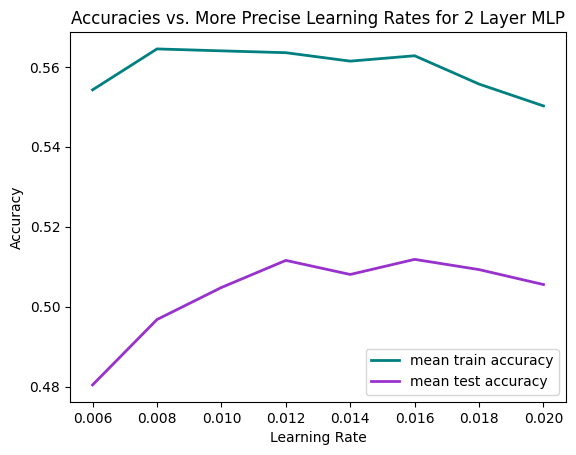

In [ ]:
x_label = 'Learning Rate'
title = "Accuracies vs. More Precise Learning Rates for 2 Layer MLP"
color1 = 'teal'
color2 = 'darkorchid'

lr_model_train_accs_precise = np.array(lr_model_train_accs_precise).get()
lr_model_test_accs_precise = np.array(lr_model_test_accs_precise).get()

plot_hp(x_label, learning_rates_precise, lr_model_train_accs_precise, lr_model_test_accs_precise, title, color1, color2, log=False)

The optimal value for the learning rate seems to be around 0.013.